In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

In [2]:
## Name model, and load and preprocess dataset

In [3]:
# Define number of epochs used later in training
num_epochs = 500

# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "Transformer_21Met" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [ ]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_Spec.npy')
spectra100 = np.load('Dataset21_100MHz_Spec.npy')
conc1 = np.load('Dataset21_Conc.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')
#pectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
#RepSpectra400 = np.load("Dataset21_400MHz_RepresentativeExamples_Spectra.npy")
#RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
#RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
#RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [6]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, spectra400, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
#RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)   # These spectra are the representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#spectraVal400 = torch.tensor(spectraVal400).float().to(device)
#RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 32, shuffle=True)

In [7]:
del X_train
del X_test
del y_train
del y_test

In [7]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, num_bins, input_dim)
        
        # Reconstruct original sequence
        x = x.view(batch_size, -1)  # (batch_size, seq_length)
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 8         # Number of attention heads
num_encoder_layers = 6  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.1     # Dropout rate

# Initialize the model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)


In [9]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 25  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        
         # Instantiate the GradScaler
        scaler = GradScaler()
        for inputs, labels in train_loader:
            # Move data to GPU
             inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
             optimizer.zero_grad()
            # Enable autocasting for forward and backward passes
             with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
             train_loss += loss.item() * inputs.size(0)
             # Scale the loss and perform backpropagation
             scaler.scale(loss).backward()
             # Step the optimizer
             scaler.step(optimizer)
              # Update the scaler
             scaler.update()
        train_losses.append(train_loss)

        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params2.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 92.2585, Test Loss: 1.0646
Epoch time:  11.453235864639282
Epoch [2/500], Train Loss: 4.3953, Test Loss: 0.9958
Epoch time:  10.827538967132568
Epoch [3/500], Train Loss: 3.8456, Test Loss: 0.8924
Epoch time:  10.906831979751587
Epoch [4/500], Train Loss: 3.6258, Test Loss: 0.8657
Epoch time:  10.91723108291626
Epoch [5/500], Train Loss: 3.2217, Test Loss: 0.6186
Epoch time:  11.041675329208374
Epoch [6/500], Train Loss: 2.2201, Test Loss: 0.4272
Epoch time:  10.192101240158081
Epoch [7/500], Train Loss: 1.6876, Test Loss: 0.3352
Epoch time:  10.815917253494263
Epoch [8/500], Train Loss: 1.3243, Test Loss: 0.2434
Epoch time:  11.11792778968811
Epoch [9/500], Train Loss: 1.0365, Test Loss: 0.1919
Epoch time:  9.989267826080322
Epoch [10/500], Train Loss: 0.8400, Test Loss: 0.1490
Epoch time:  10.90893840789795
Epoch [11/500], Train Loss: 0.7313, Test Loss: 0.1261
Epoch time:  10.85764217376709
Epoch [12/500], T

In [8]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model.to(device)

Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=512, out_features=1000, bias=True)
)

In [9]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')


# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')


spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
spectraVal400 = torch.tensor(spectraVal400).float().to(device)


In [8]:
## Switch to directory for saving model metrics
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics')

criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(spectraVal100[:100])  # Evaluate input spectra 

mse = criterion(outputs, spectraVal400[:100])


# Print MSE
print('model err: ', mse)  # Print MSE

# Save RMSE to a file
np.save(ModelName + "ValMSE.npy", mse.cpu().detach().numpy())

model err:  tensor(6.4658e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:
## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

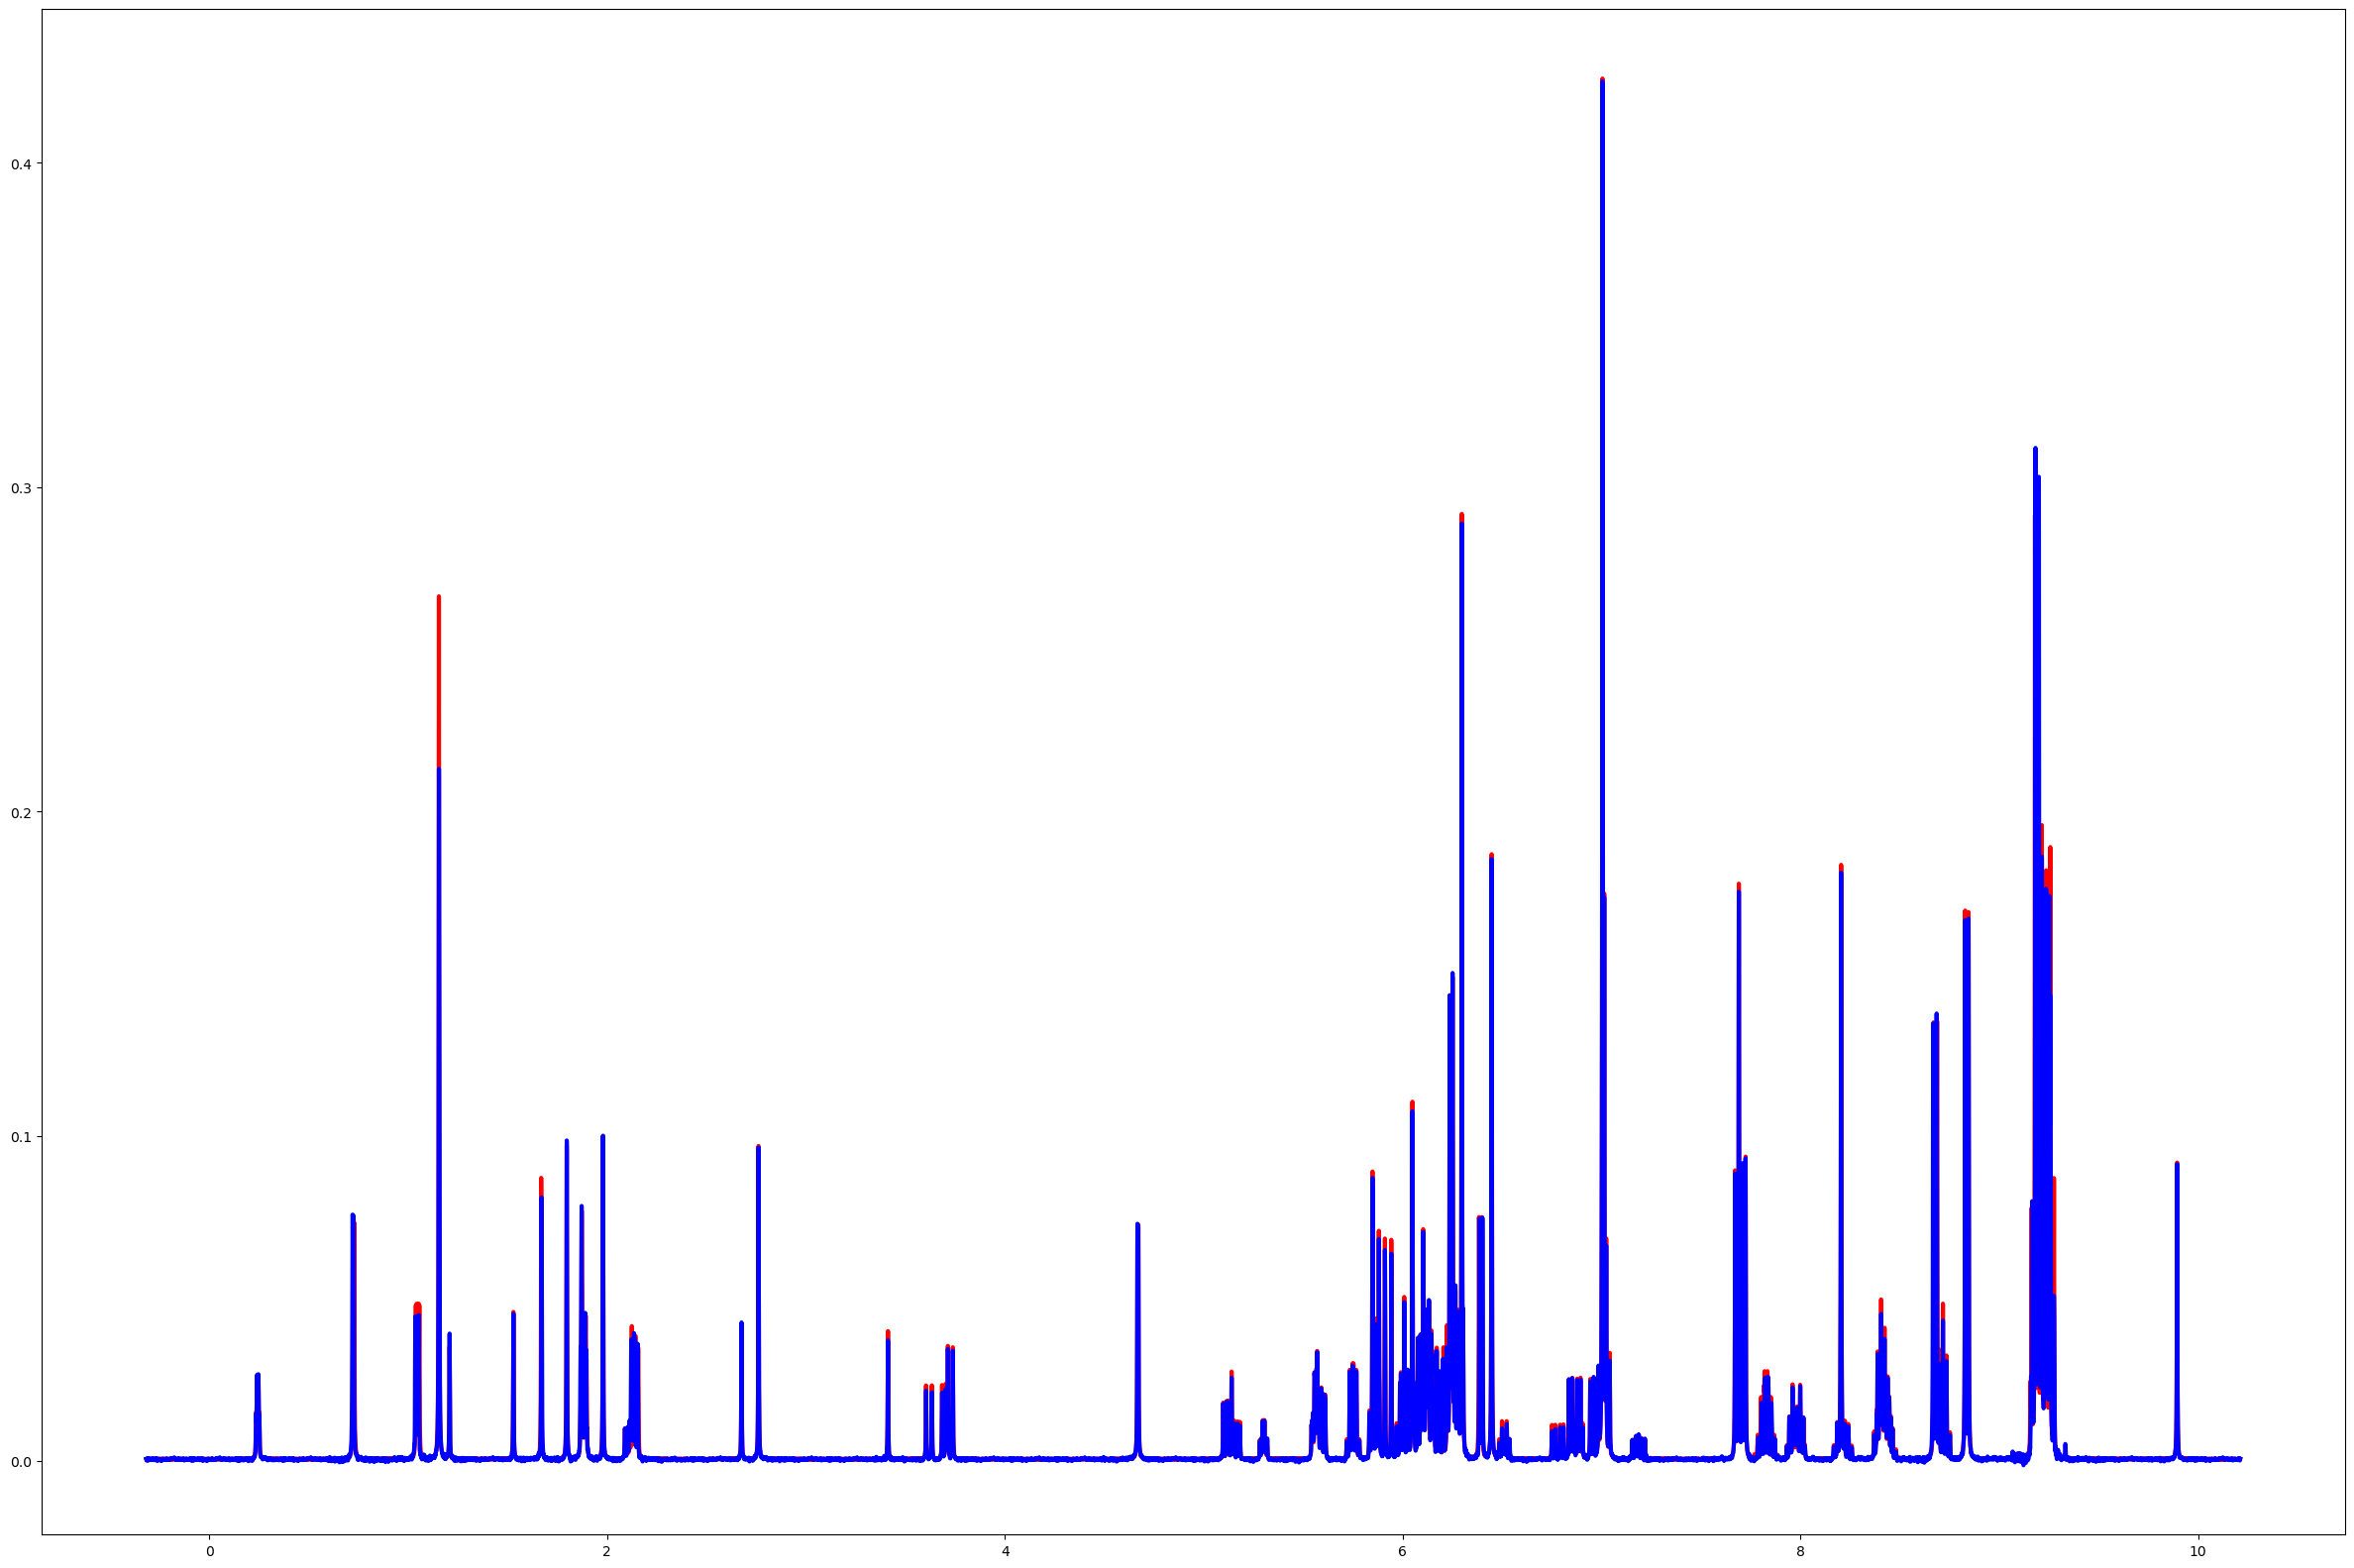

tensor(5.4683e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


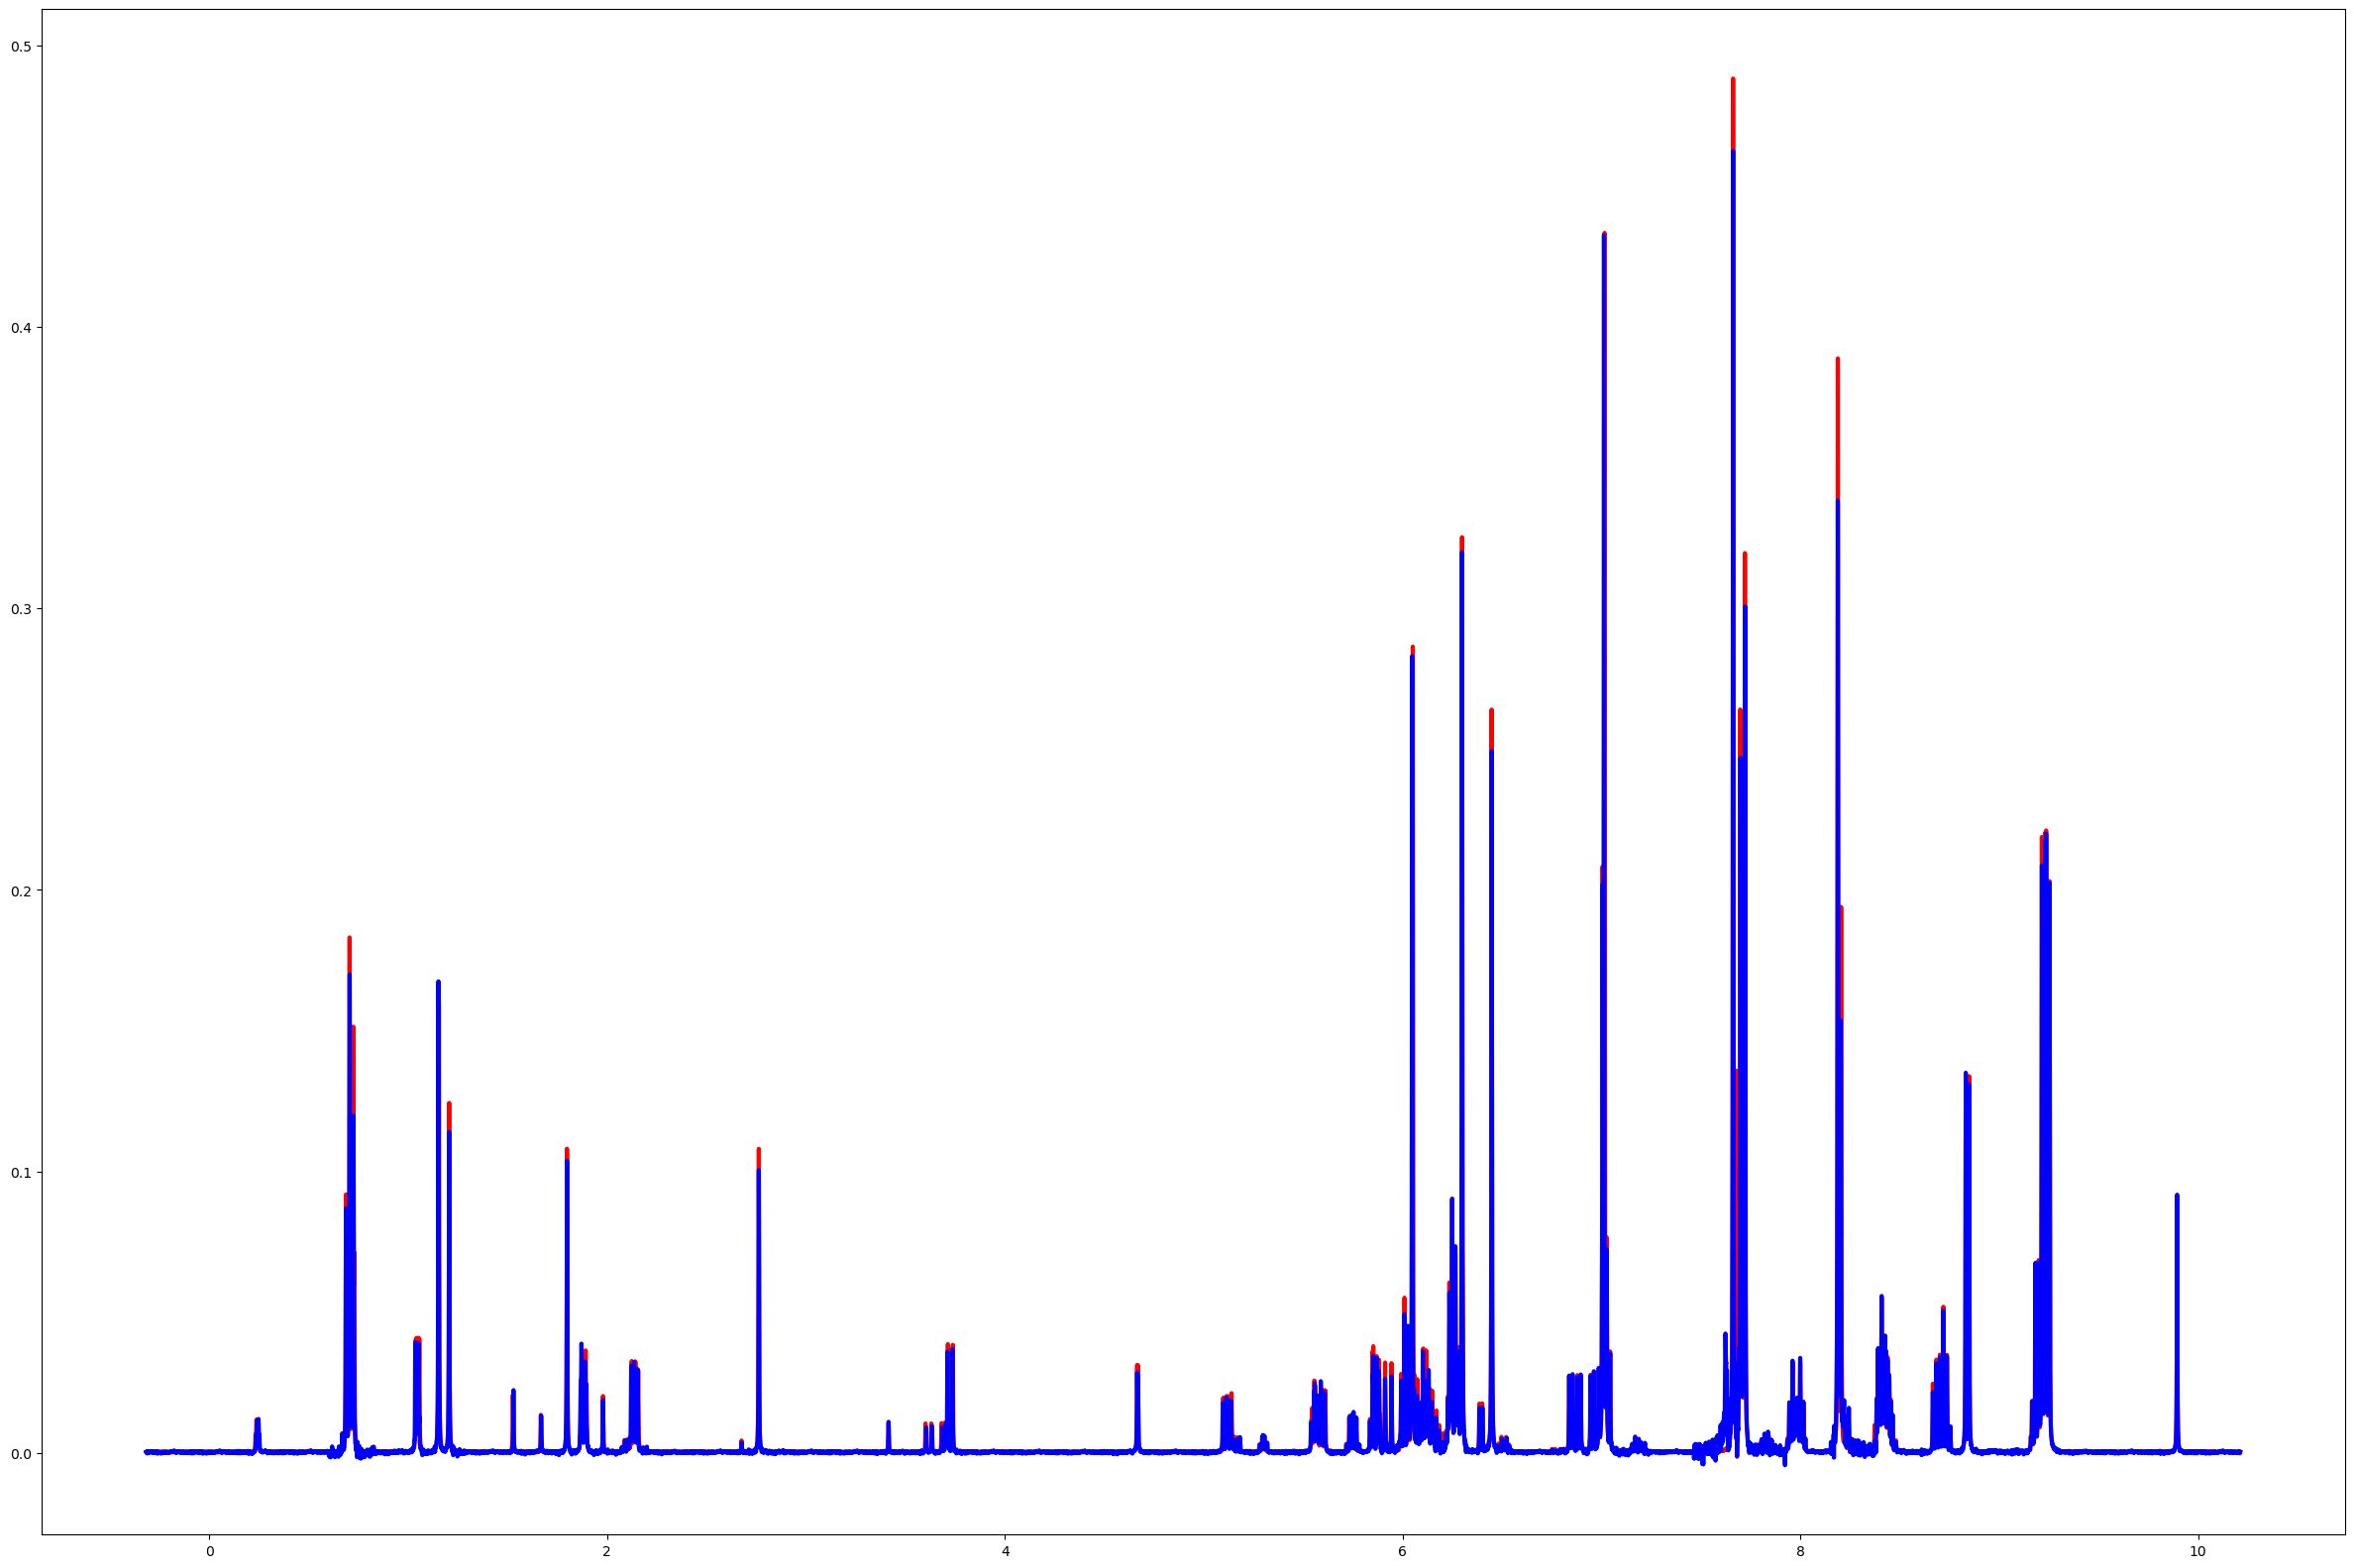

tensor(9.0491e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


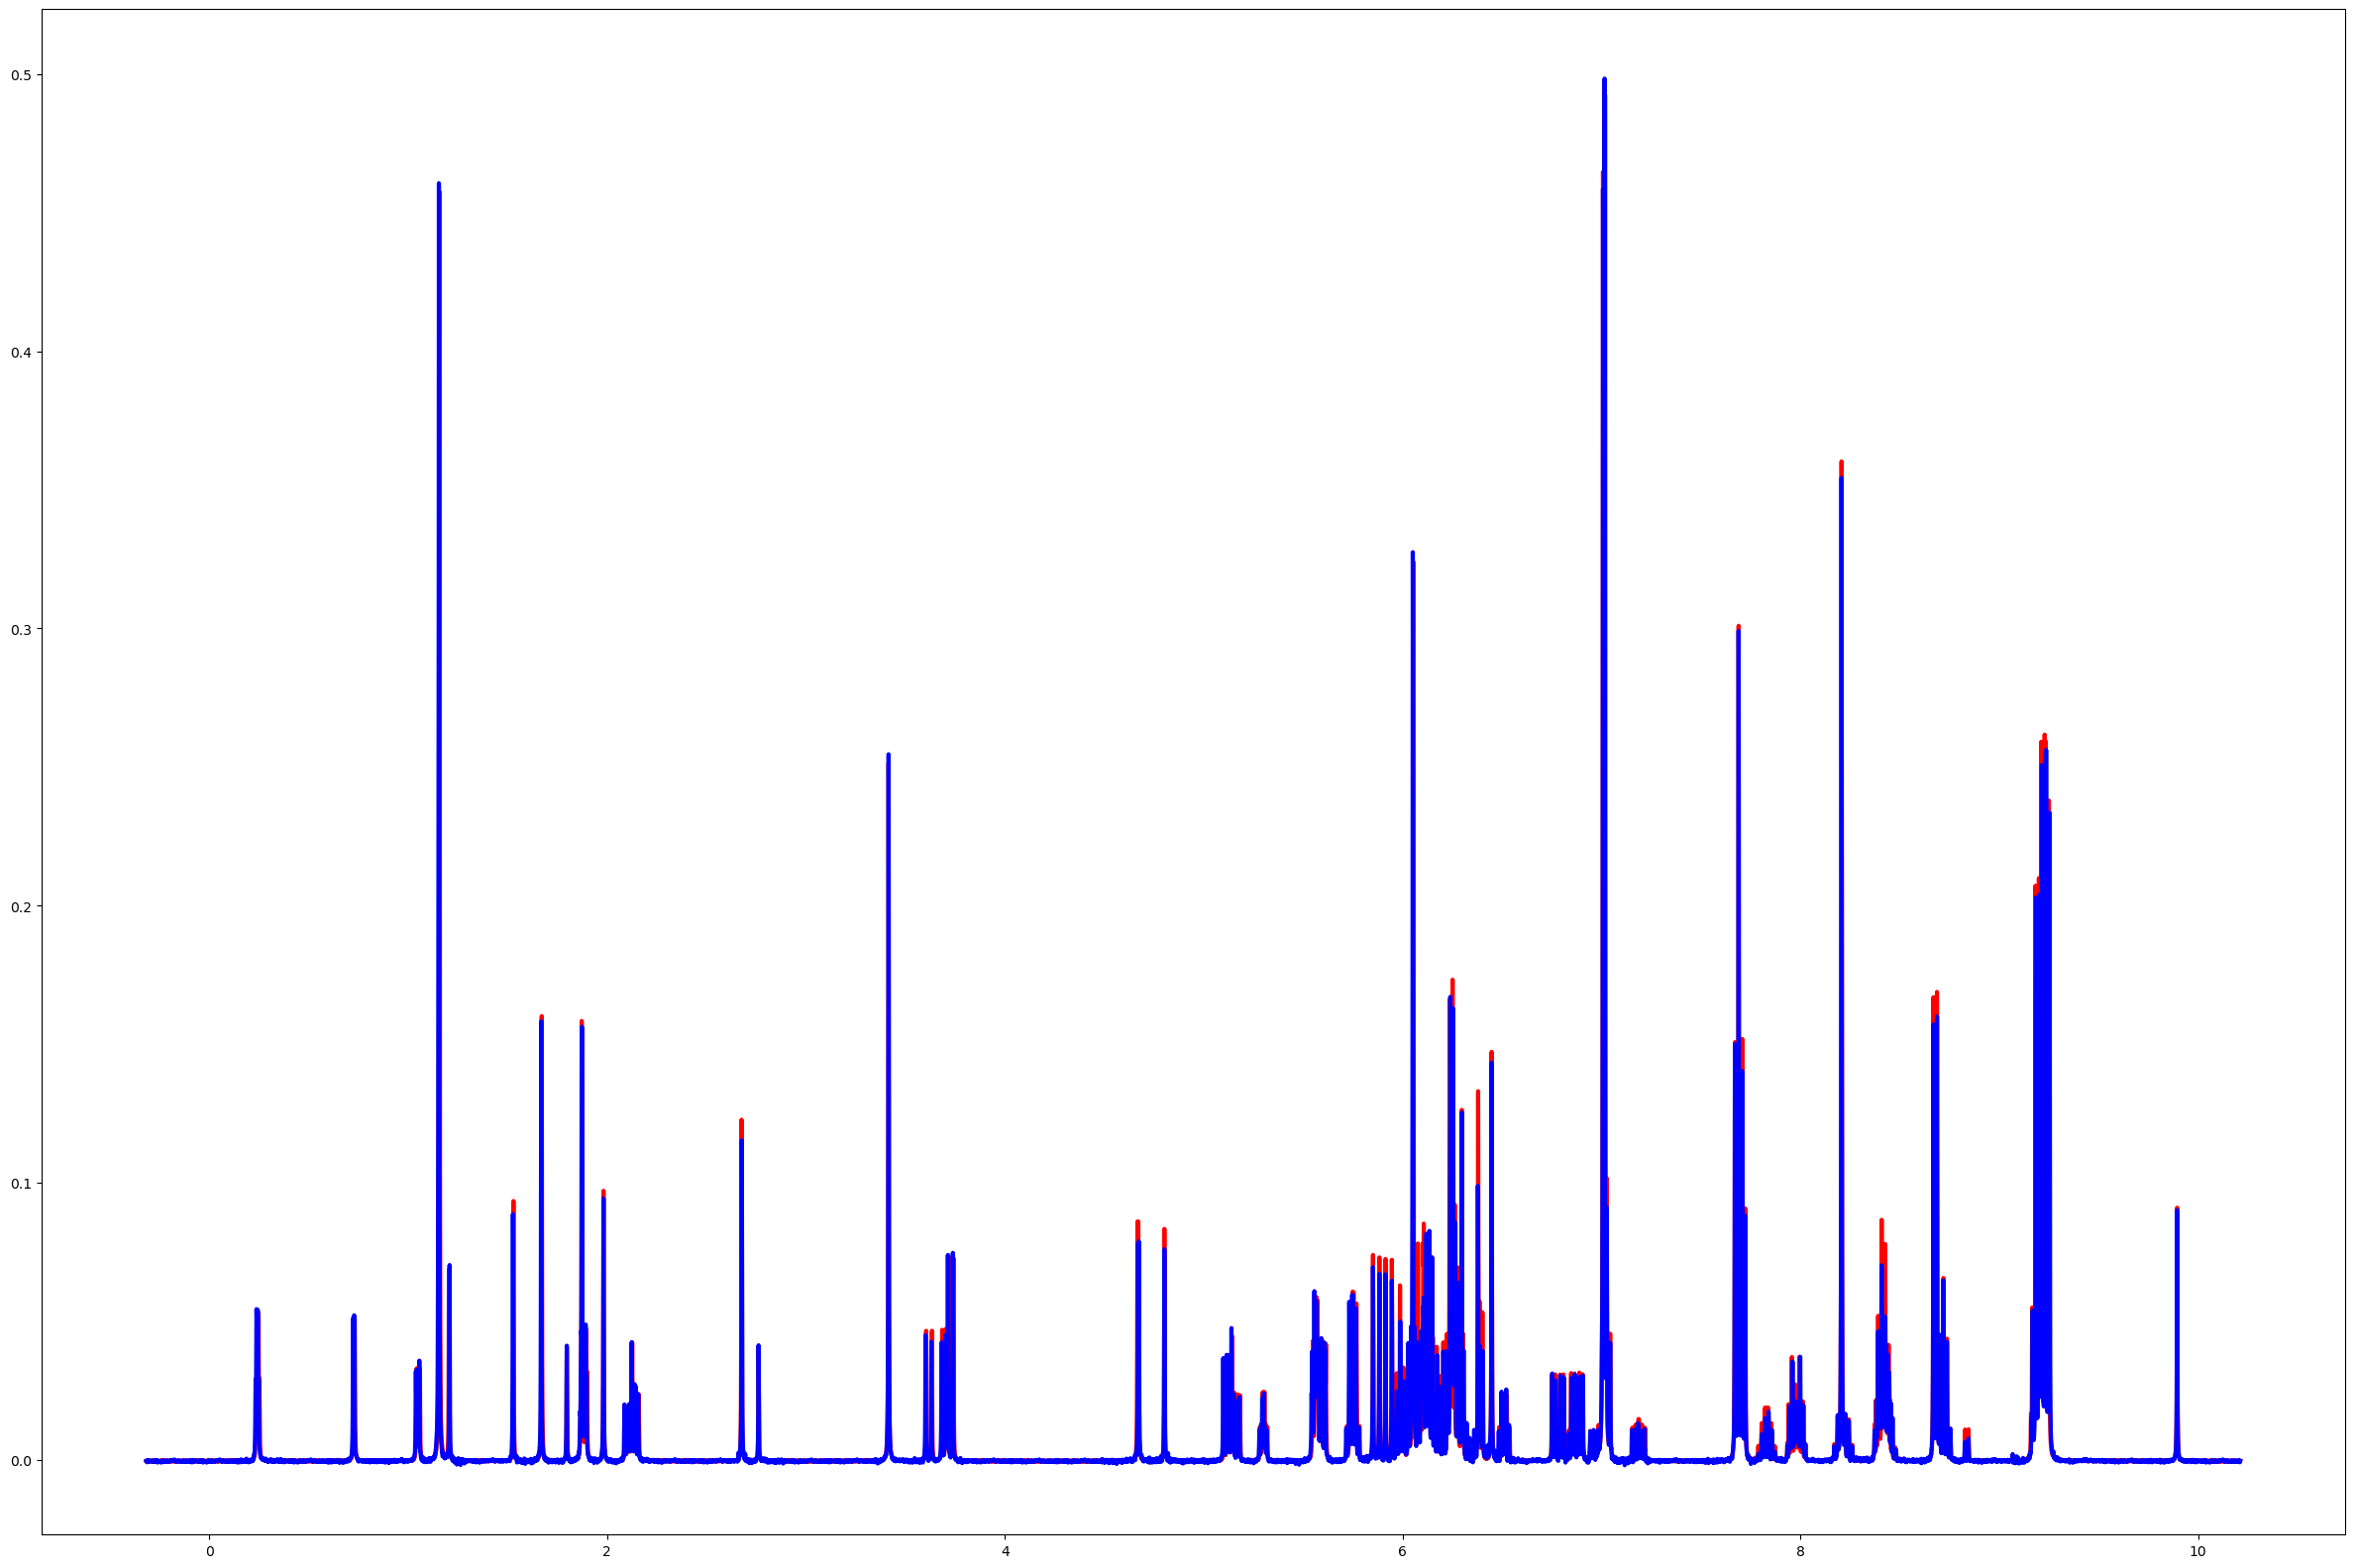

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


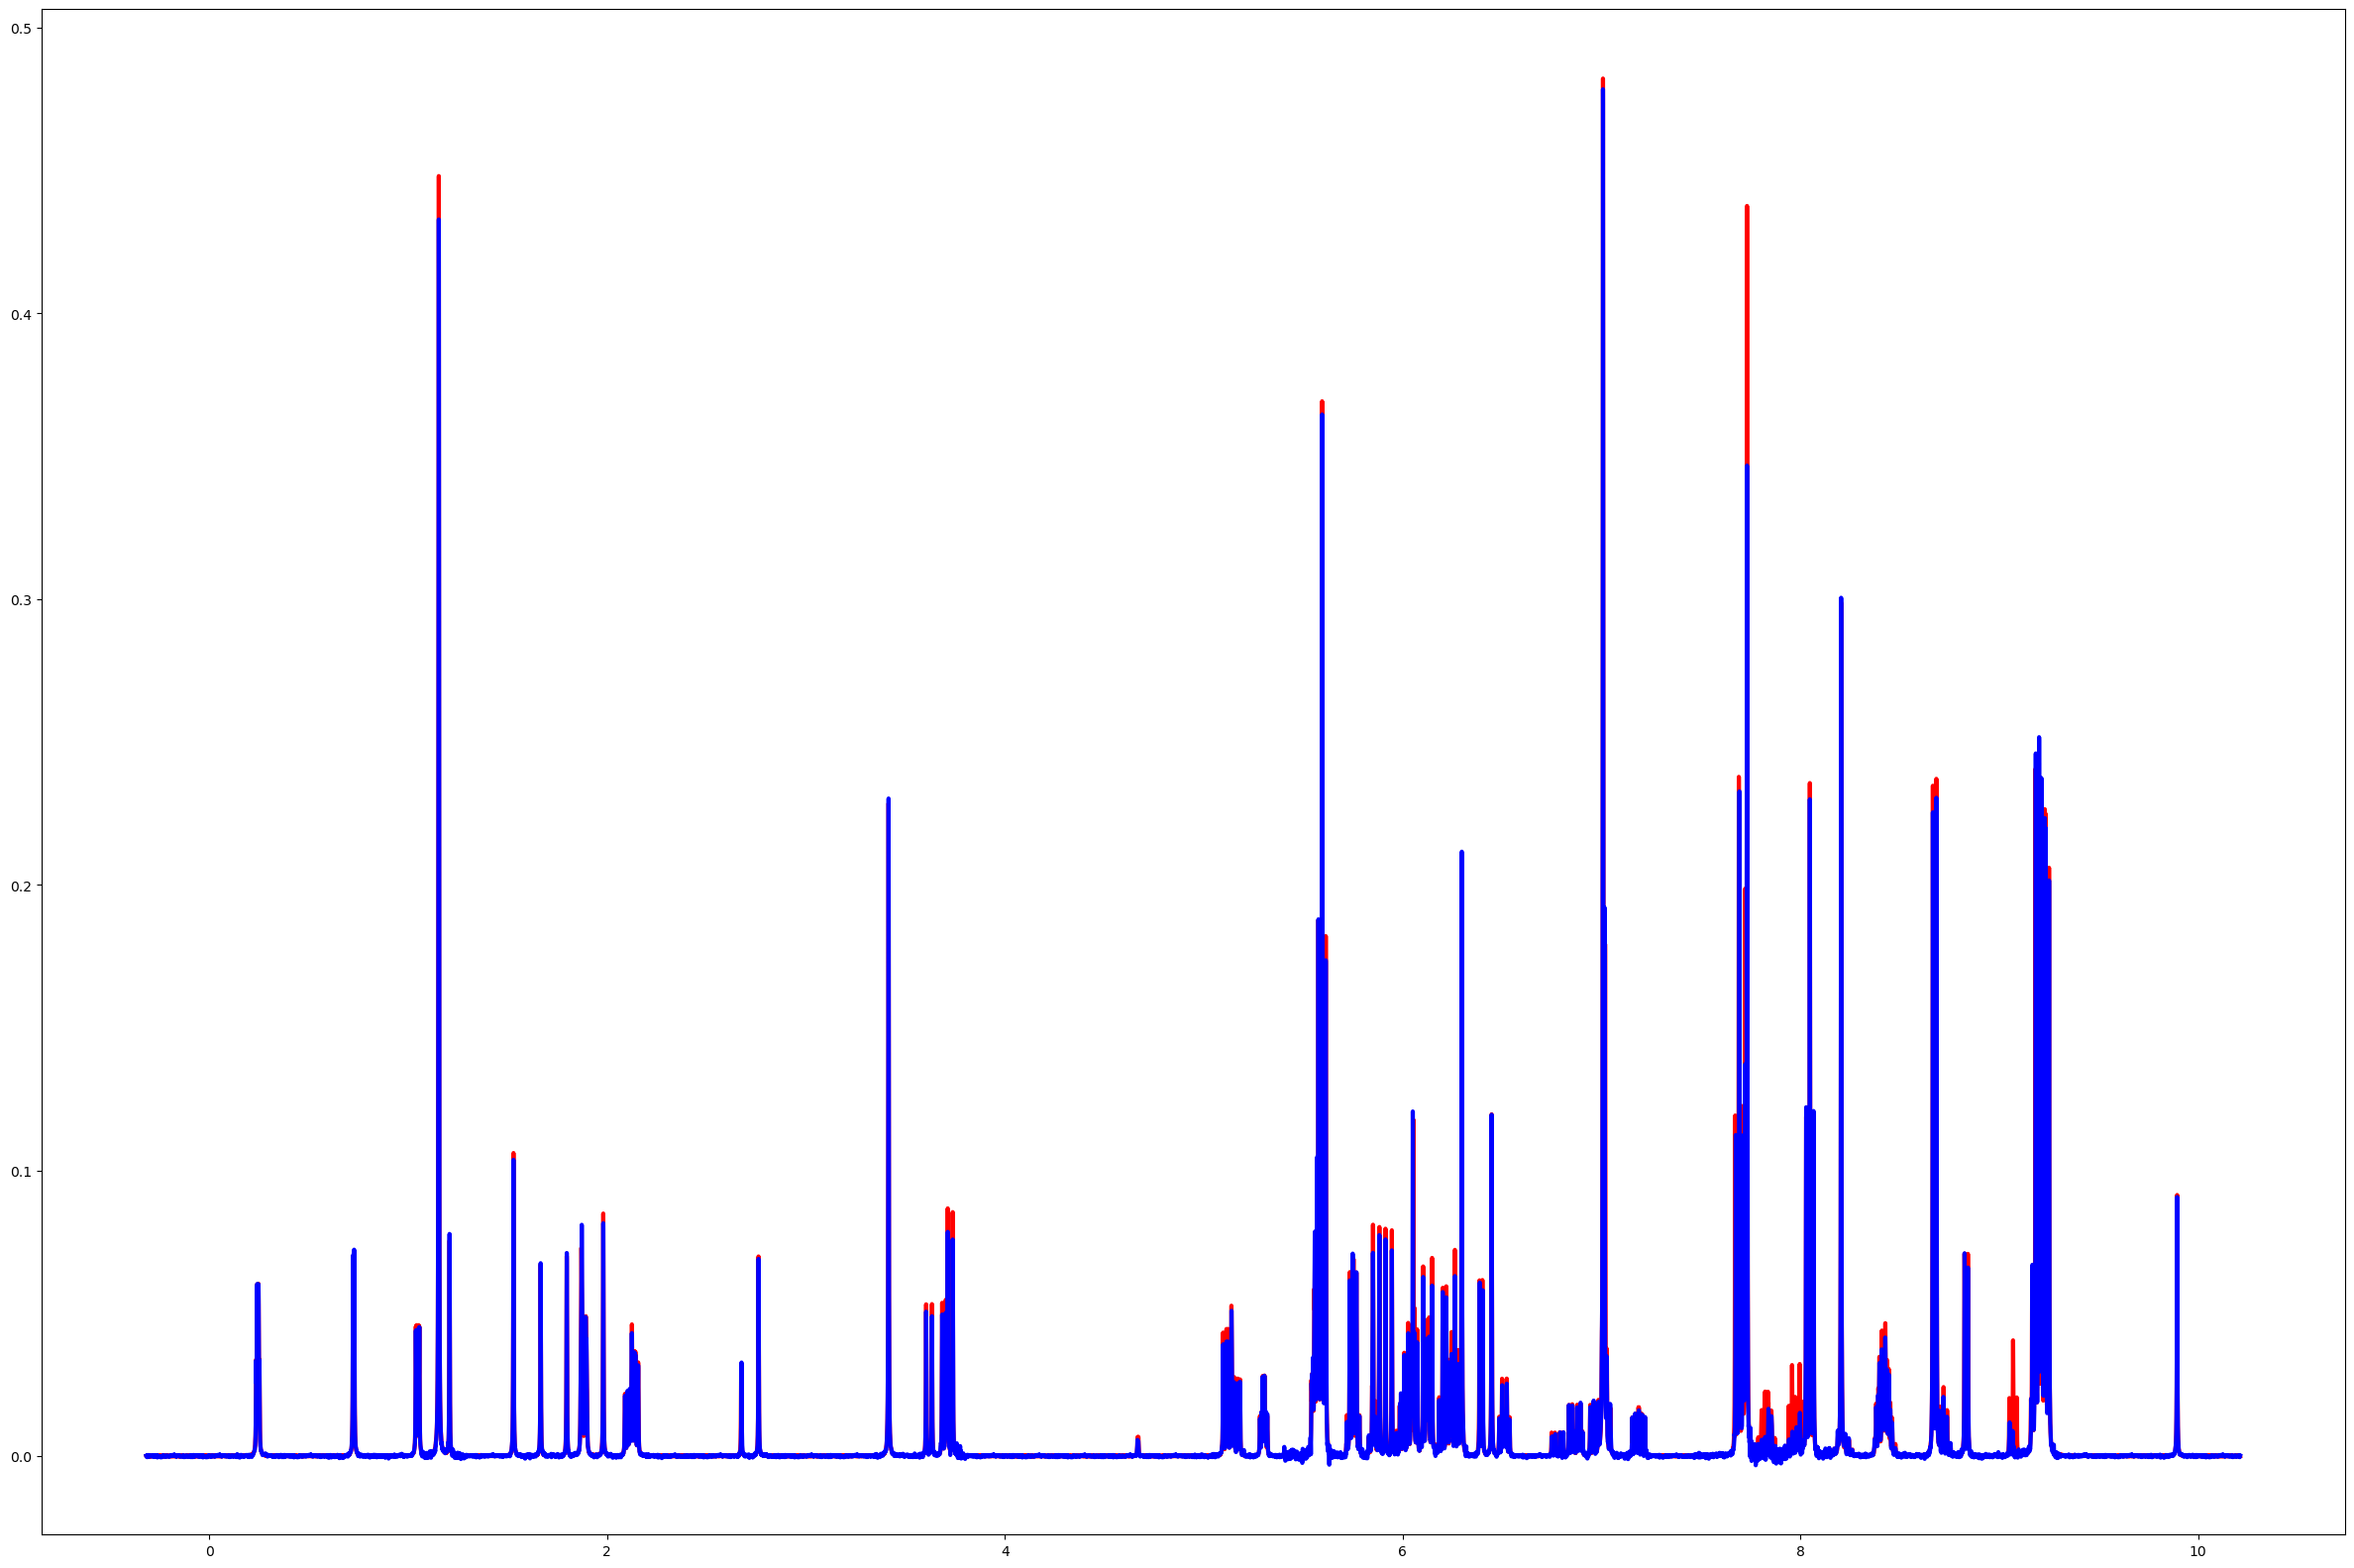

tensor(4.1309e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


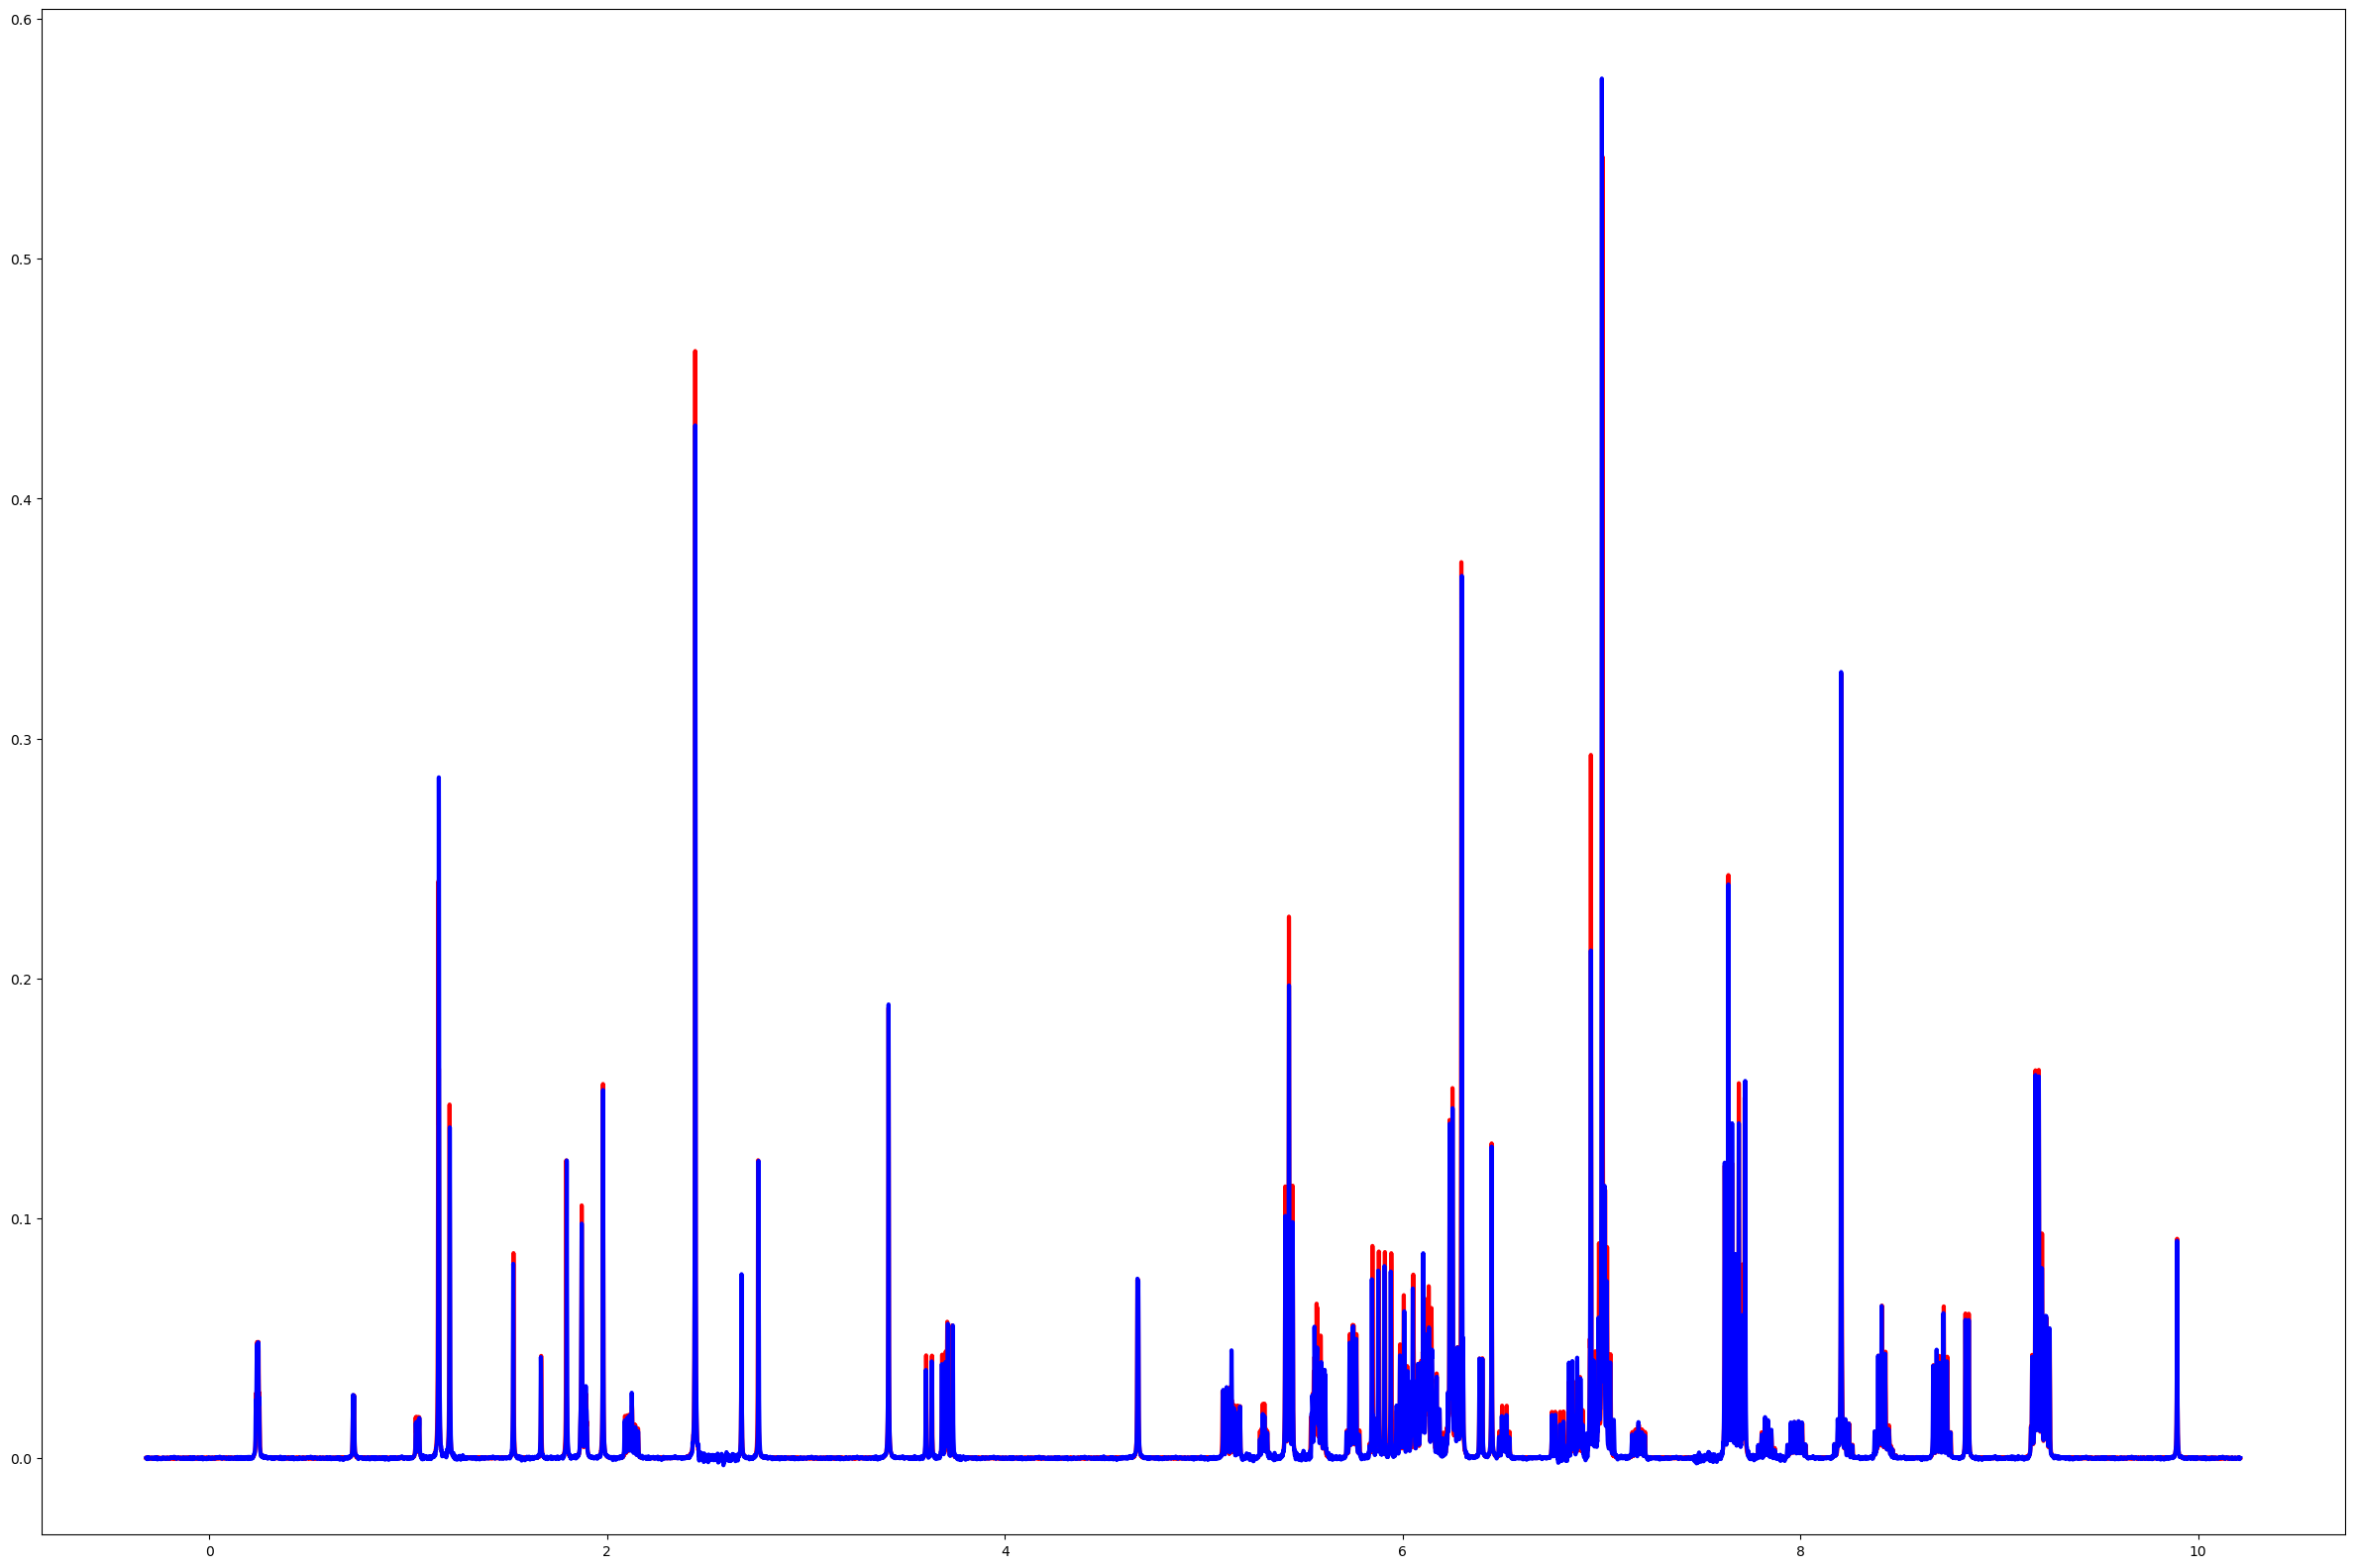

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


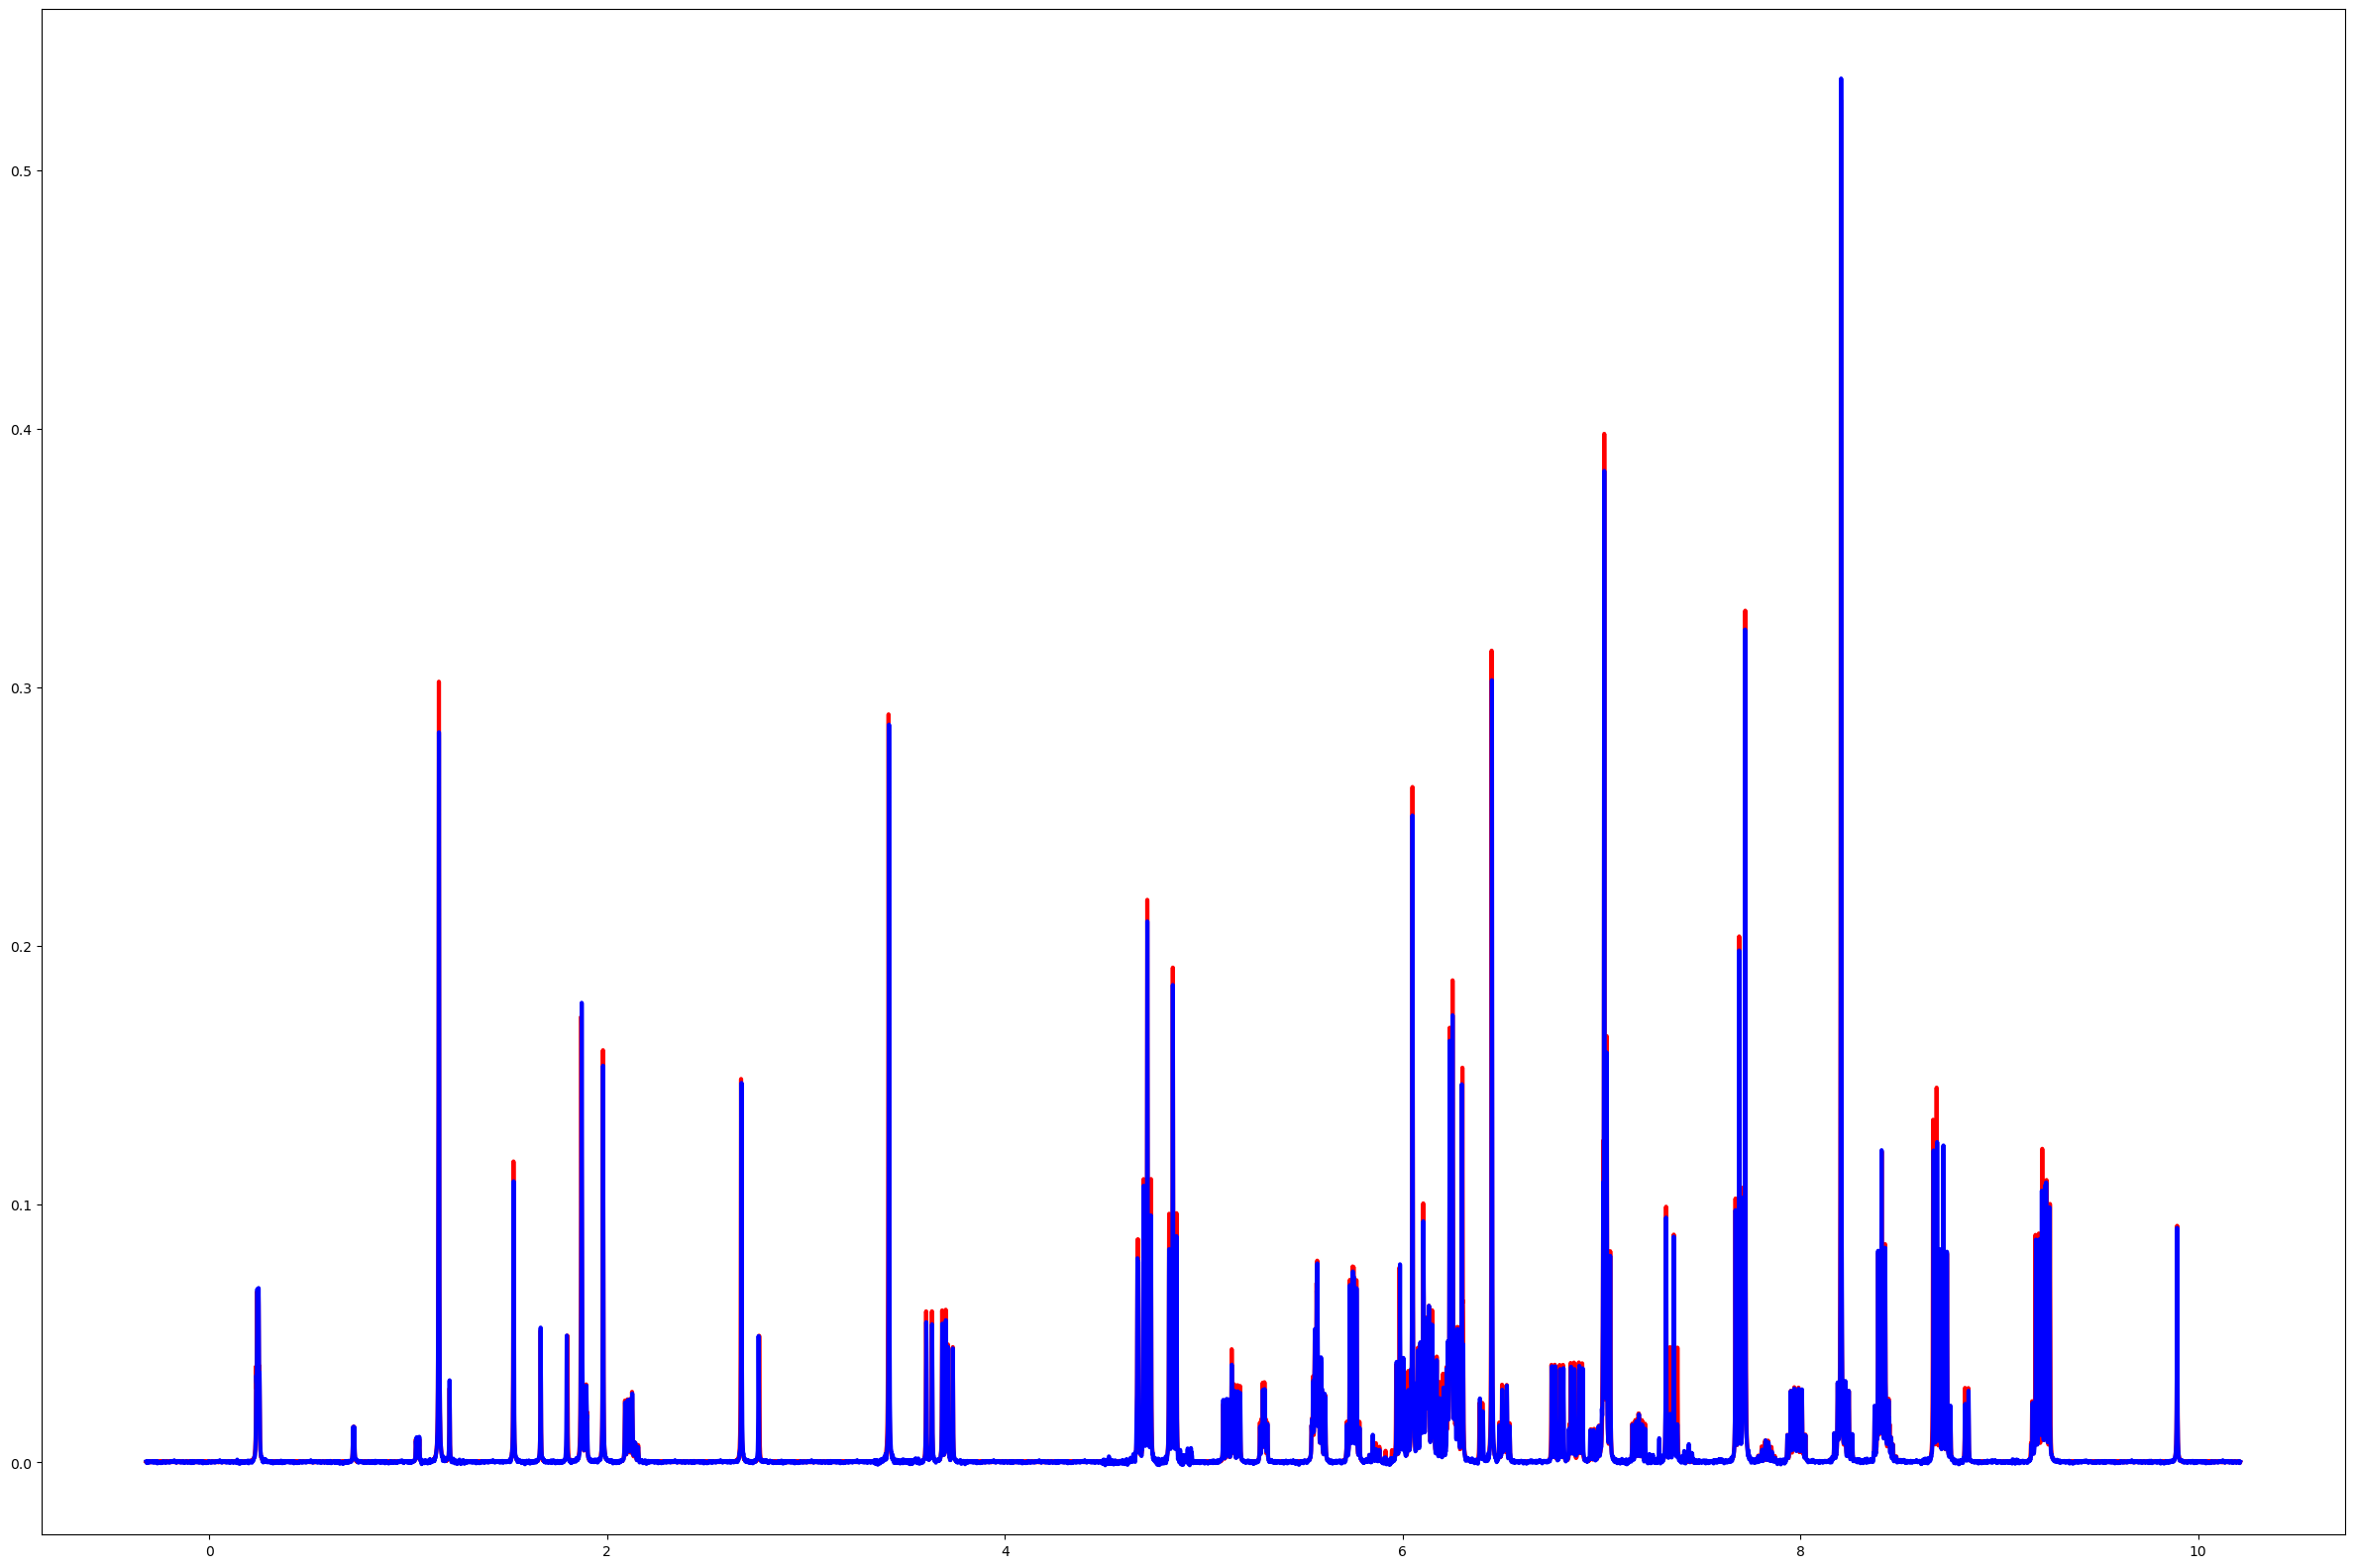

tensor(7.6425e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


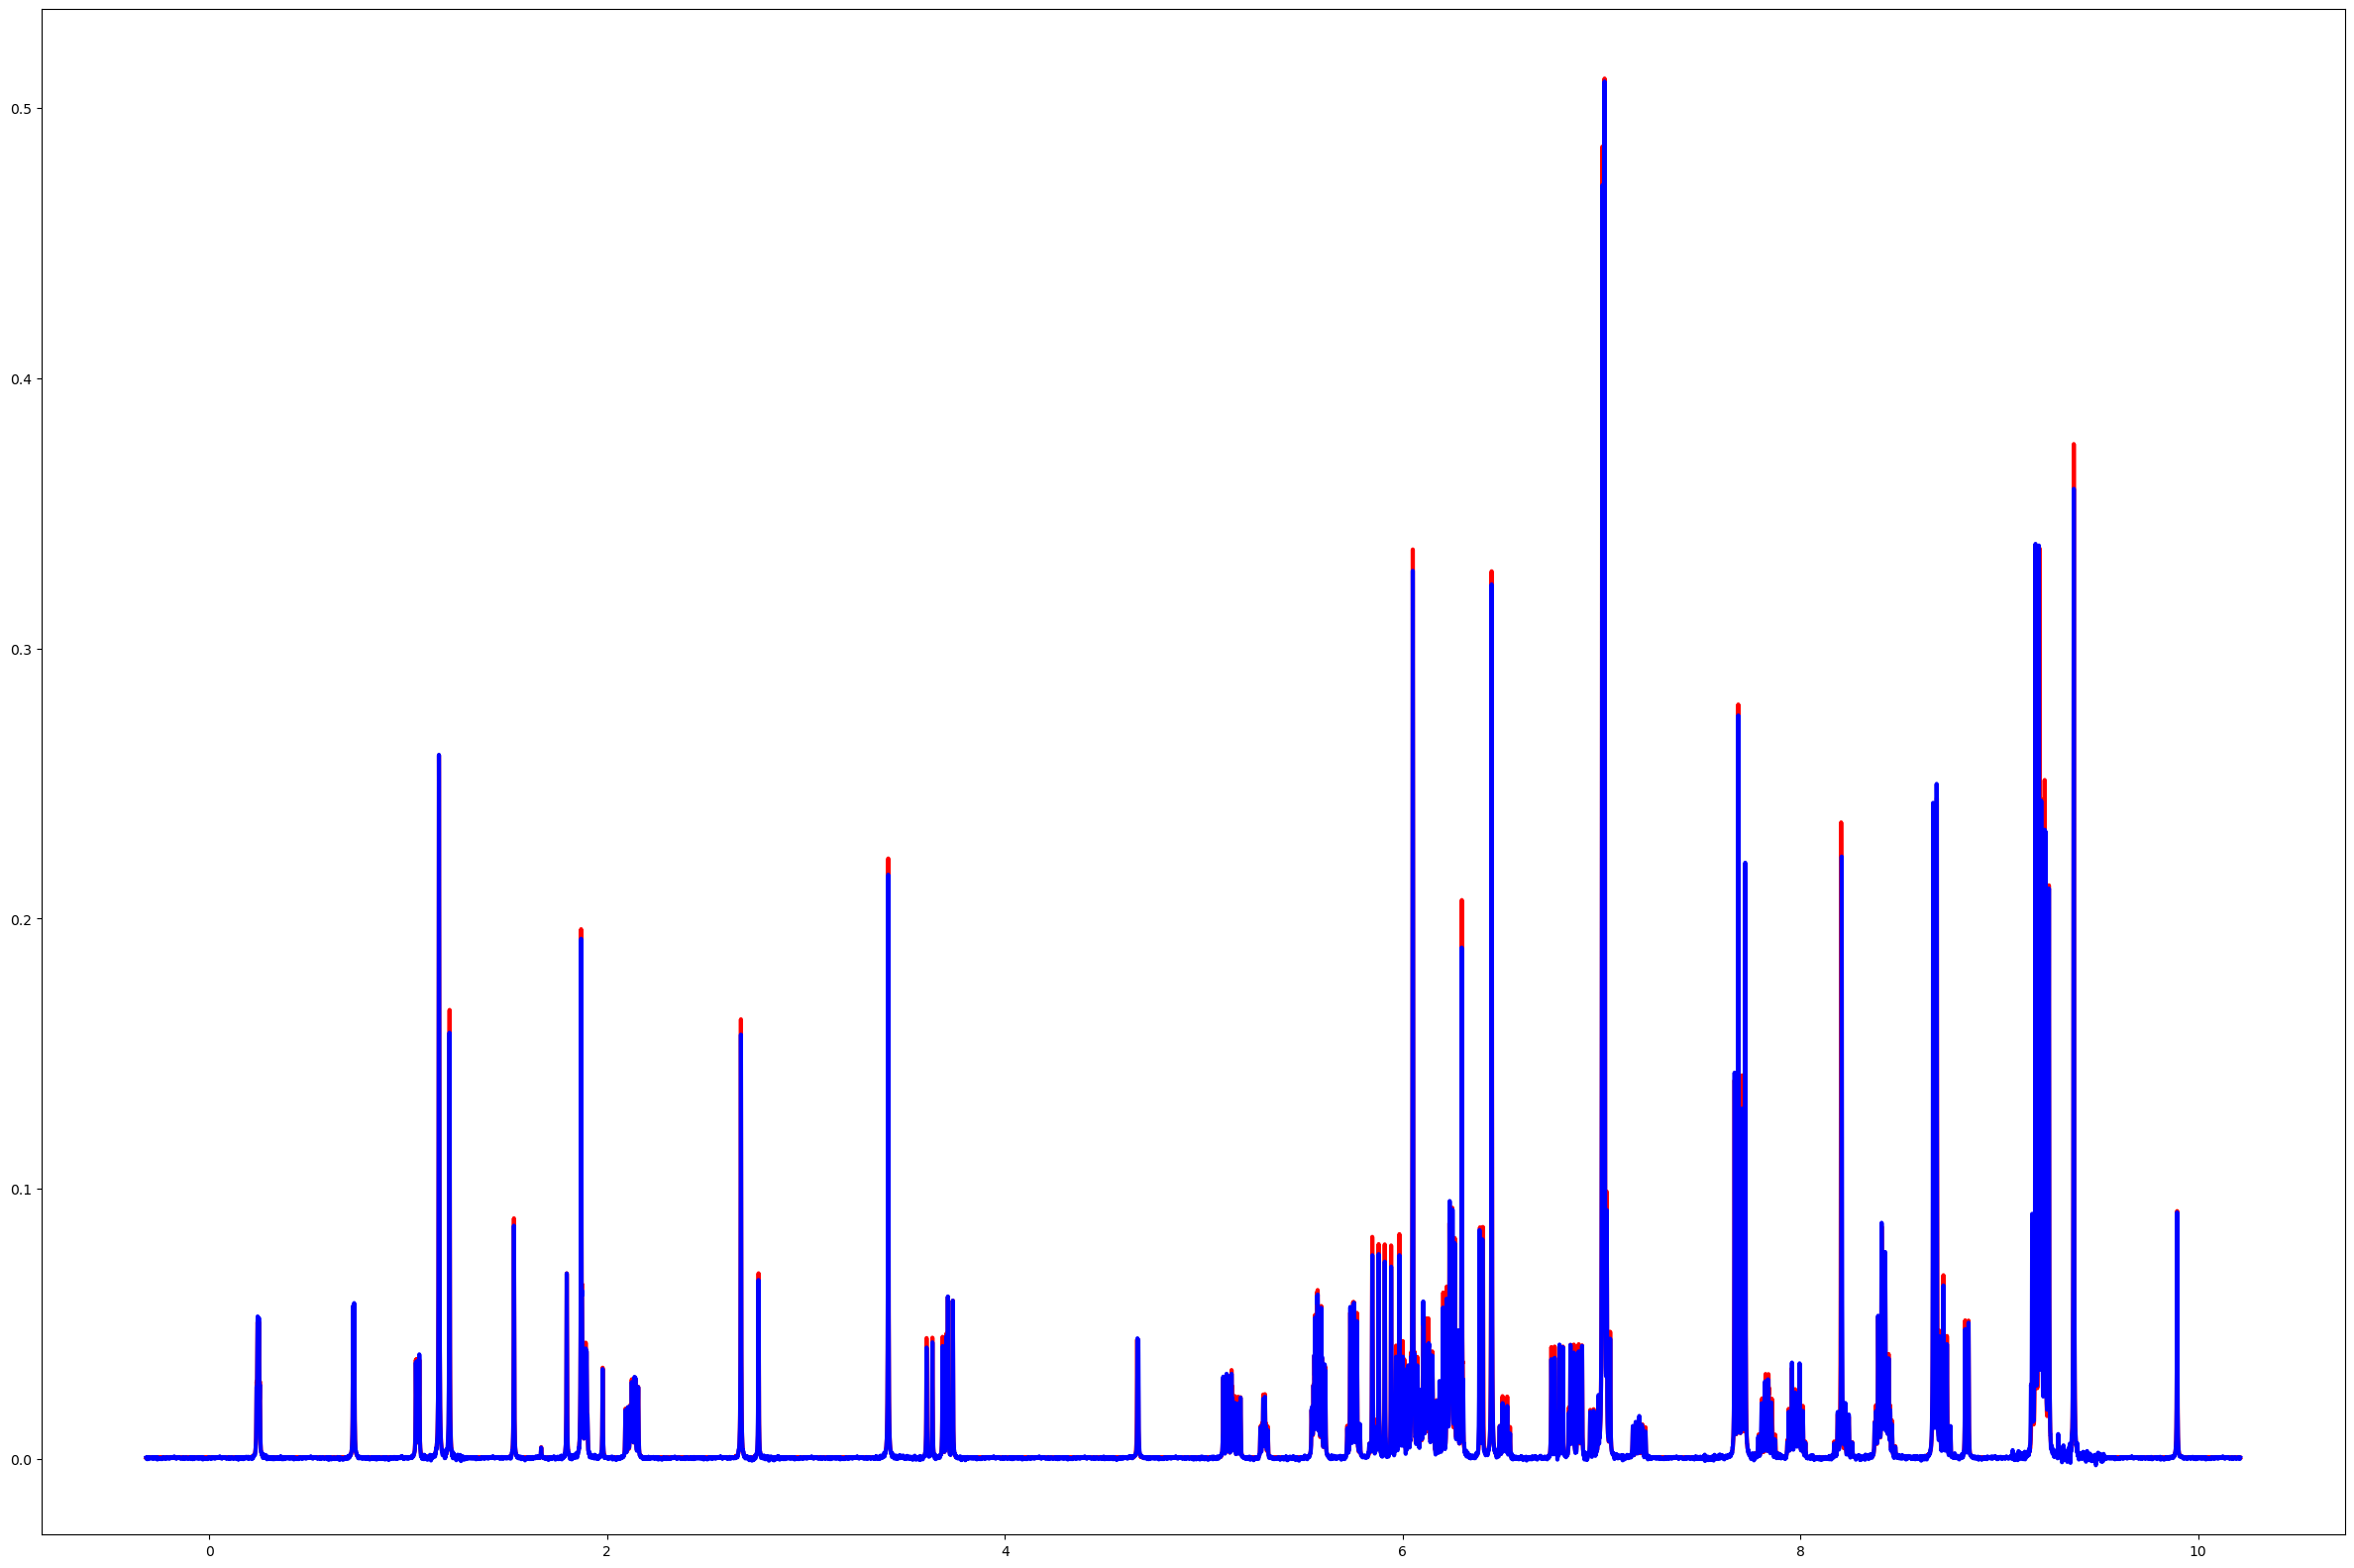

tensor(6.3249e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


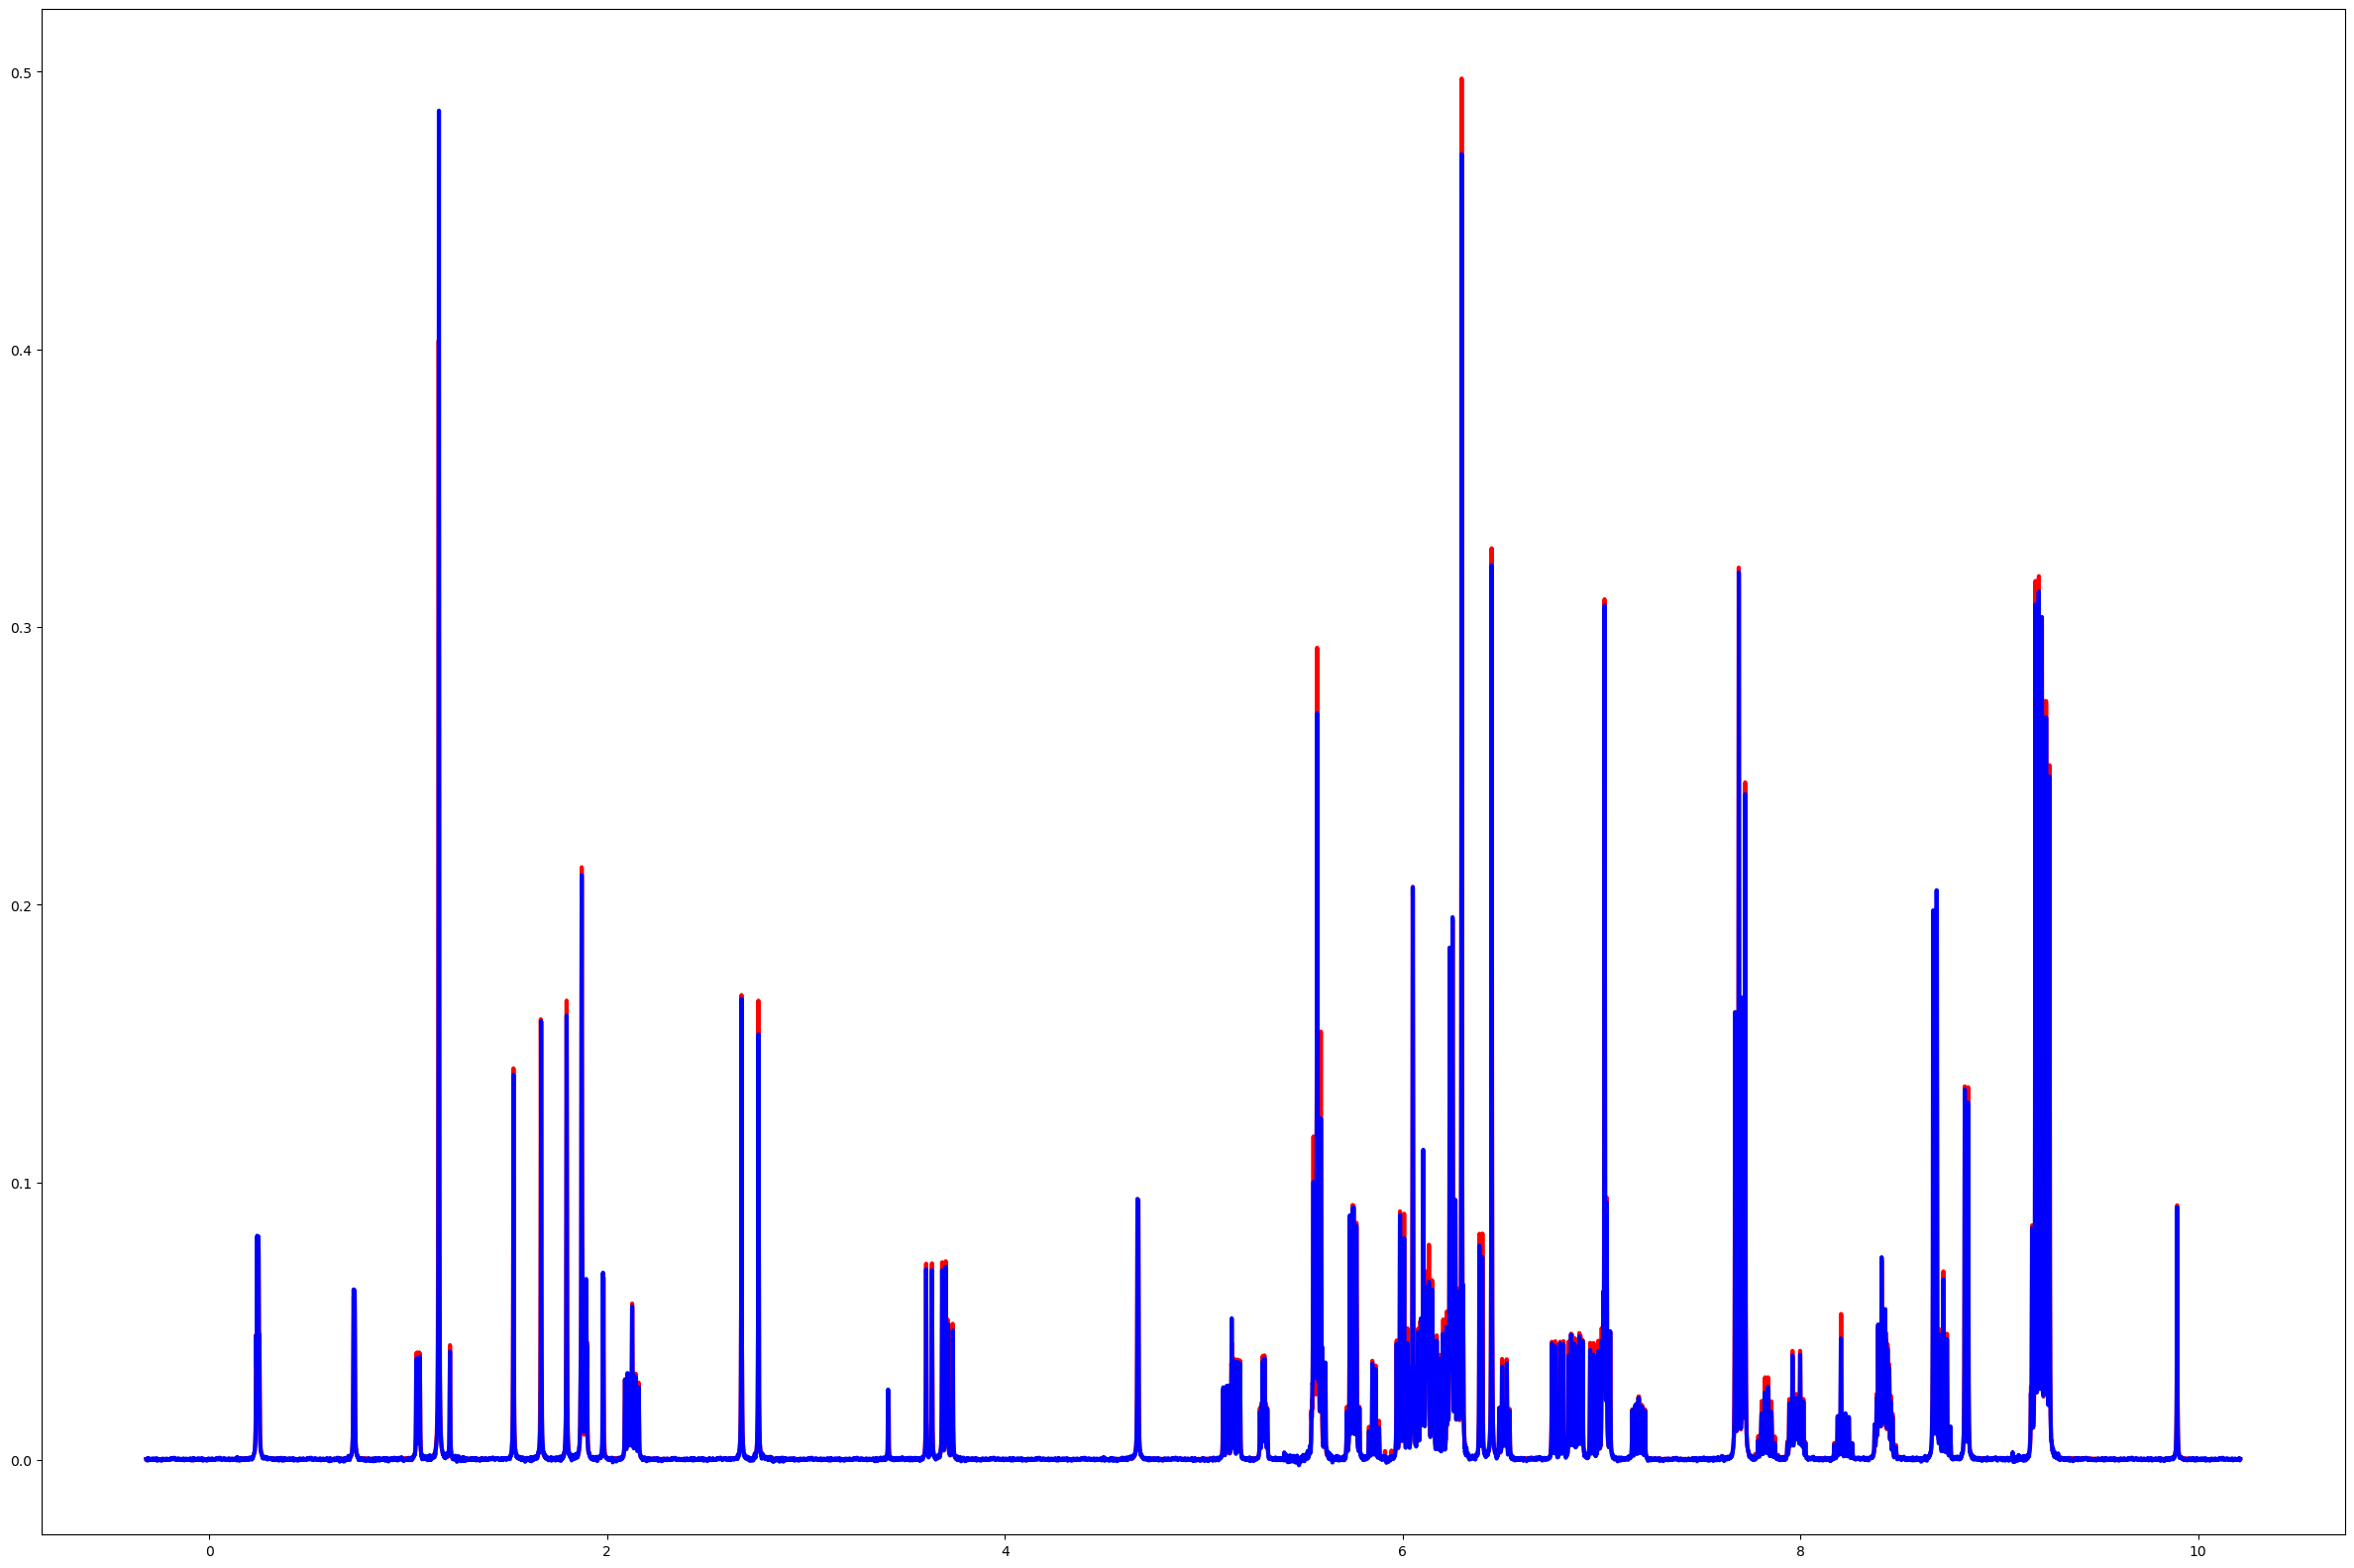

tensor(2.9431e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


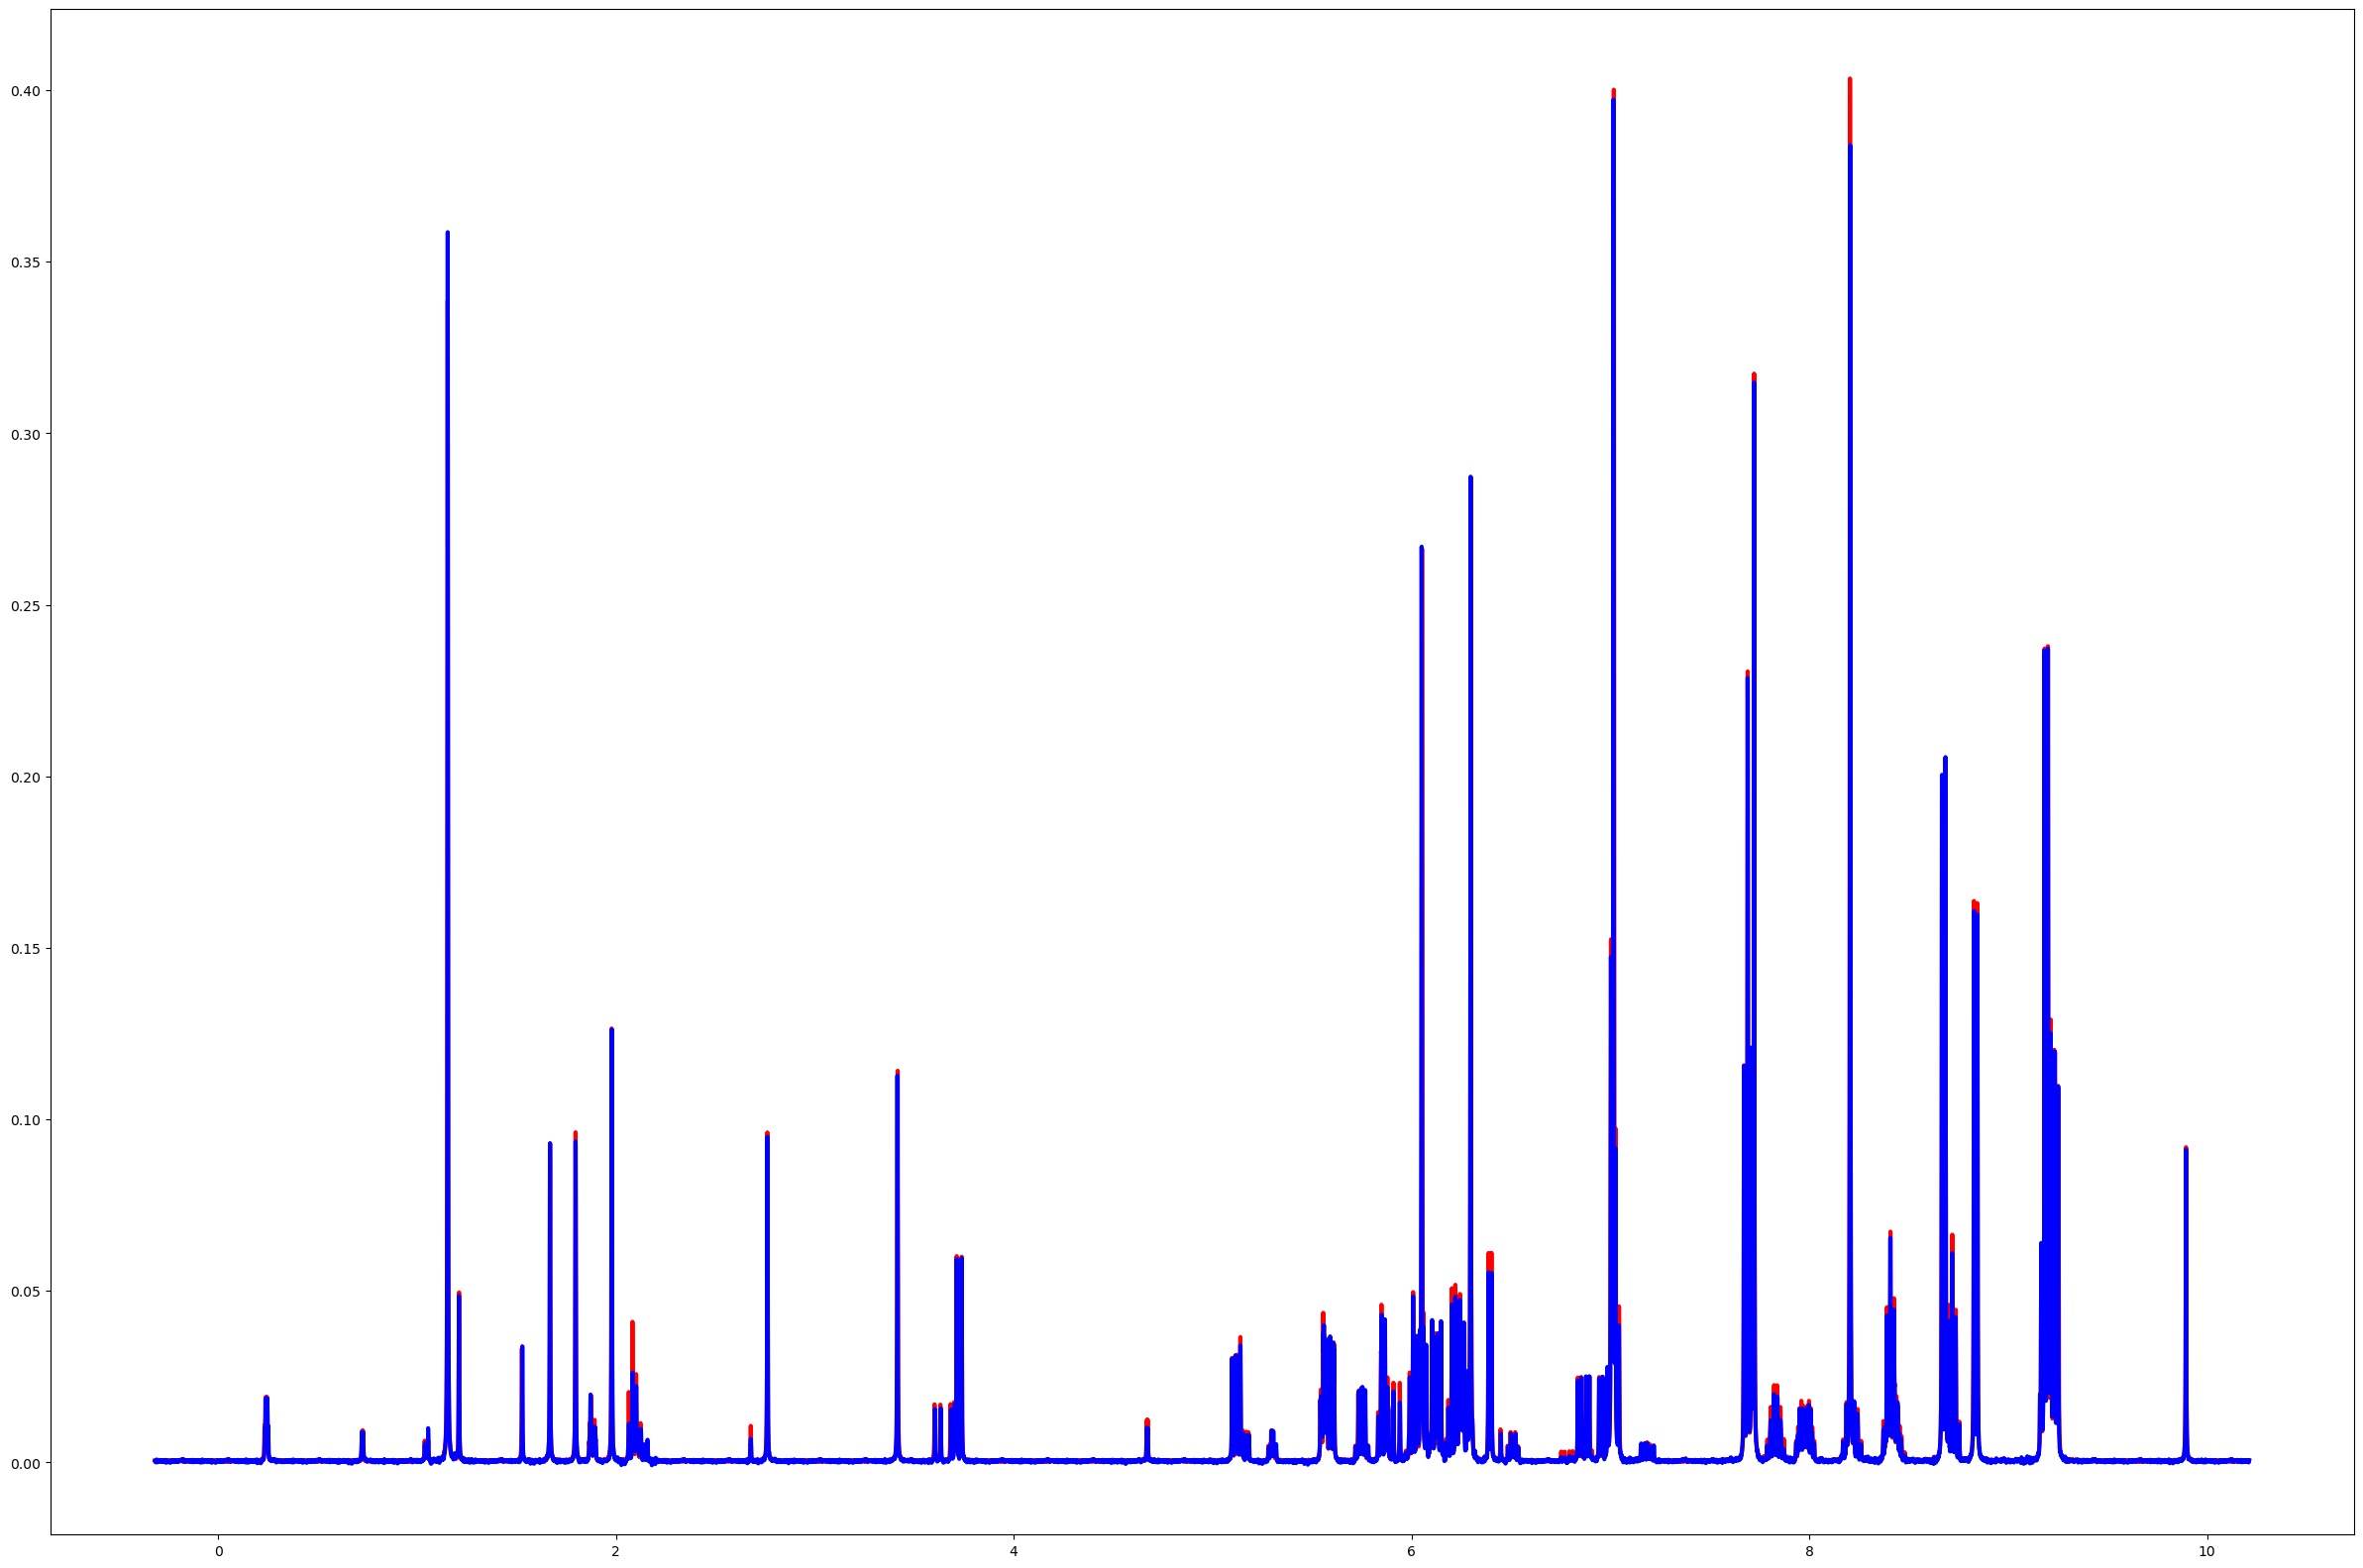

tensor(5.0459e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


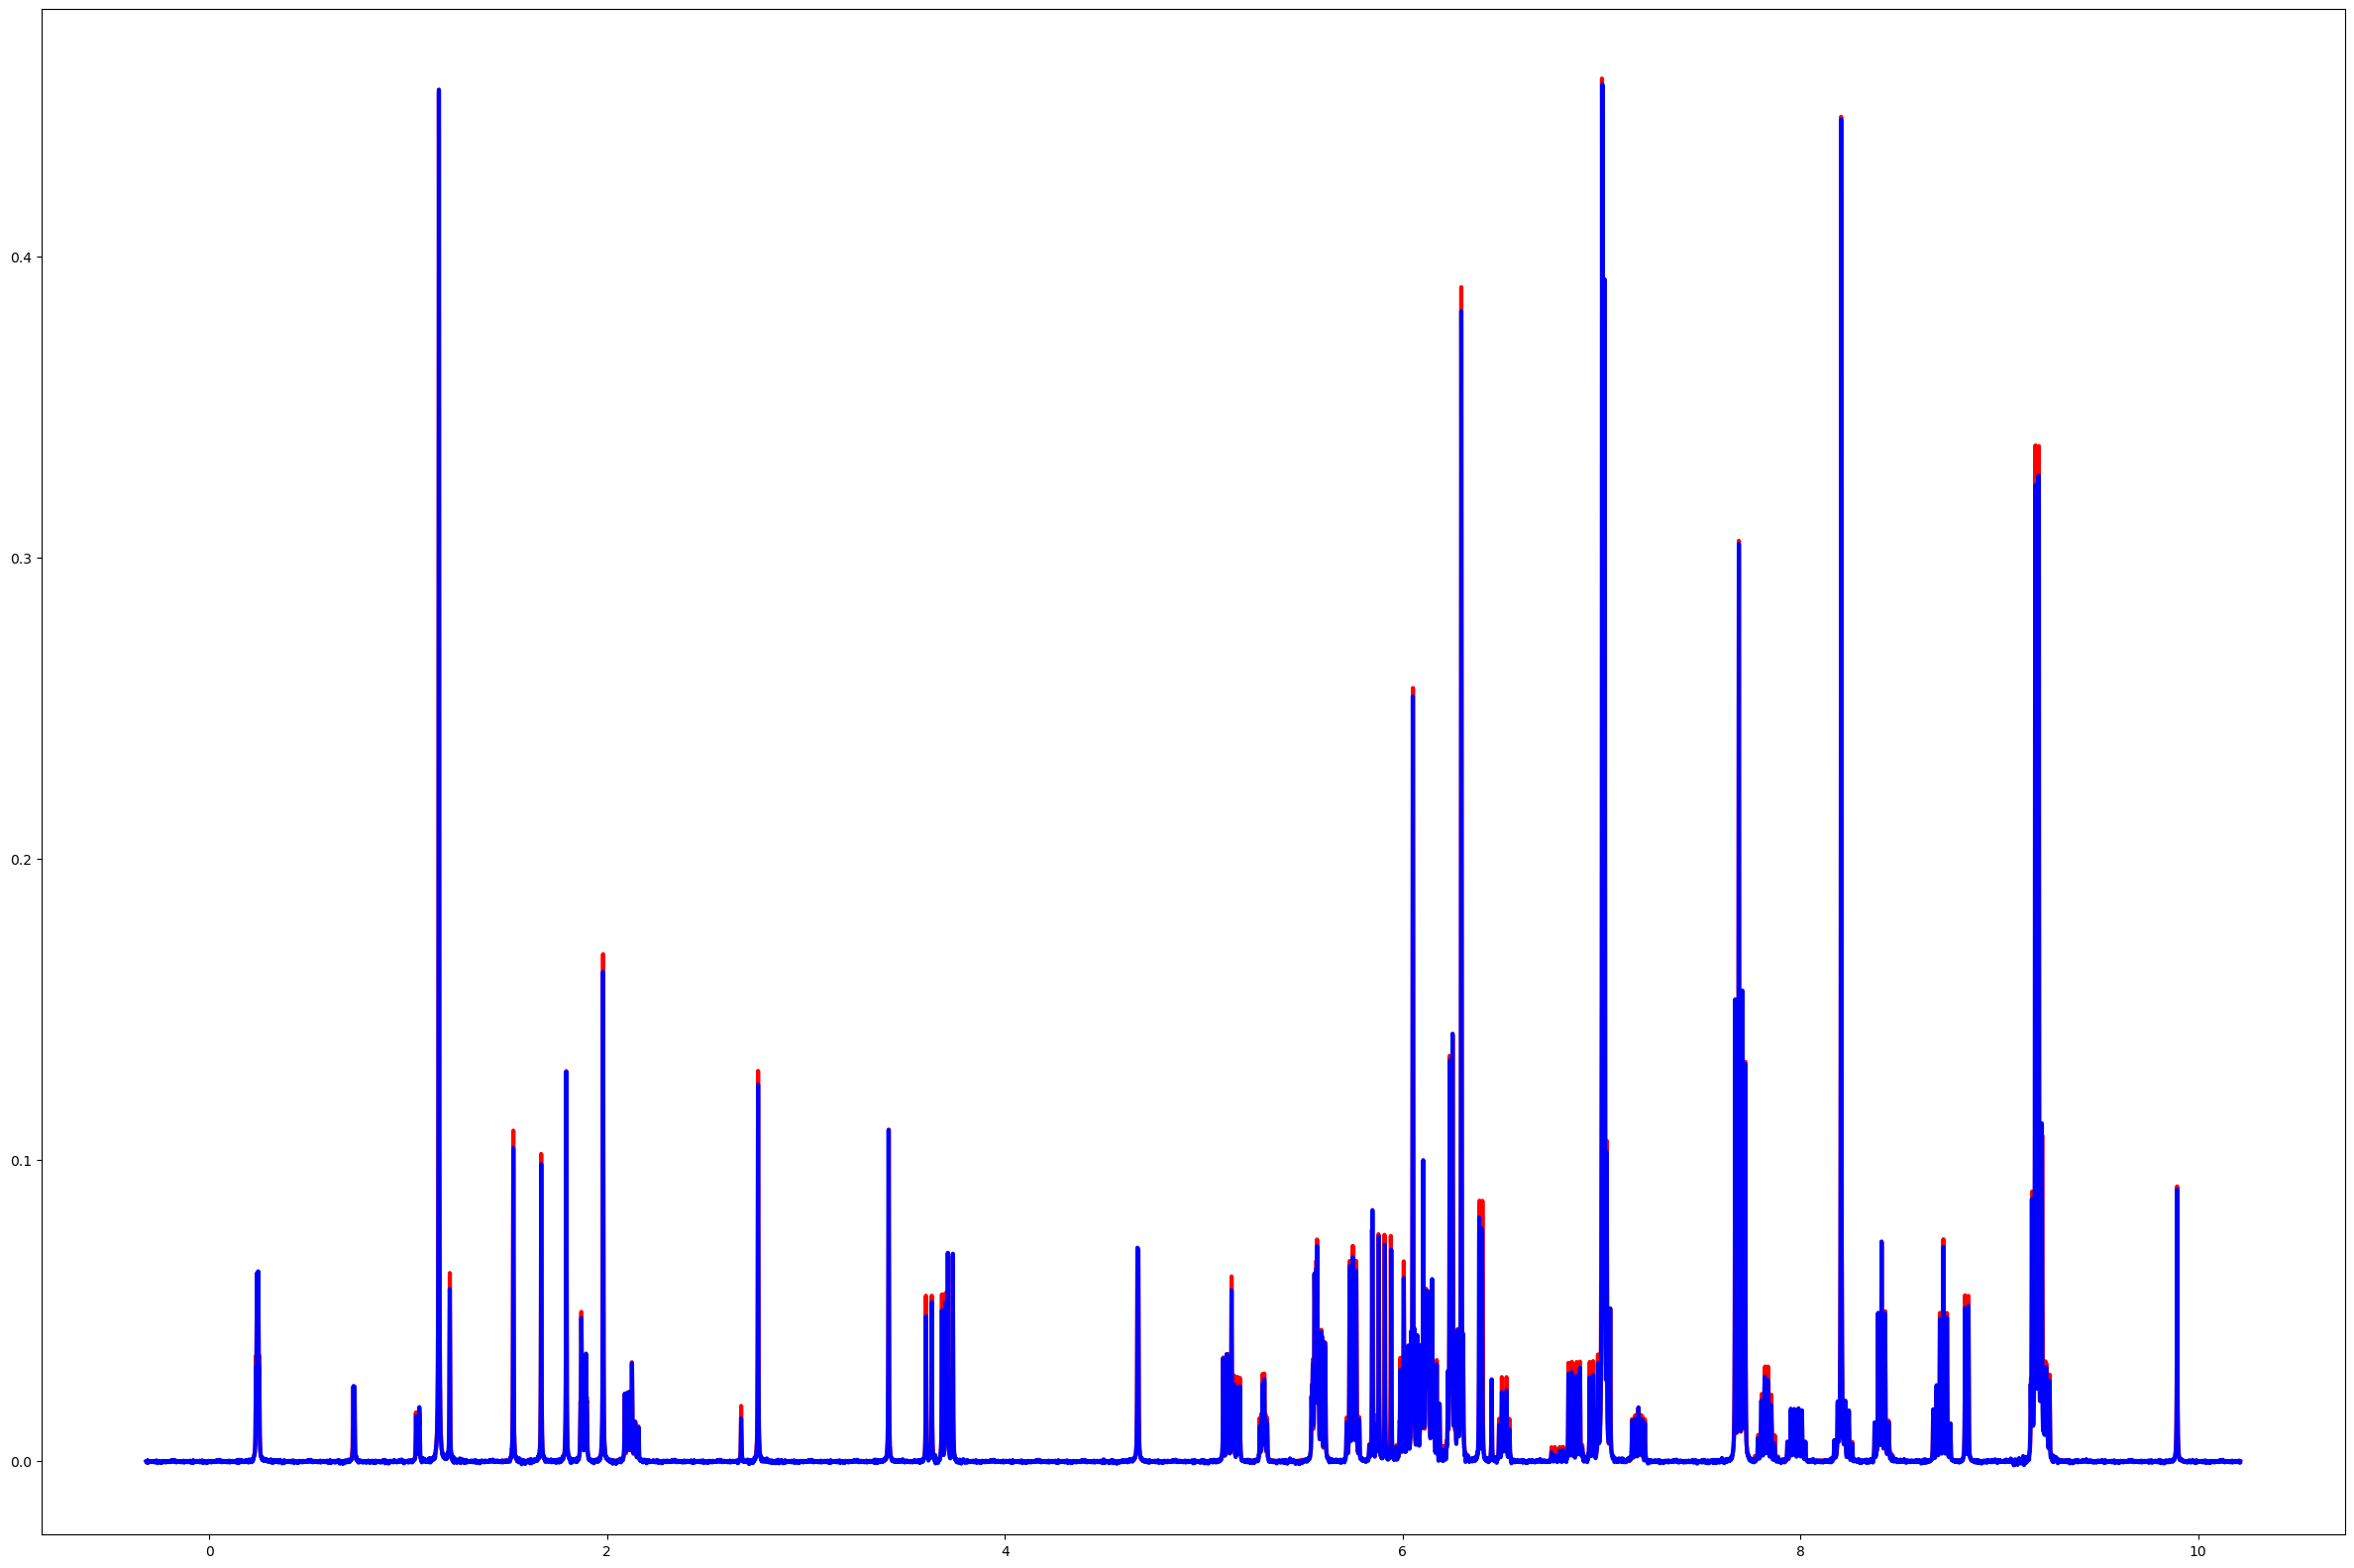

tensor(7.3533e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:

LF = spectraVal100[:100]
GT = spectraVal400[:100]
criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF).cpu().detach().numpy()

for i in np.arange(10):
    plt.plot(np.flip(ppm), GT[i].cpu().detach().numpy(), color = 'red', linewidth = 3)
    plt.plot(np.flip(ppm), outputs[i], color = 'blue', linewidth = 3)
    plt.show()
    print(criterion(model(LF)[i], GT[i]))

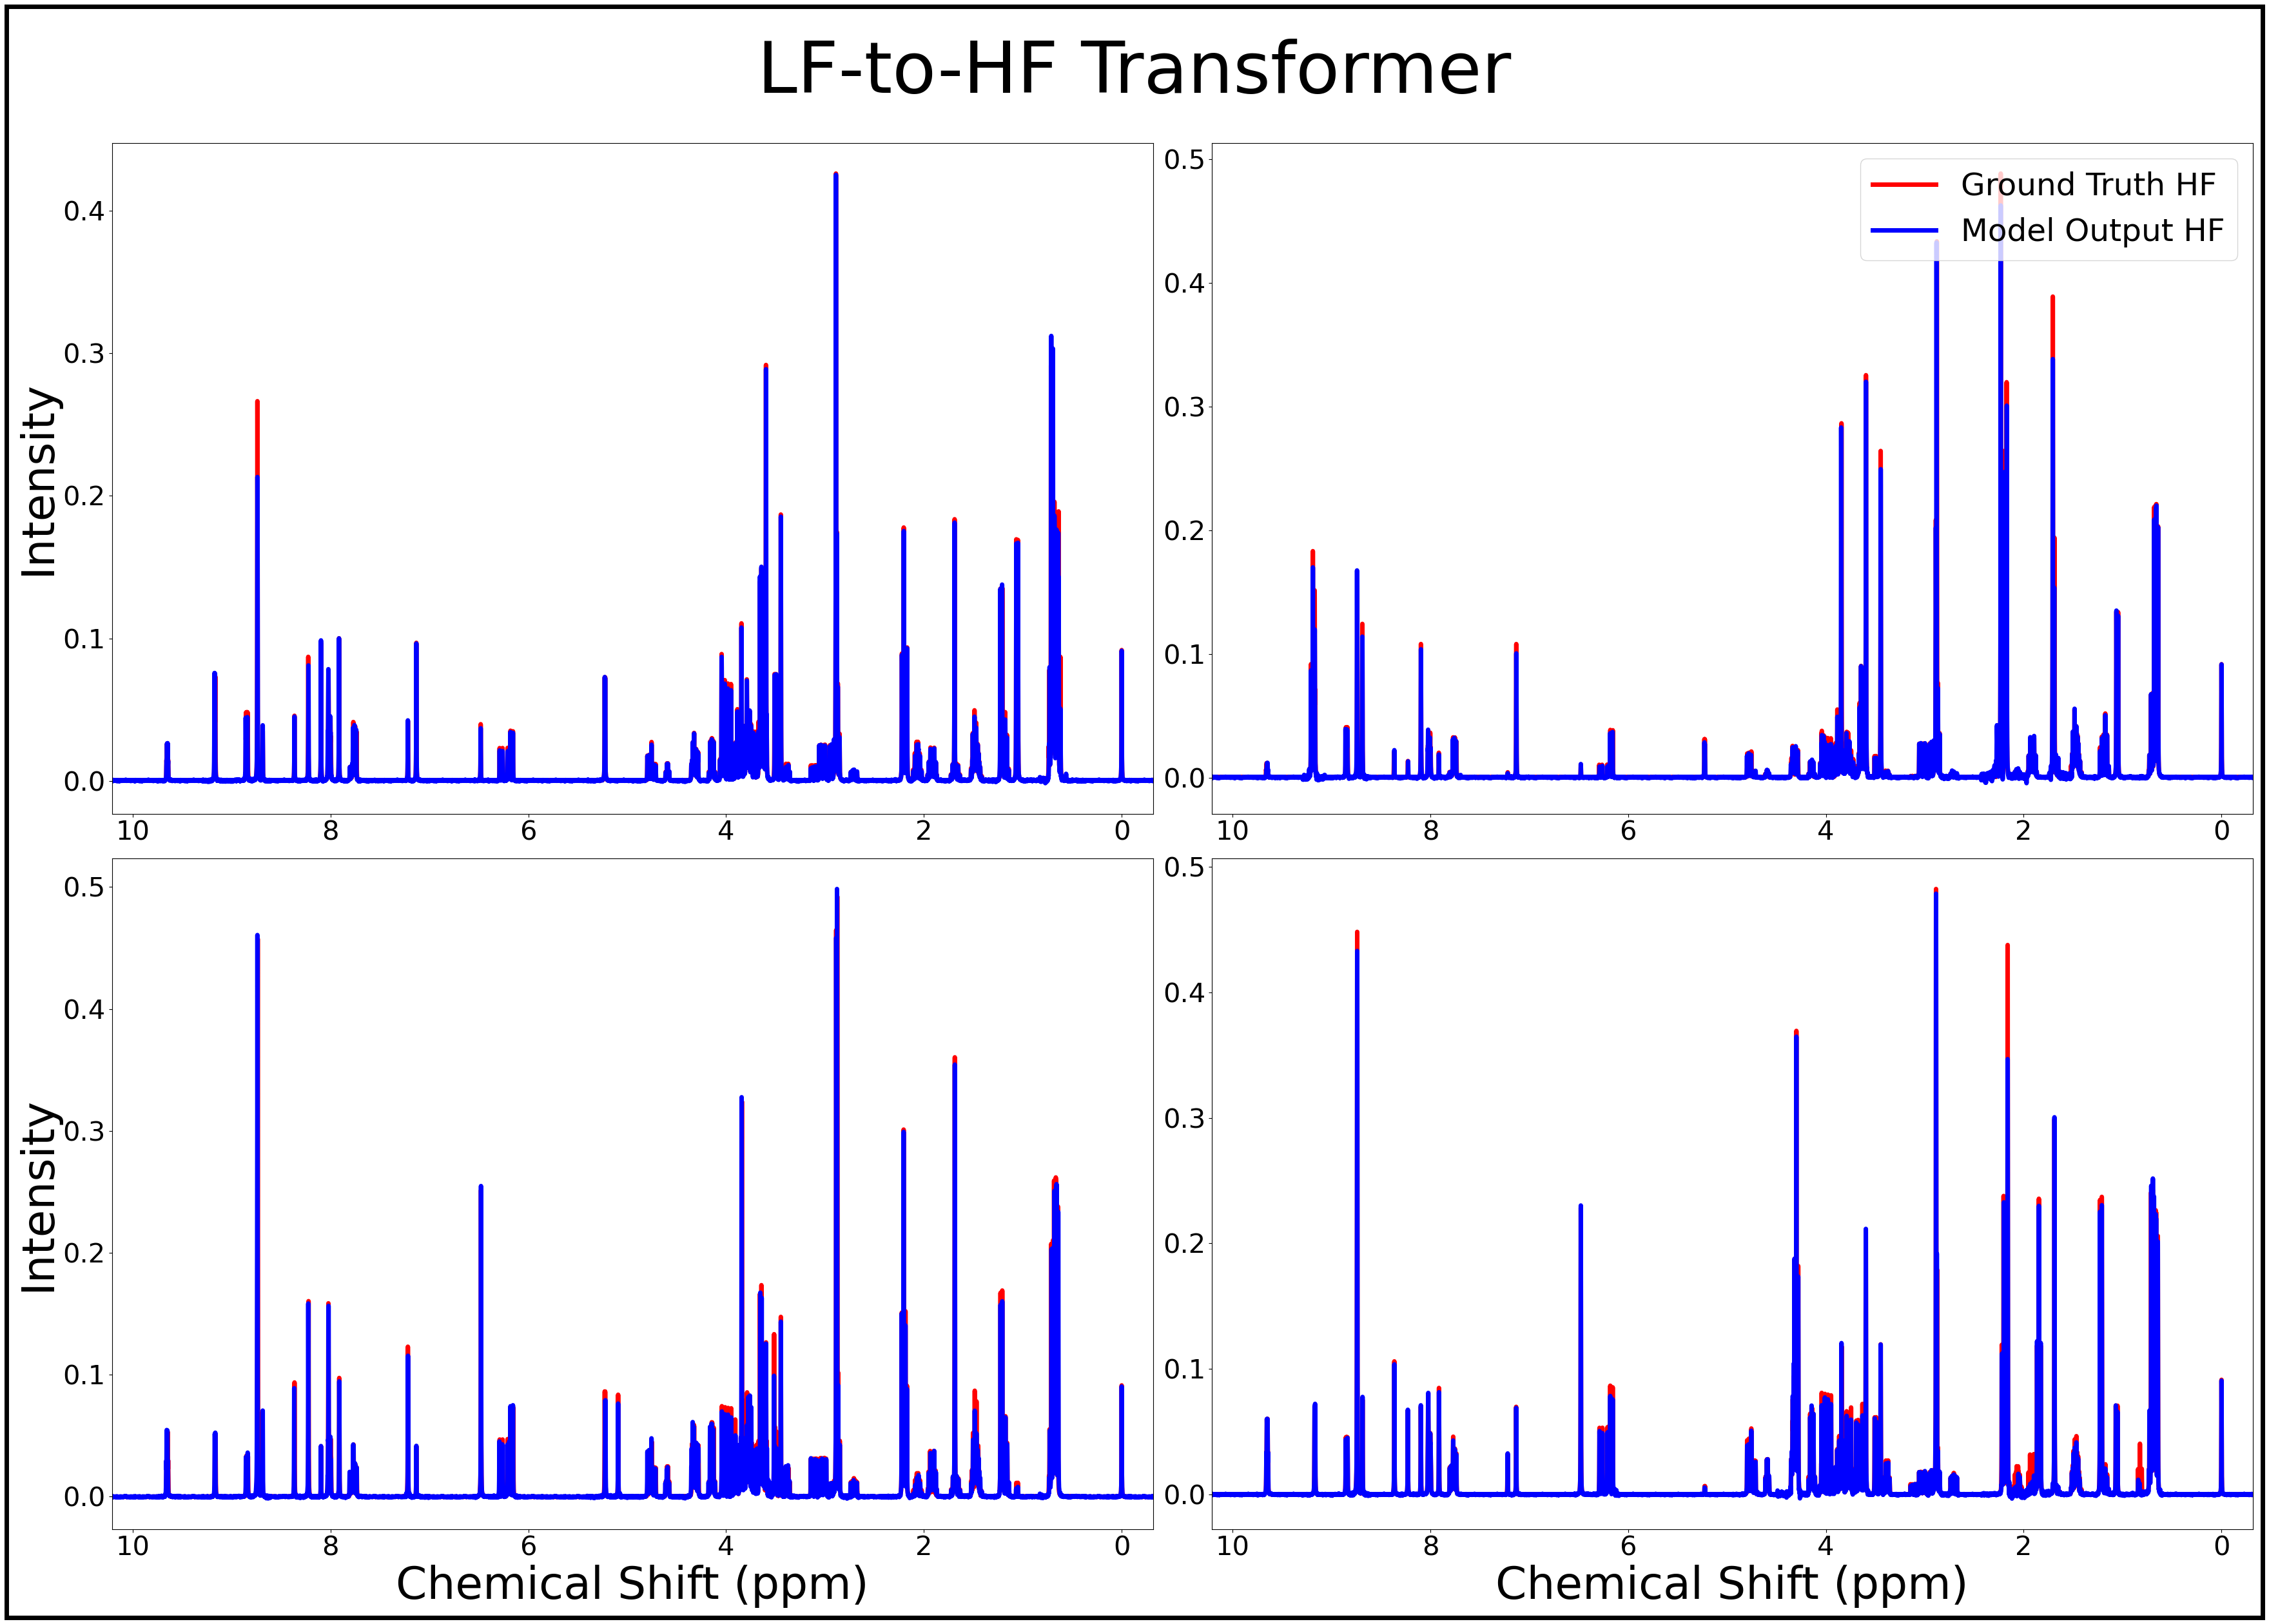

In [10]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')


# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF).cpu().detach().numpy()

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i], color='blue', linewidth=5, label='Model Output HF')
    ax.set_xlim(ppm[0], ppm[-1])


    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('LF-to-HF Transformer', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('LF-to-HF_Transformer.png', dpi=600, bbox_inches='tight')

plt.show()

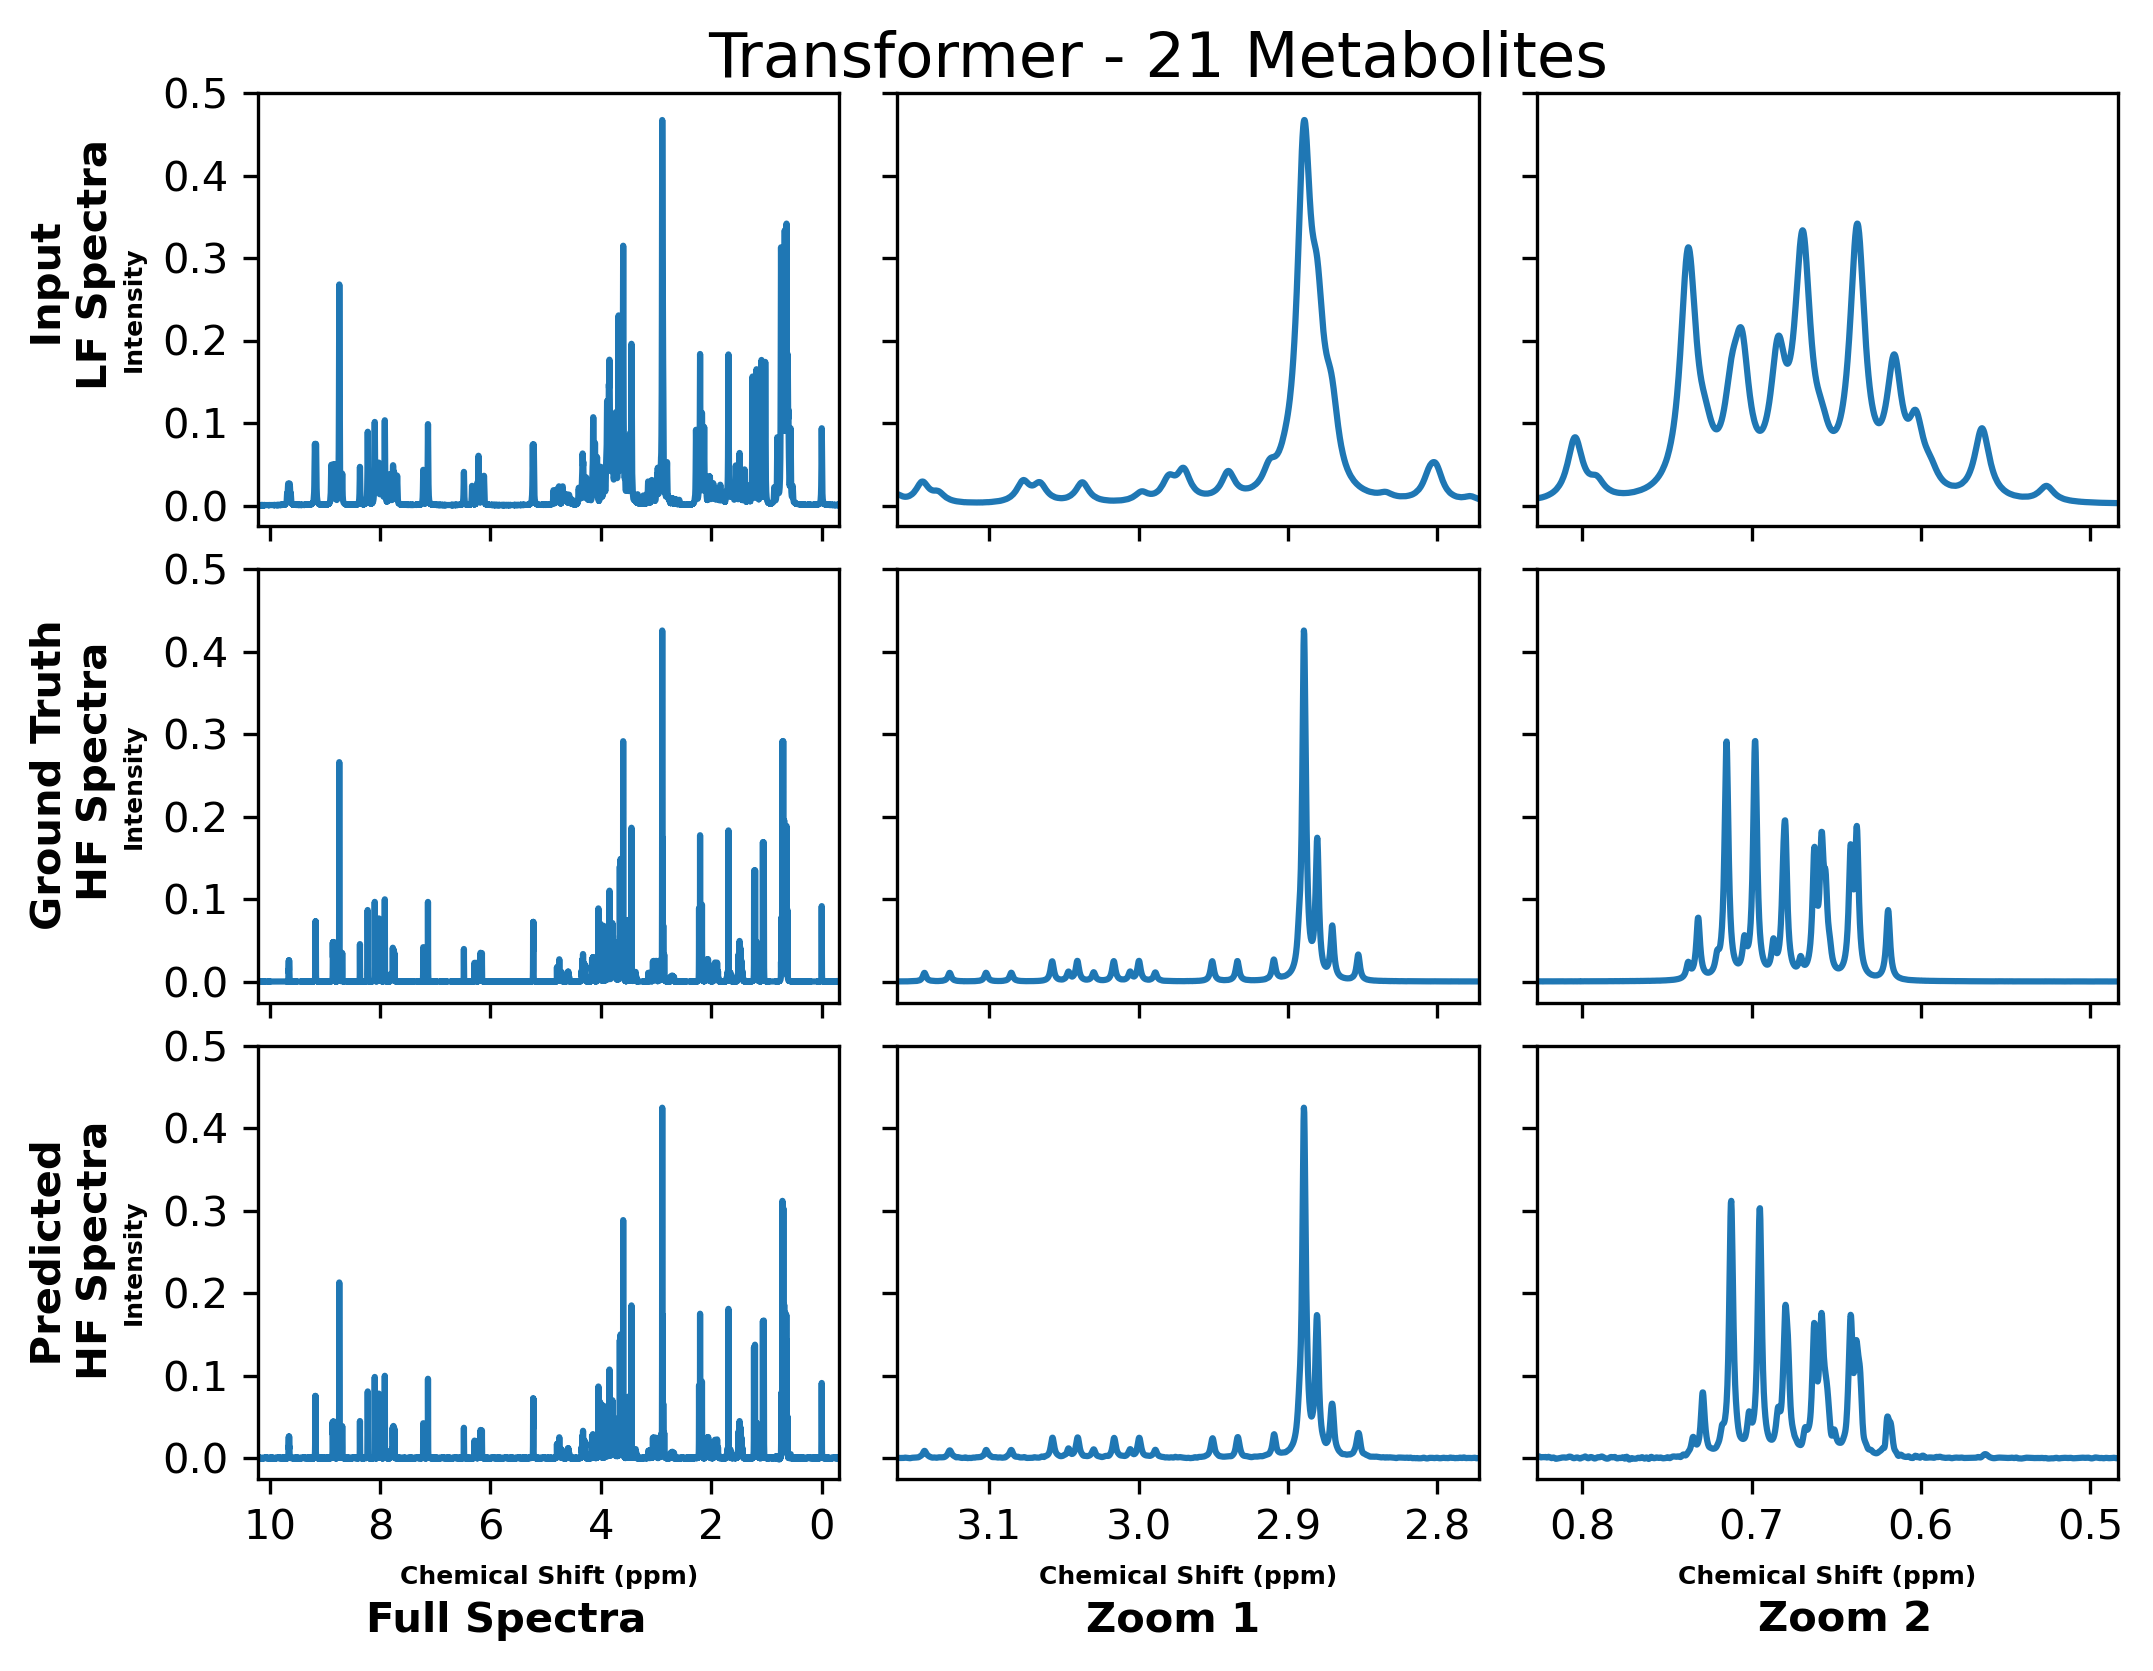

In [10]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')

# Get predicted data from the model
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal space

# Plotting data for each subplot
axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0], ppm[-1])
axs[0, 0].set_ylim(-0.025, 0.5)
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800], ppm[32500])
axs[0, 1].set_ylim(-0.025, 0.5)
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000], ppm[42500])
axs[0, 2].set_ylim(-0.025, 0.5)

axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0], ppm[-1])
axs[1, 0].set_ylim(-0.025, 0.5)
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800], ppm[32500])
axs[1, 1].set_ylim(-0.025, 0.5)
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000], ppm[42500])
axs[1, 2].set_ylim(-0.025, 0.5)

axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[0], ppm[-1])
axs[2, 0].set_ylim(-0.025, 0.5)
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[30800], ppm[32500])
axs[2, 1].set_ylim(-0.025, 0.5)
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41000], ppm[42500])
axs[2, 2].set_ylim(-0.025, 0.5)


# Add main titles inside each subplot
count = -1
plt.rcParams.update({'font.size': 7})
xlabels = ["Chemical Shift (ppm)", "Chemical Shift (ppm)", "Chemical Shift (ppm)"] * 3
ylabels = ["Intensity", "Intensity", "Intensity"] * 3

for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count], fontweight='bold', fontsize=6)
    ax.set_ylabel(ylabels[count], fontweight='bold', fontsize=6)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    # Add an overall title at the top
fig.suptitle('Transformer - 21 Metabolites', fontsize=15, x=0.5, y=0.915)

# Add subtitles as the main titles for each row and column
fig.text(0.03, 0.72, "   Input \nLF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.42, "Ground Truth \n  HF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.17, " Predicted \nHF Spectra", rotation='vertical', fontweight='bold', fontsize=10)

fig.text(0.17, 0.02, "Full Spectra", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.47, 0.02, "Zoom 1", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.75, 0.02, "Zoom 2", va='bottom', fontweight='bold', fontsize=10)

plt.savefig('Transformer_Visual.png', dpi=600, bbox_inches='tight')

plt.show()


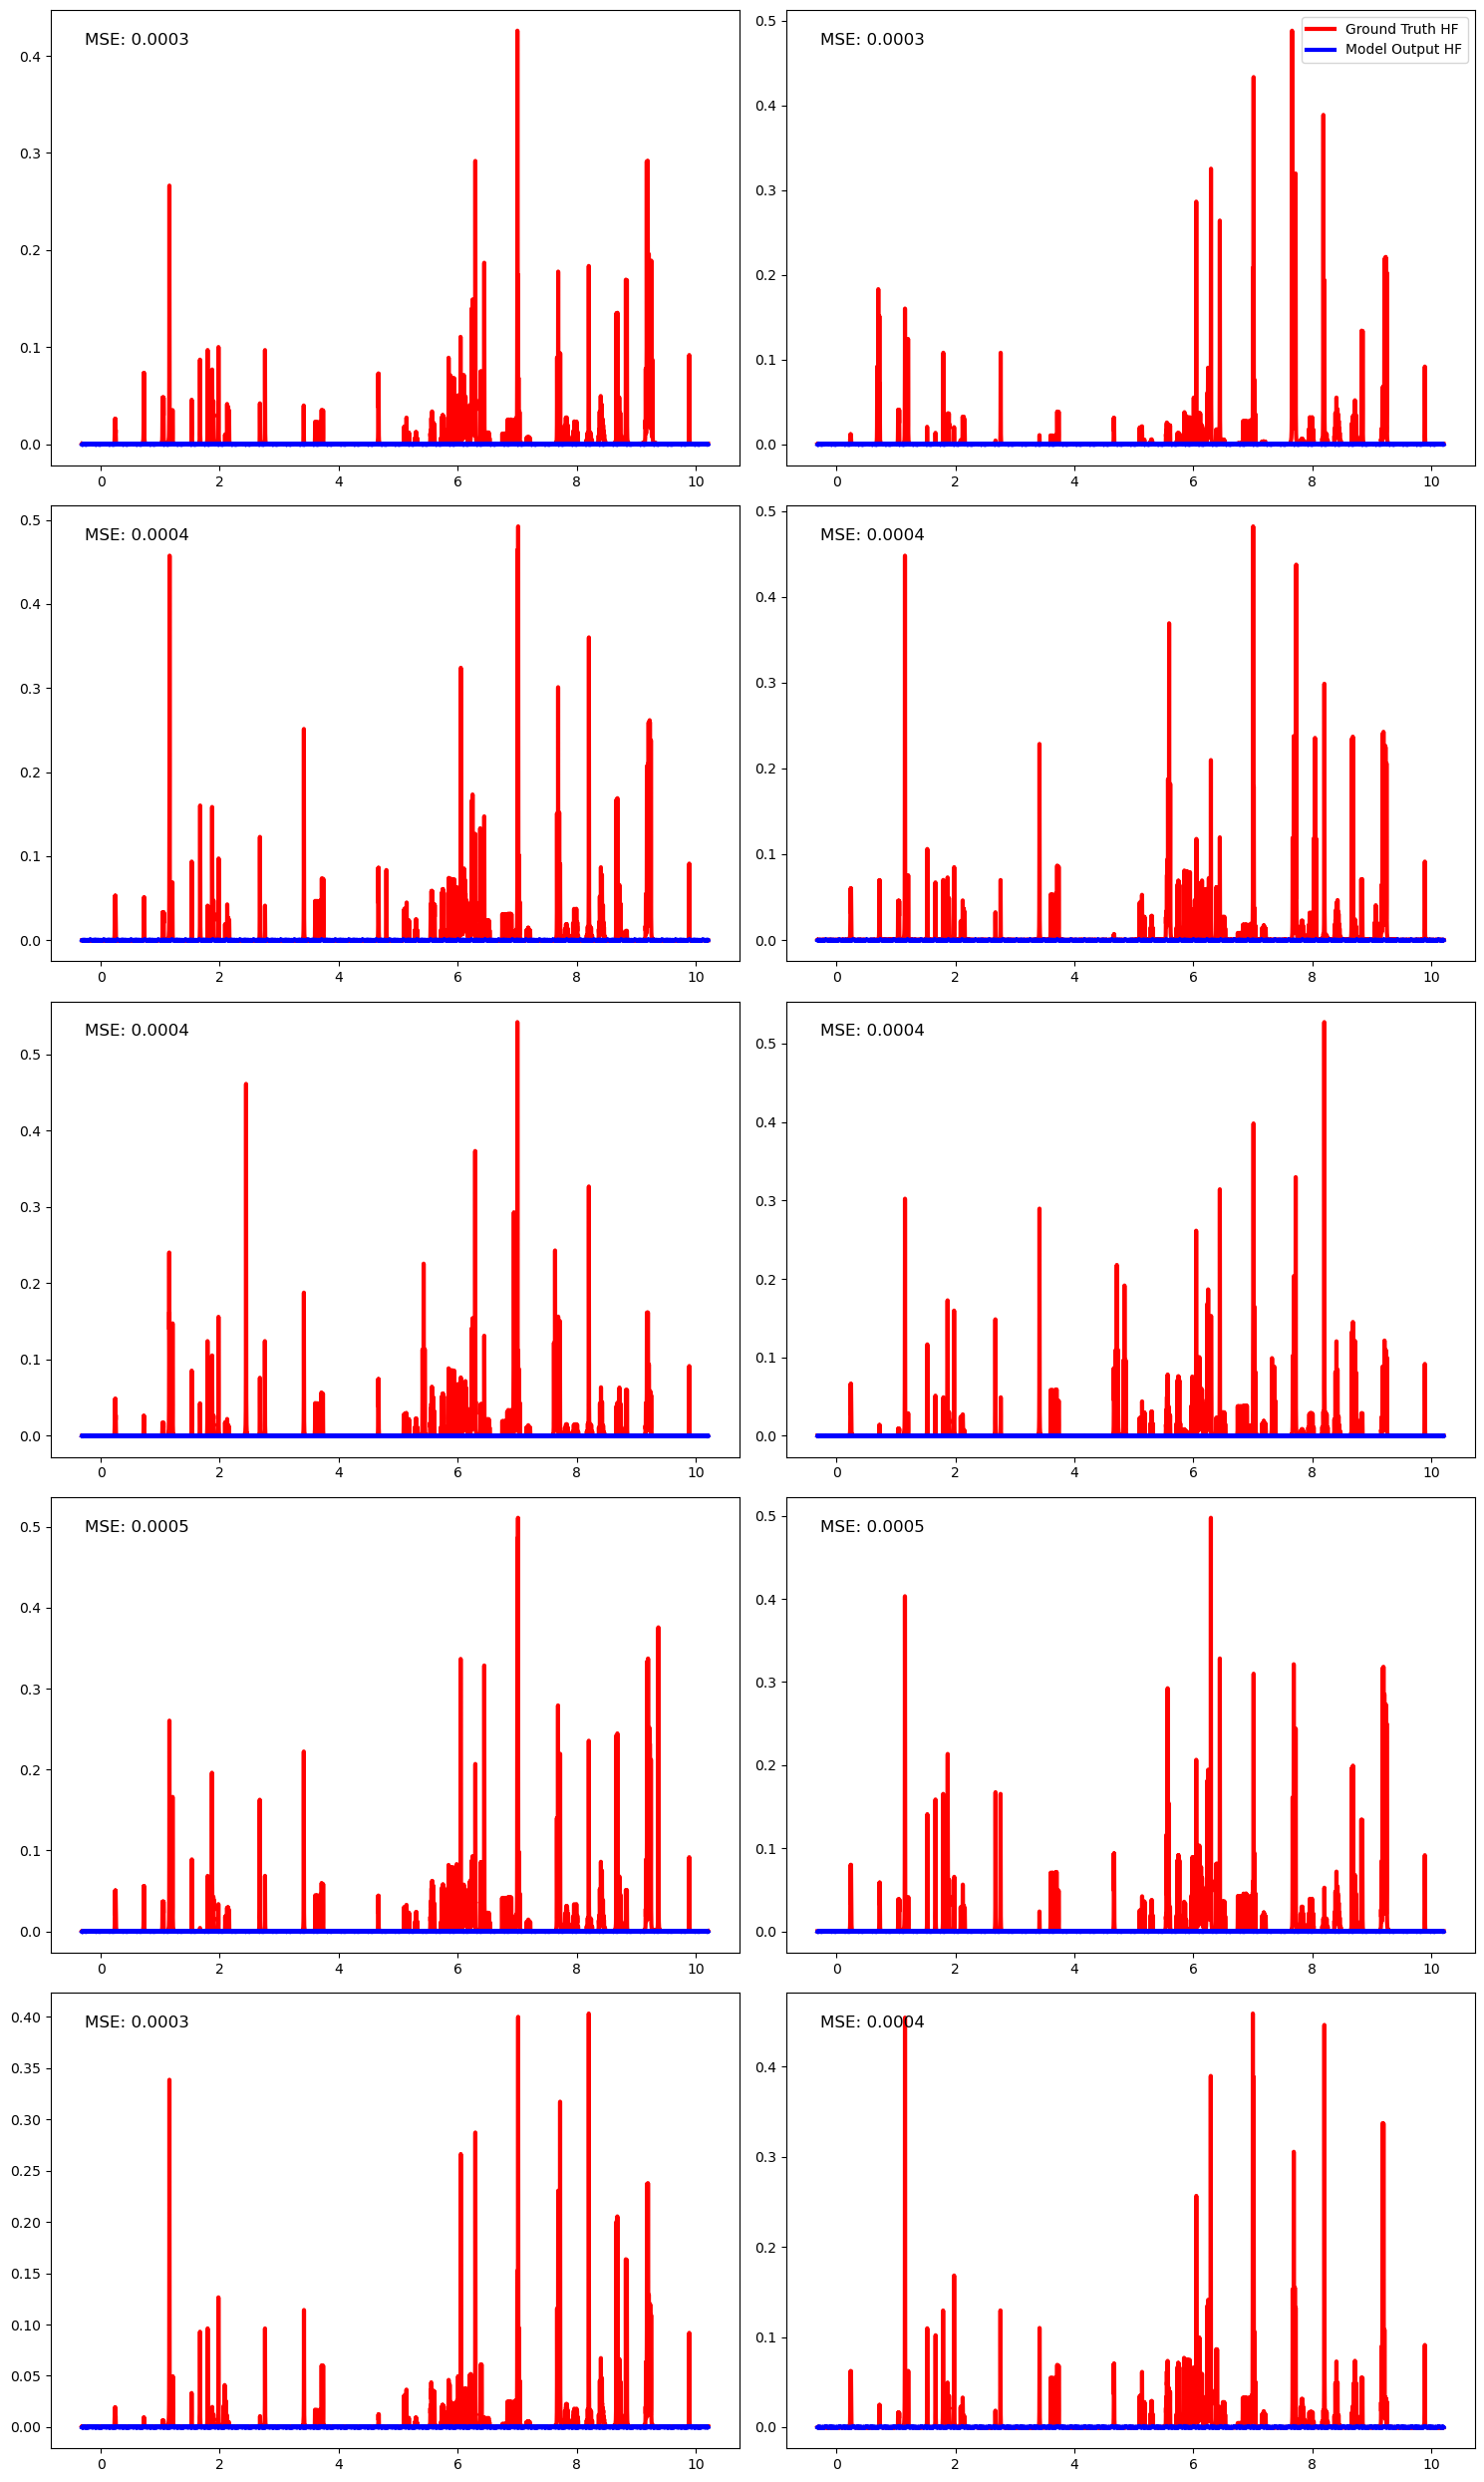

In [32]:
# Assuming GT, model, and criterion are already defined as in your code

zeros = torch.tensor(np.zeros((100,46000))).float().to(device)

# Create a figure with 2 columns and 5 rows
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(zeros).cpu().detach().numpy()

for i in range(10):
    ax = axes[i]
    ax.plot(np.flip(ppm), GT[i].cpu().detach().numpy(), color='red', linewidth=3, label='Ground Truth HF')
    ax.plot(np.flip(ppm), outputs[i], color='blue', linewidth=3, label='Model Output HF')
    
    # Calculate MSE
    mse = criterion(model(zeros)[i], GT[i]).item()
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

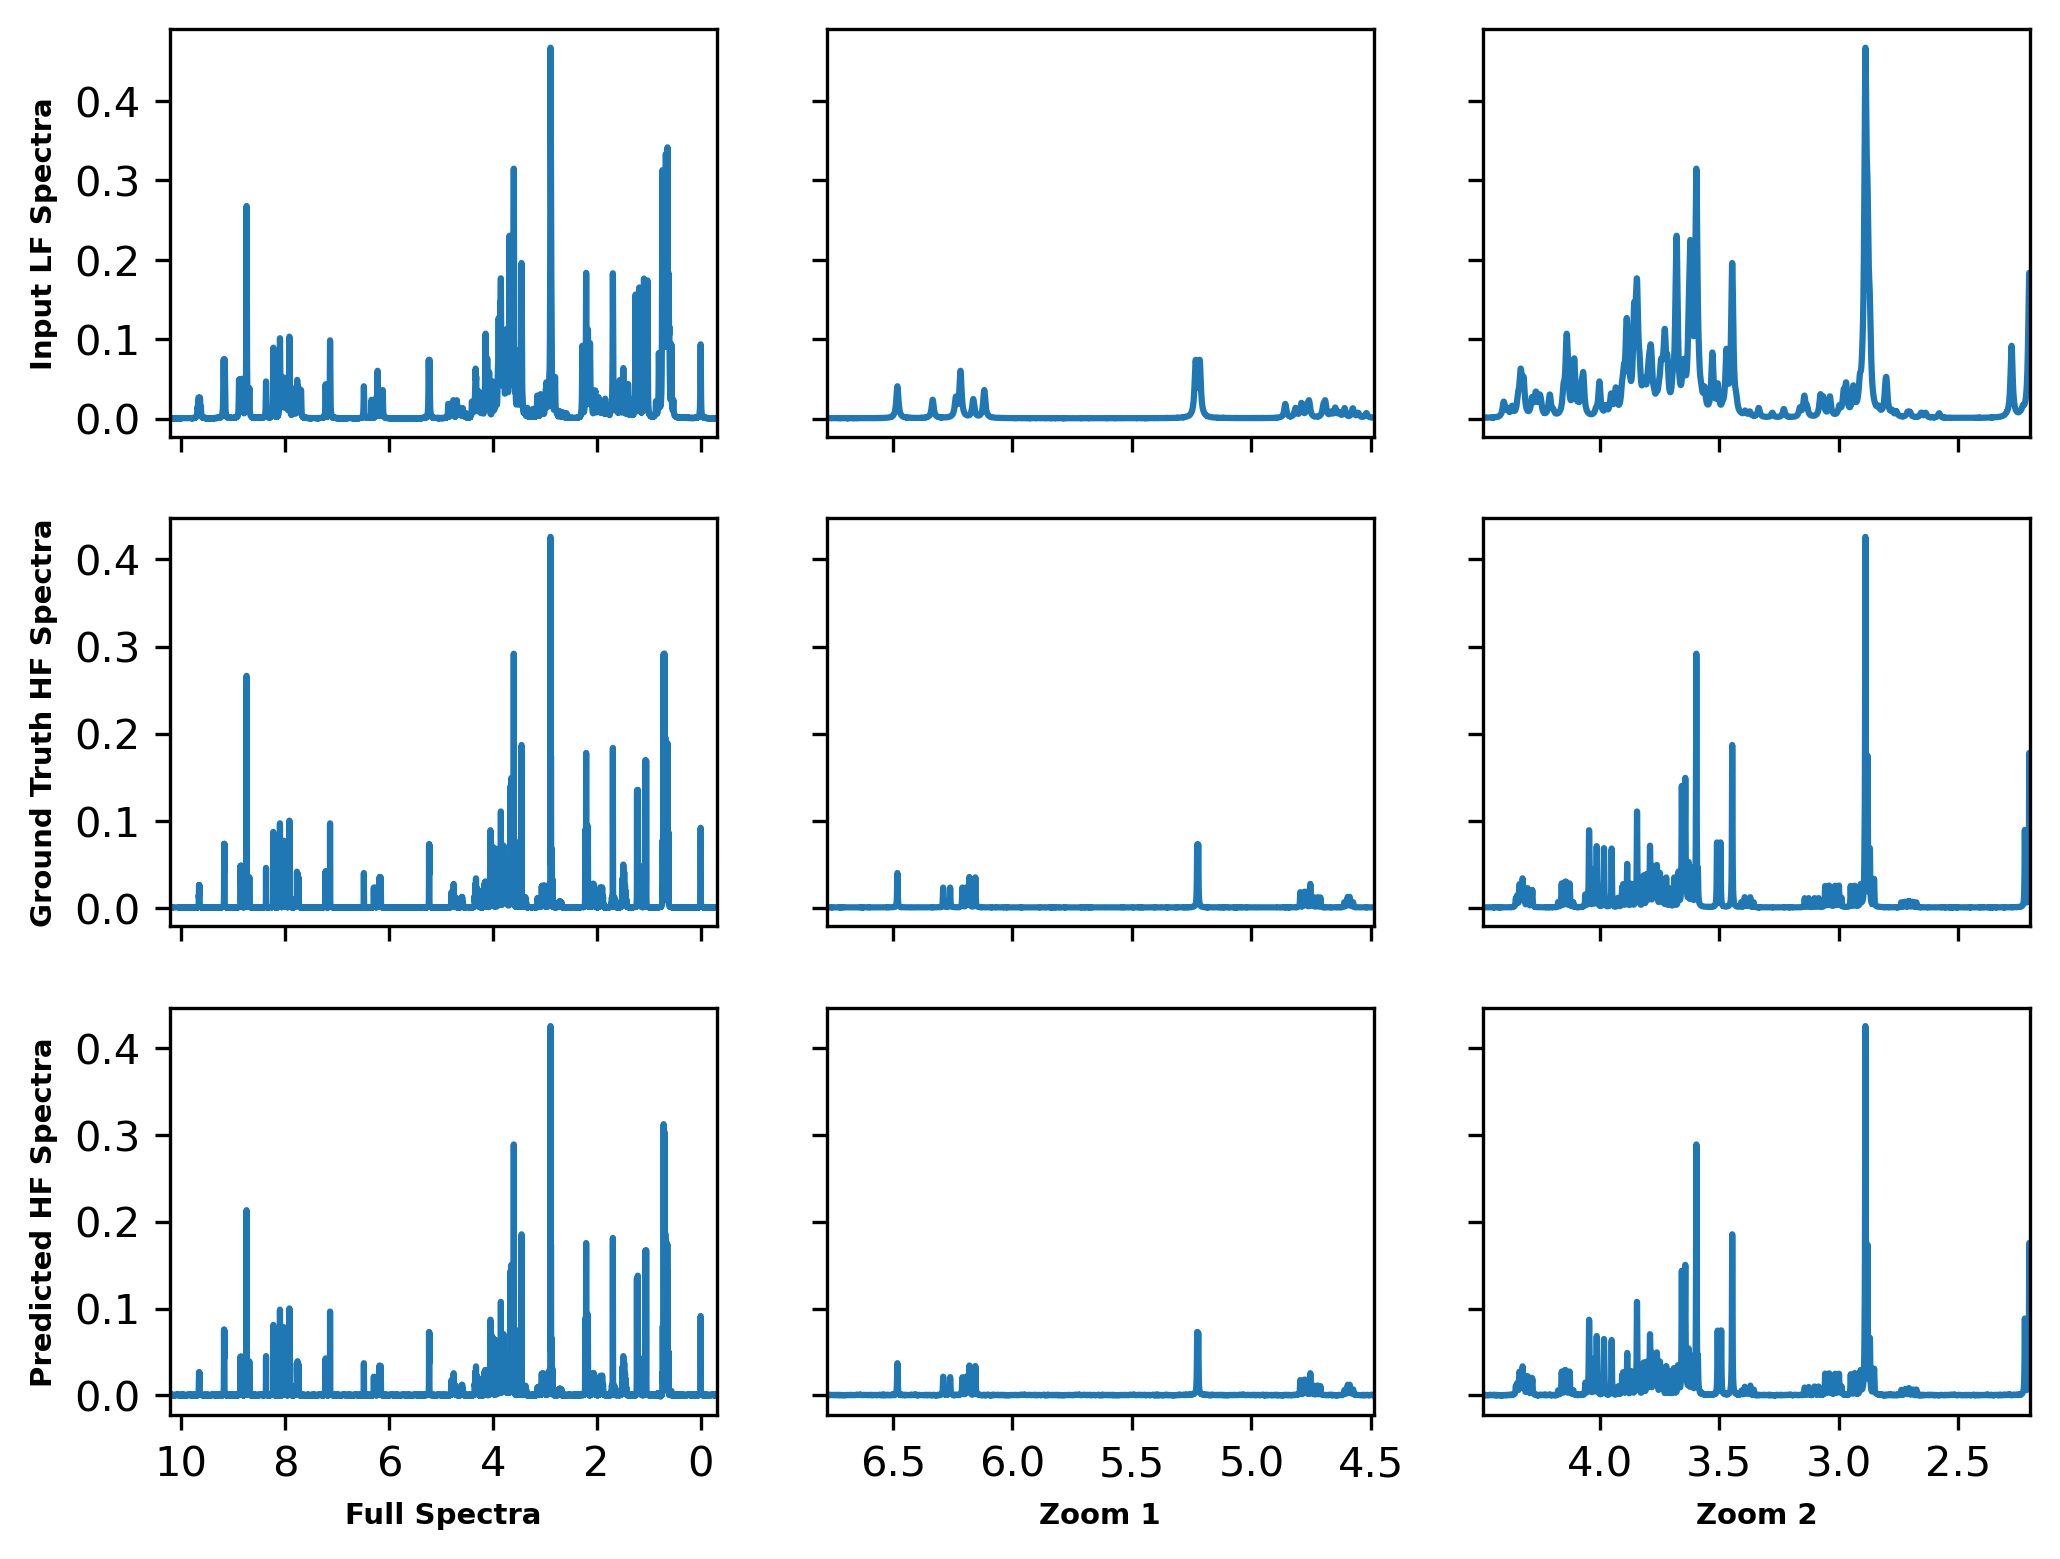

In [12]:
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0],ppm[-1])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[15000],ppm[25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[25000],ppm[35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0],ppm[-1])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[15000],ppm[25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[25000],ppm[35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[0],ppm[-1])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[15000],ppm[25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[25000],ppm[35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Full Spectra","Zoom 1","Zoom 2"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

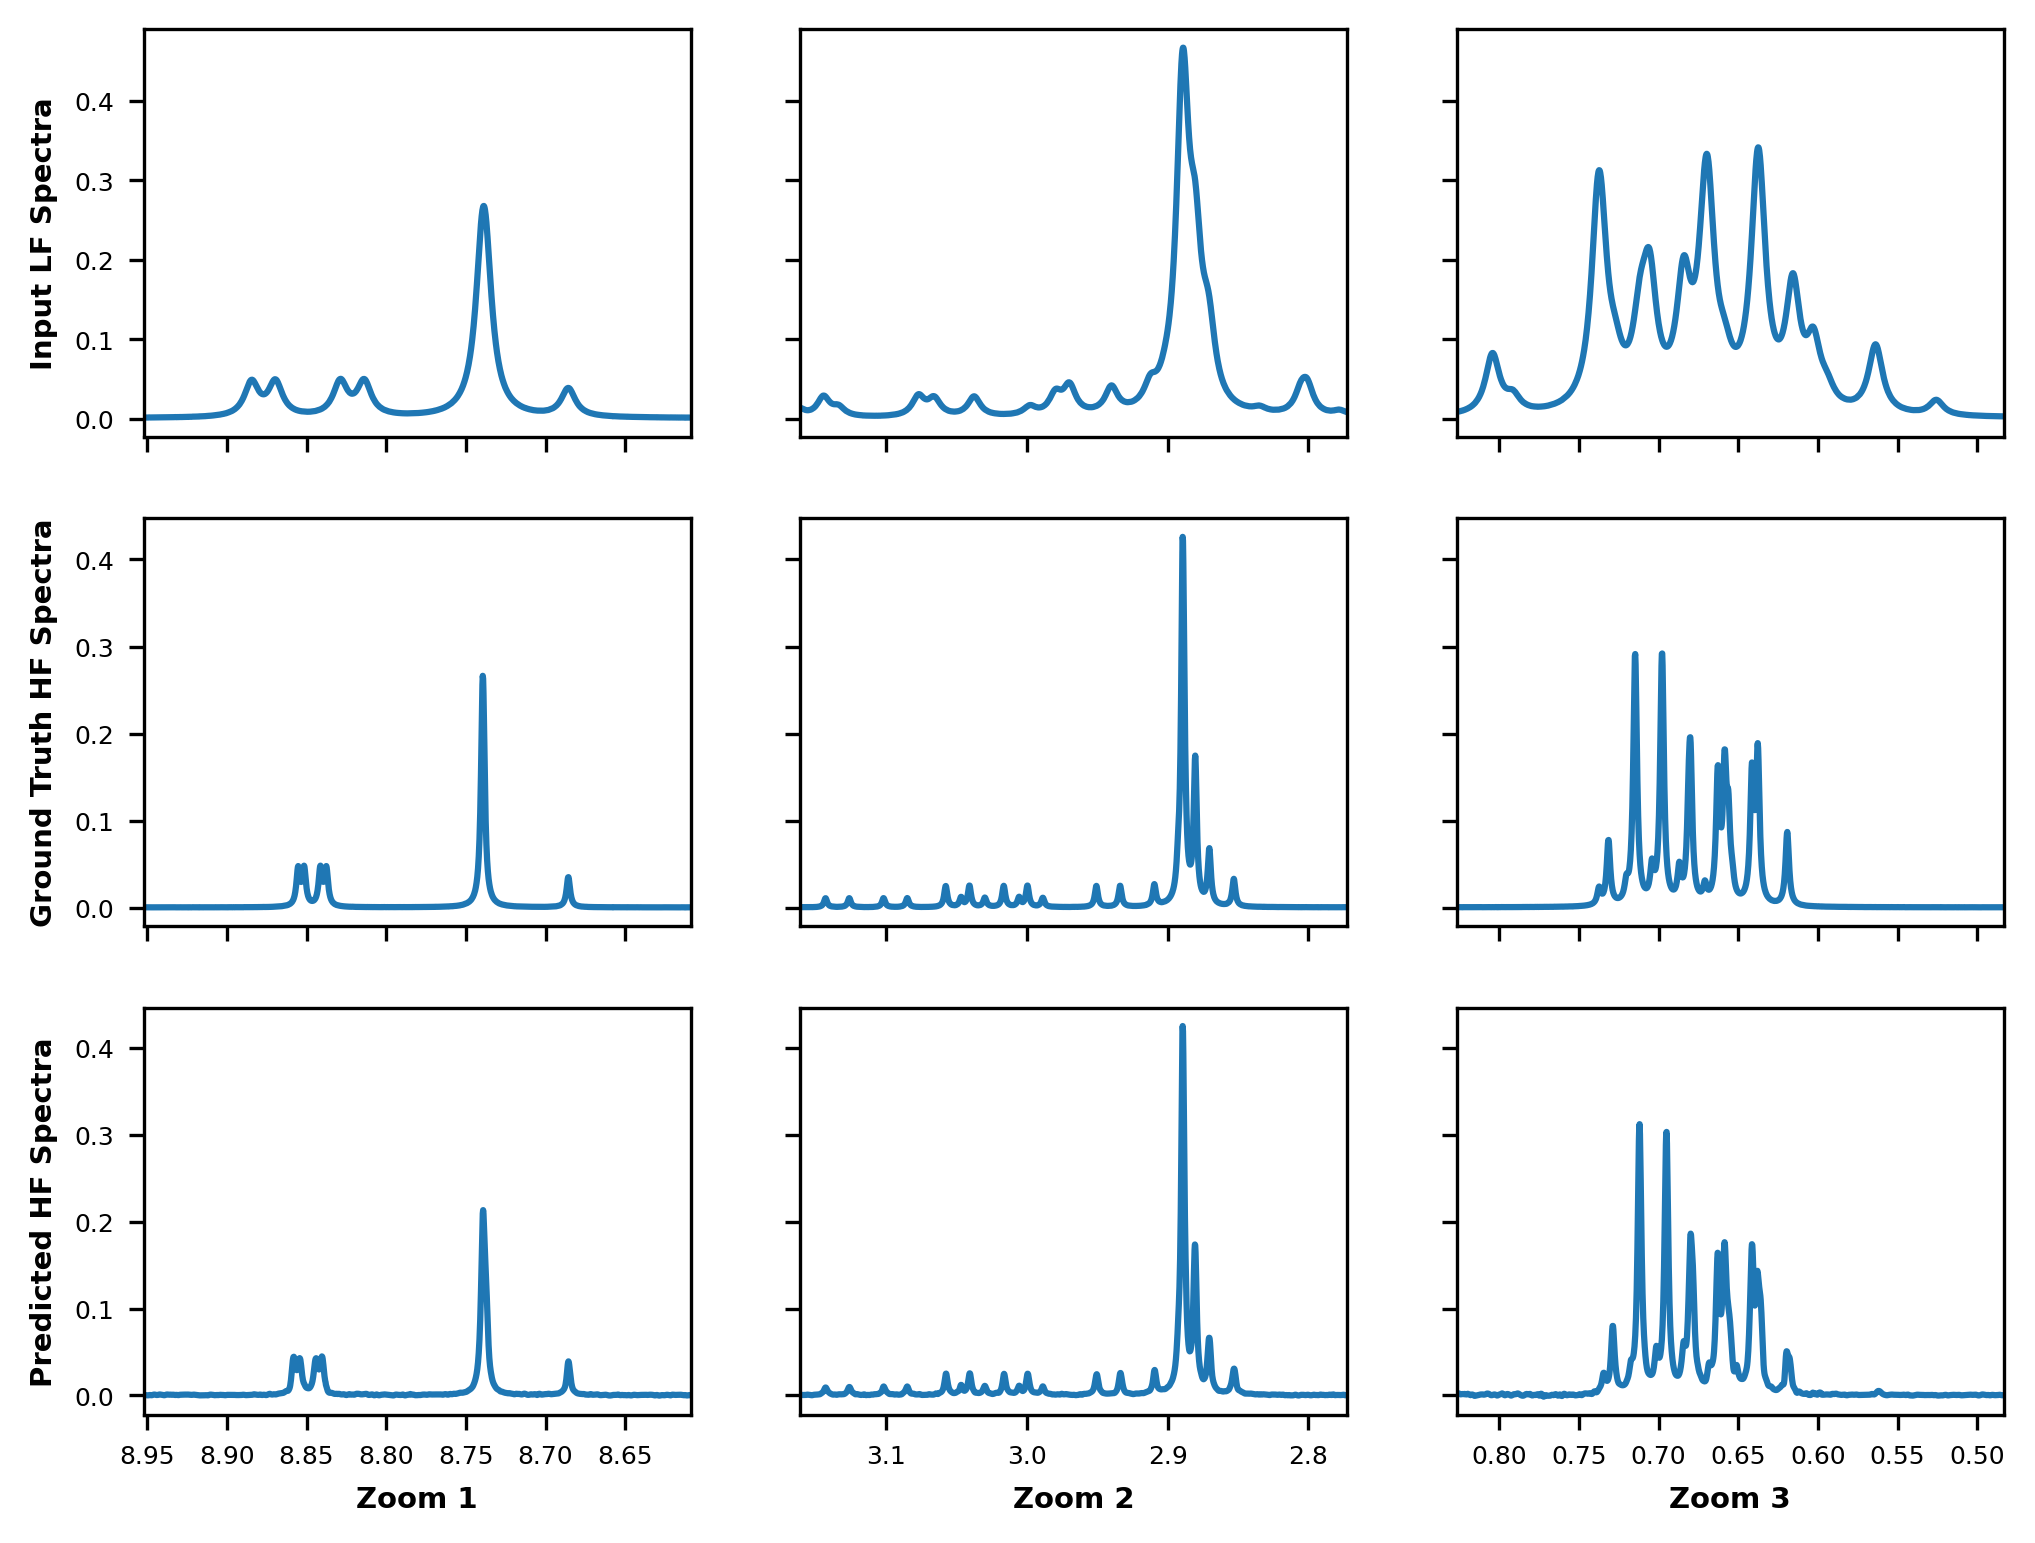

In [13]:
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5500],ppm[7000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800],ppm[32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000],ppm[42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5500],ppm[7000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800],ppm[32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000],ppm[42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[5500],ppm[7000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[30800],ppm[32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41000],ppm[42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

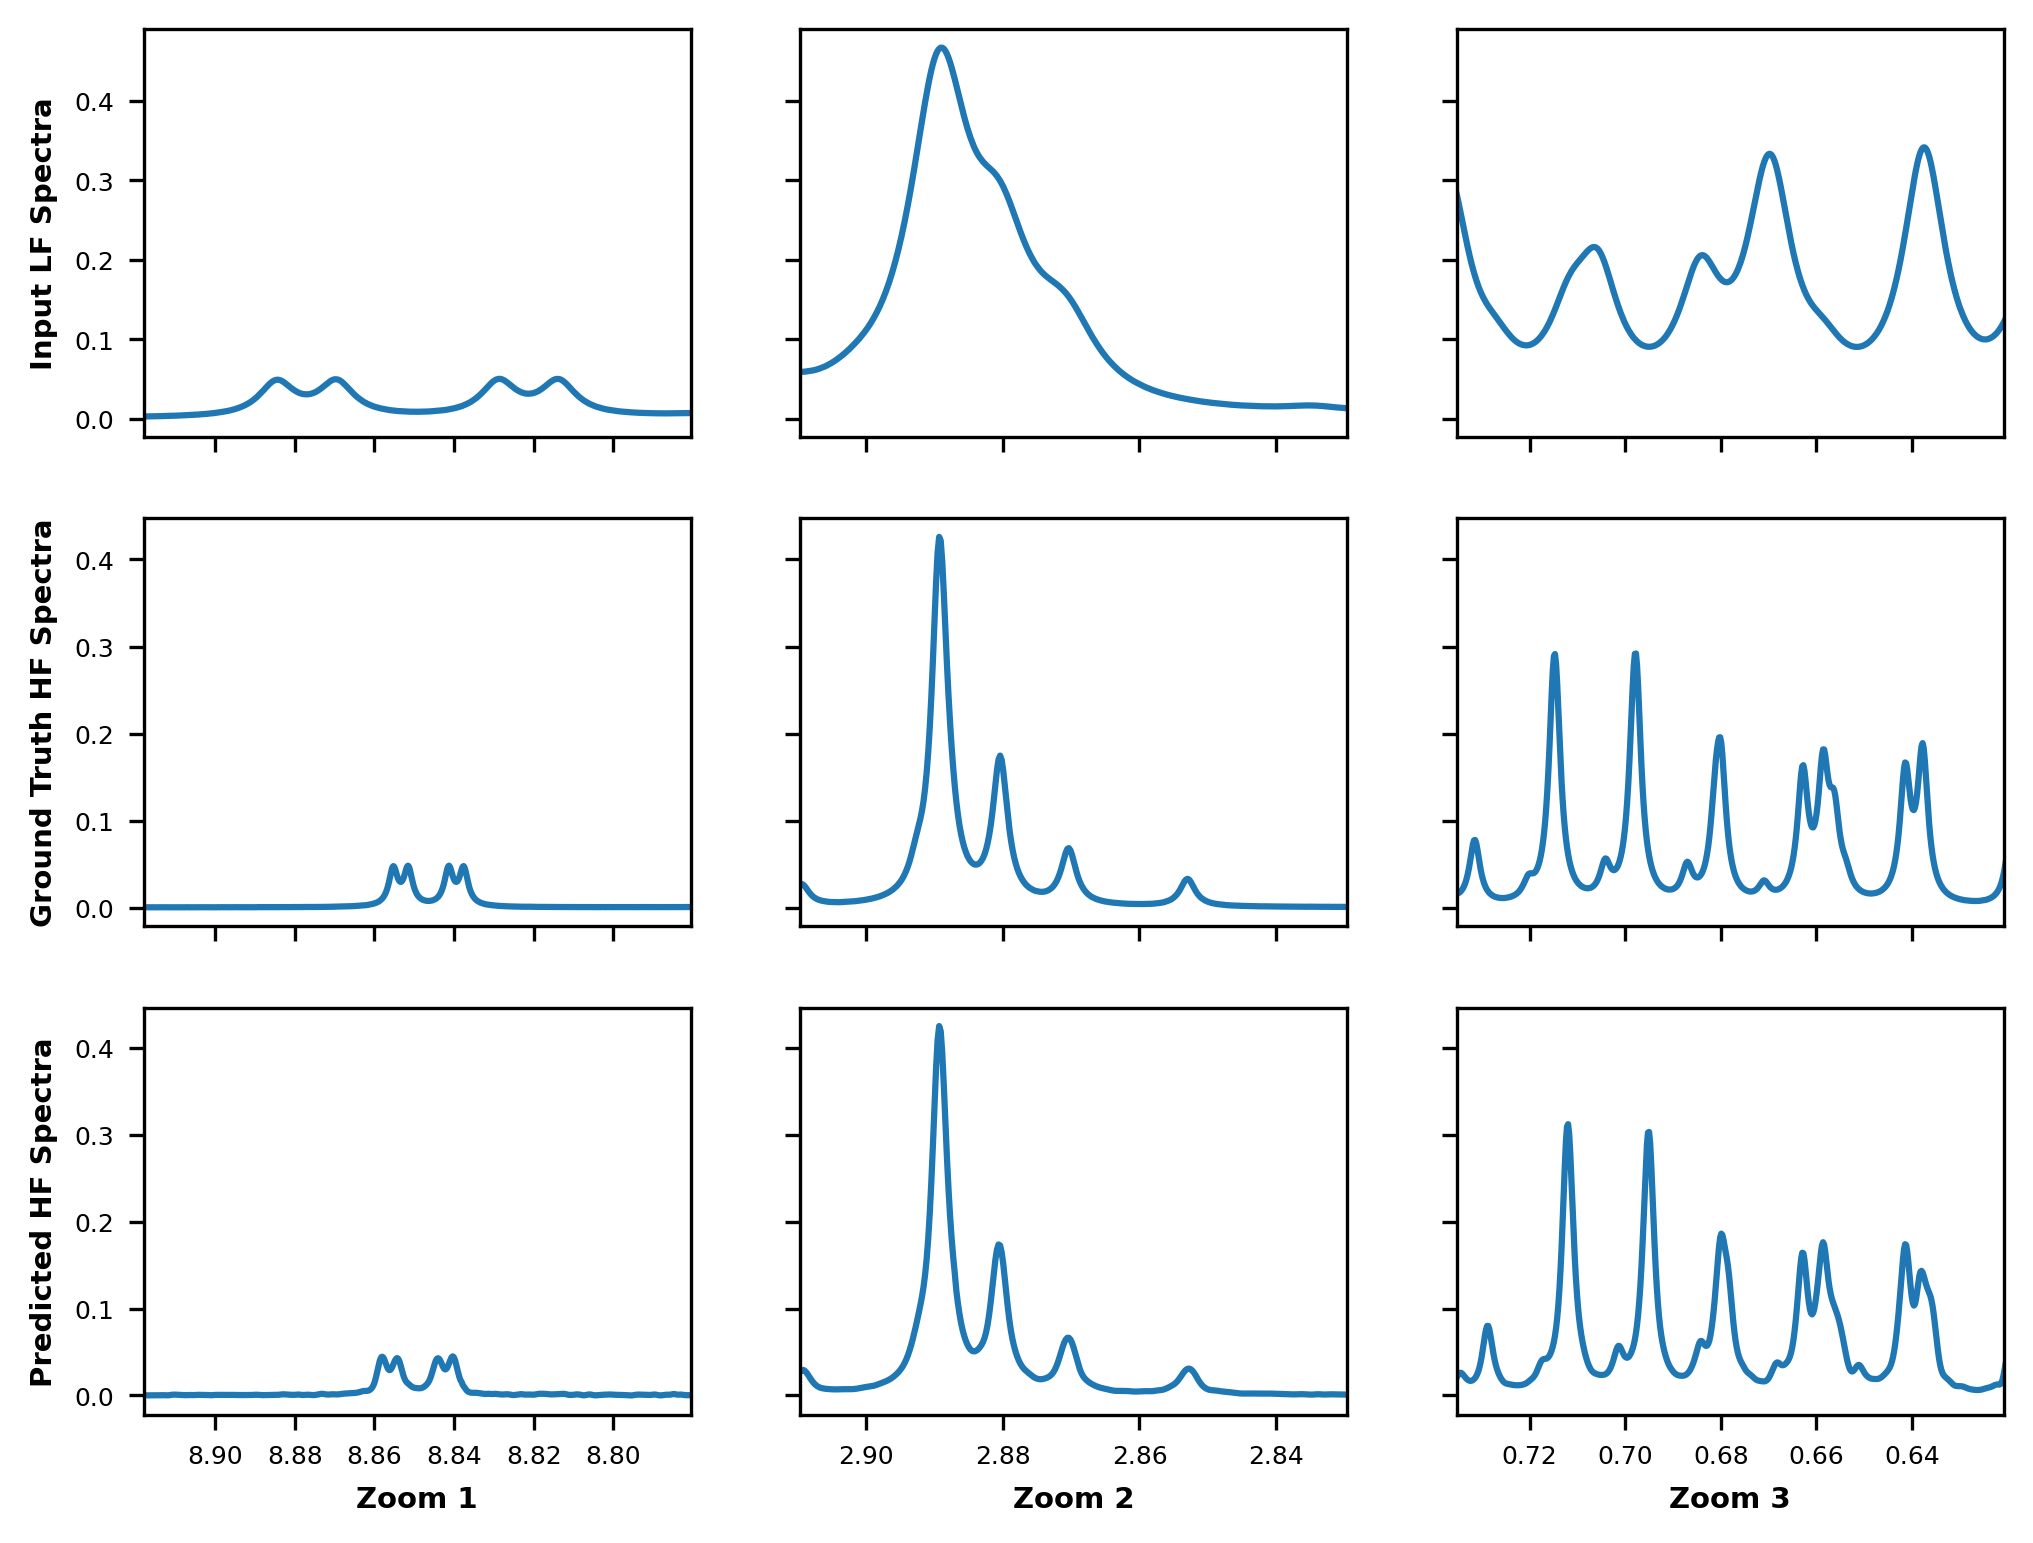

In [14]:
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5650],ppm[6250])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[31900],ppm[32250])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41400],ppm[41900])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5650],ppm[6250])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[31900],ppm[32250])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41400],ppm[41900])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[5650],ppm[6250])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[31900],ppm[32250])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41400],ppm[41900])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

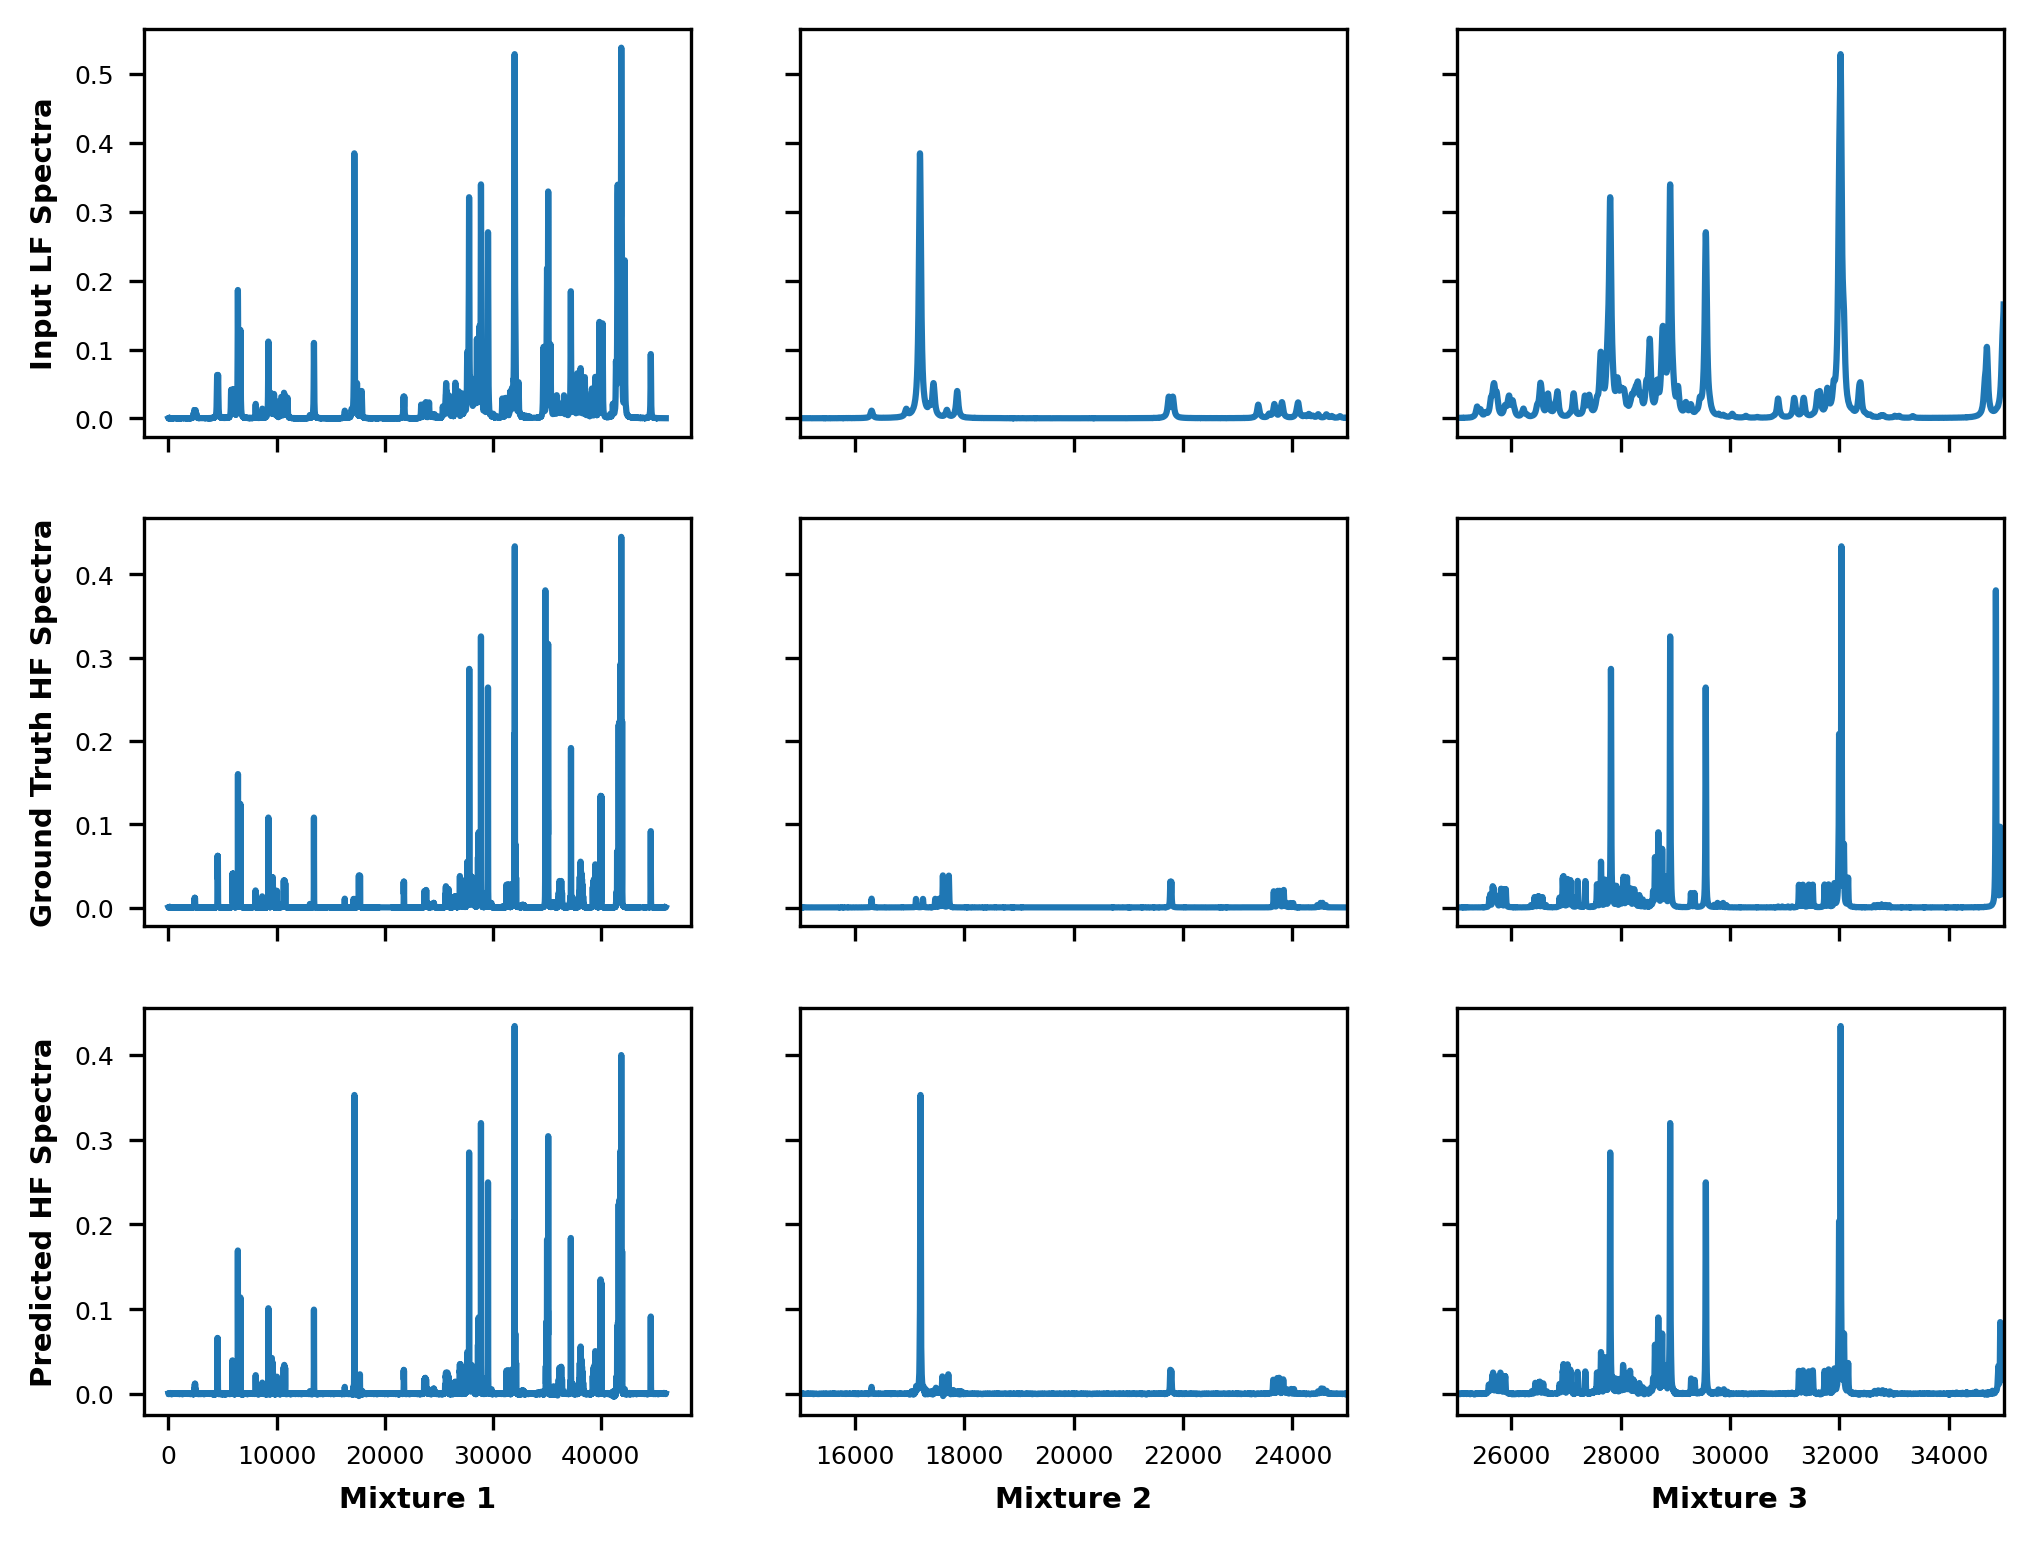

In [12]:
Predicted = model(spectraVal100[1].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectraVal100[1].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectraVal100[1].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectraVal100[1].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectraVal400[1].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectraVal400[1].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectraVal400[1].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

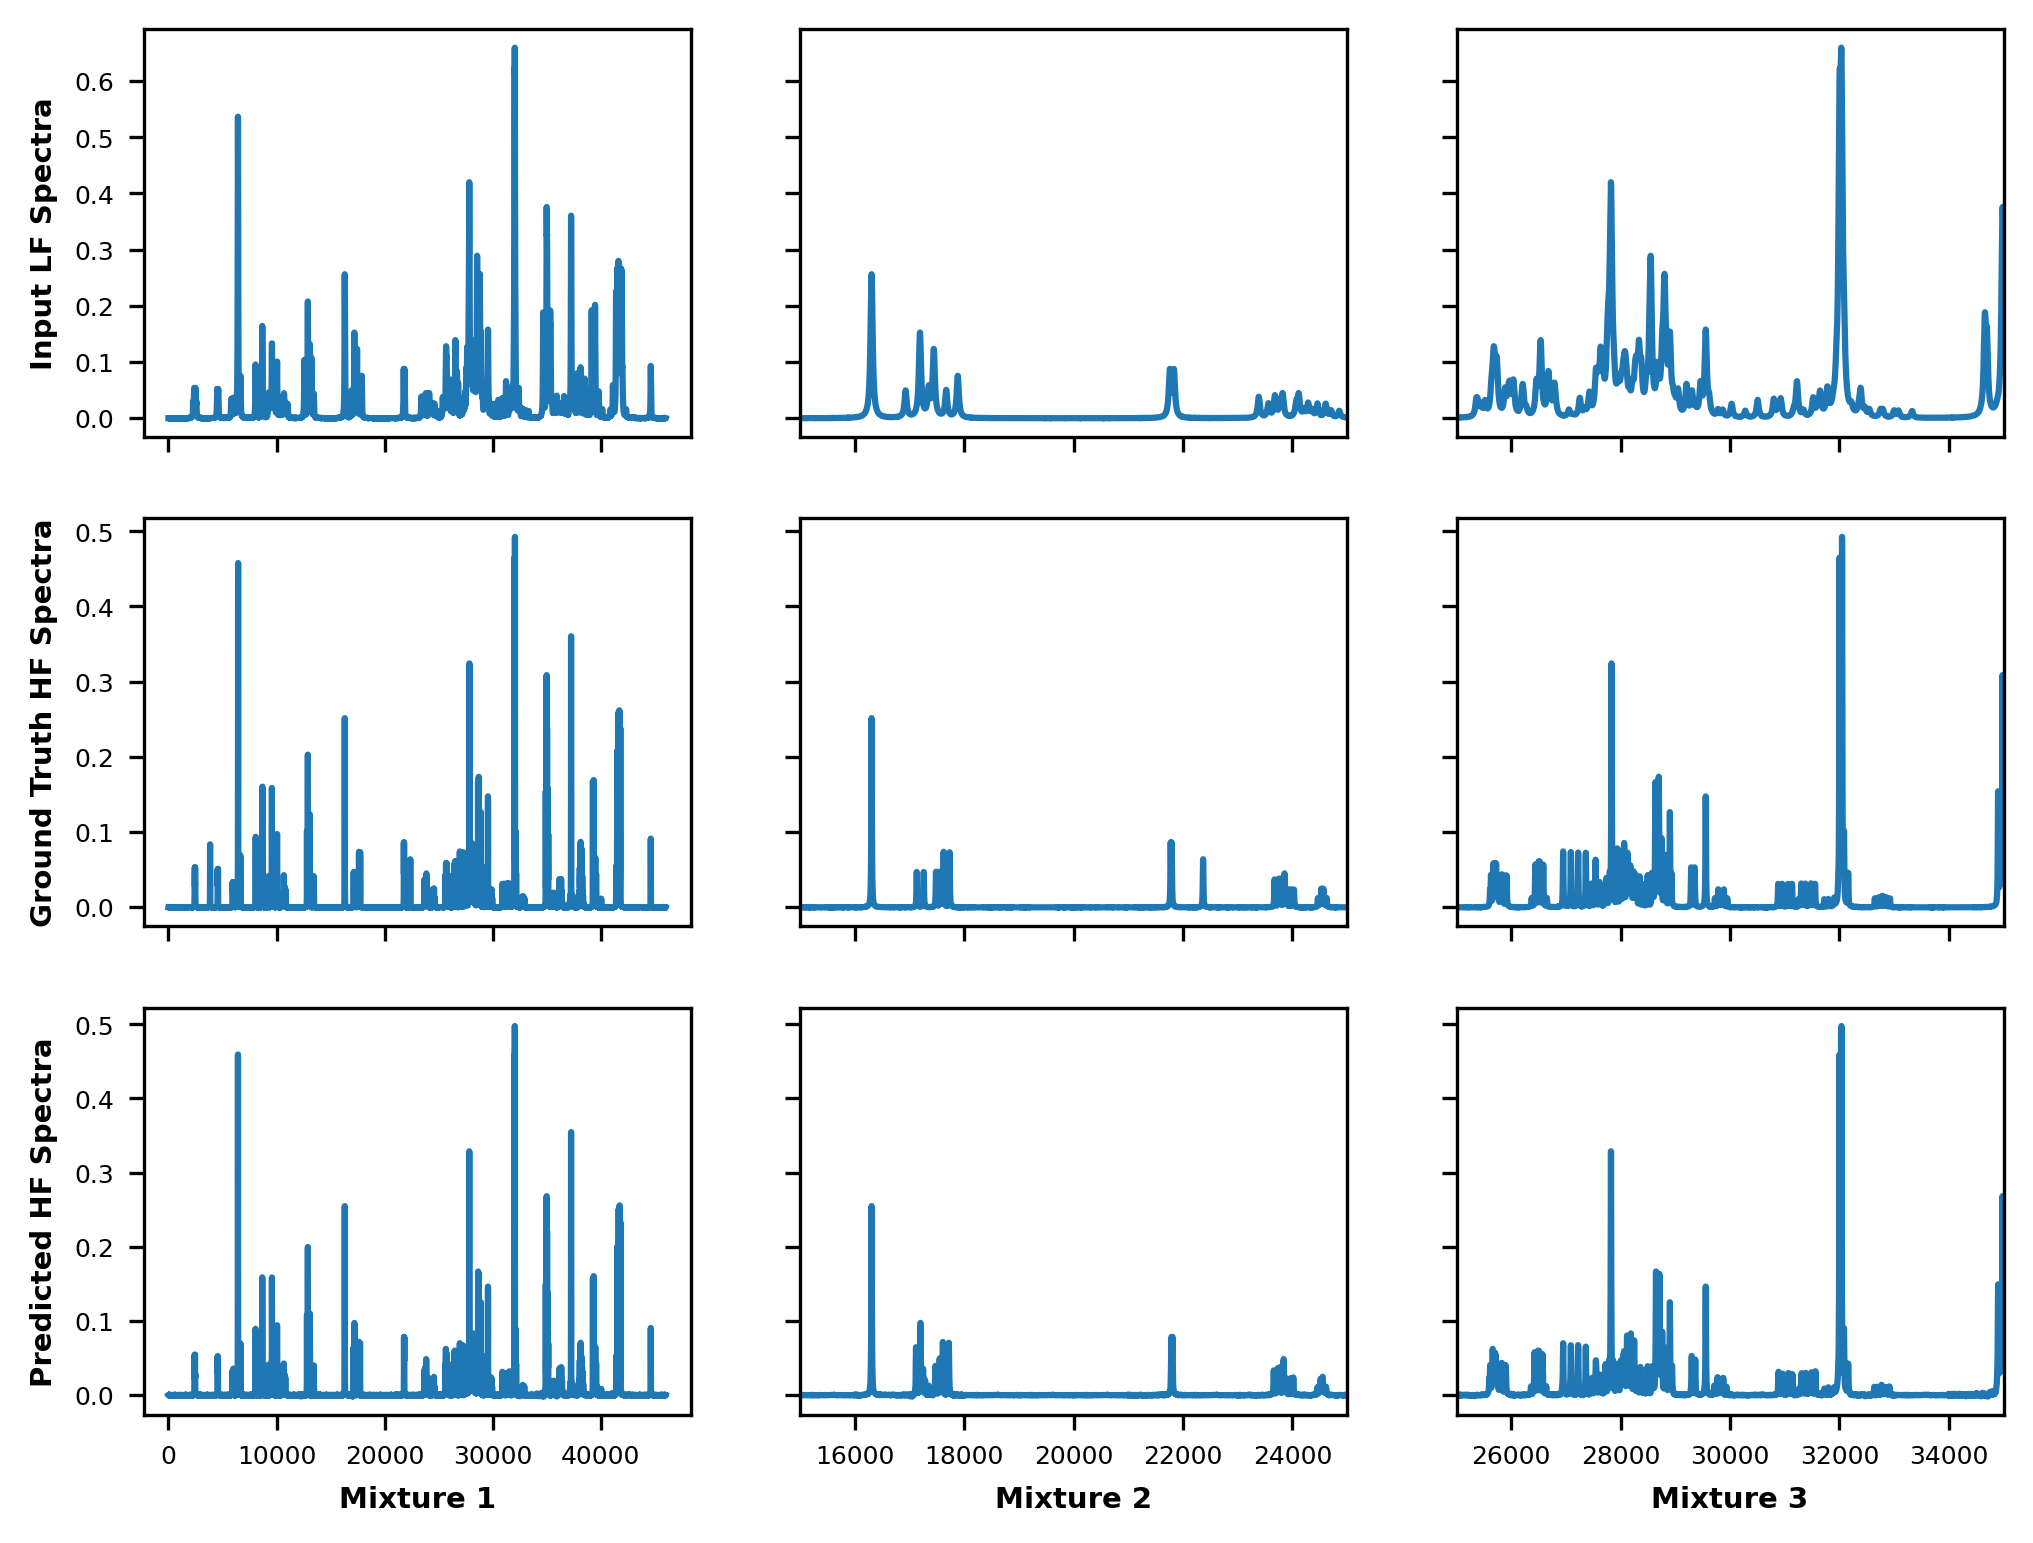

In [13]:
Predicted = model(spectraVal100[2].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectraVal100[2].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectraVal100[2].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectraVal100[2].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectraVal400[2].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectraVal400[2].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectraVal400[2].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

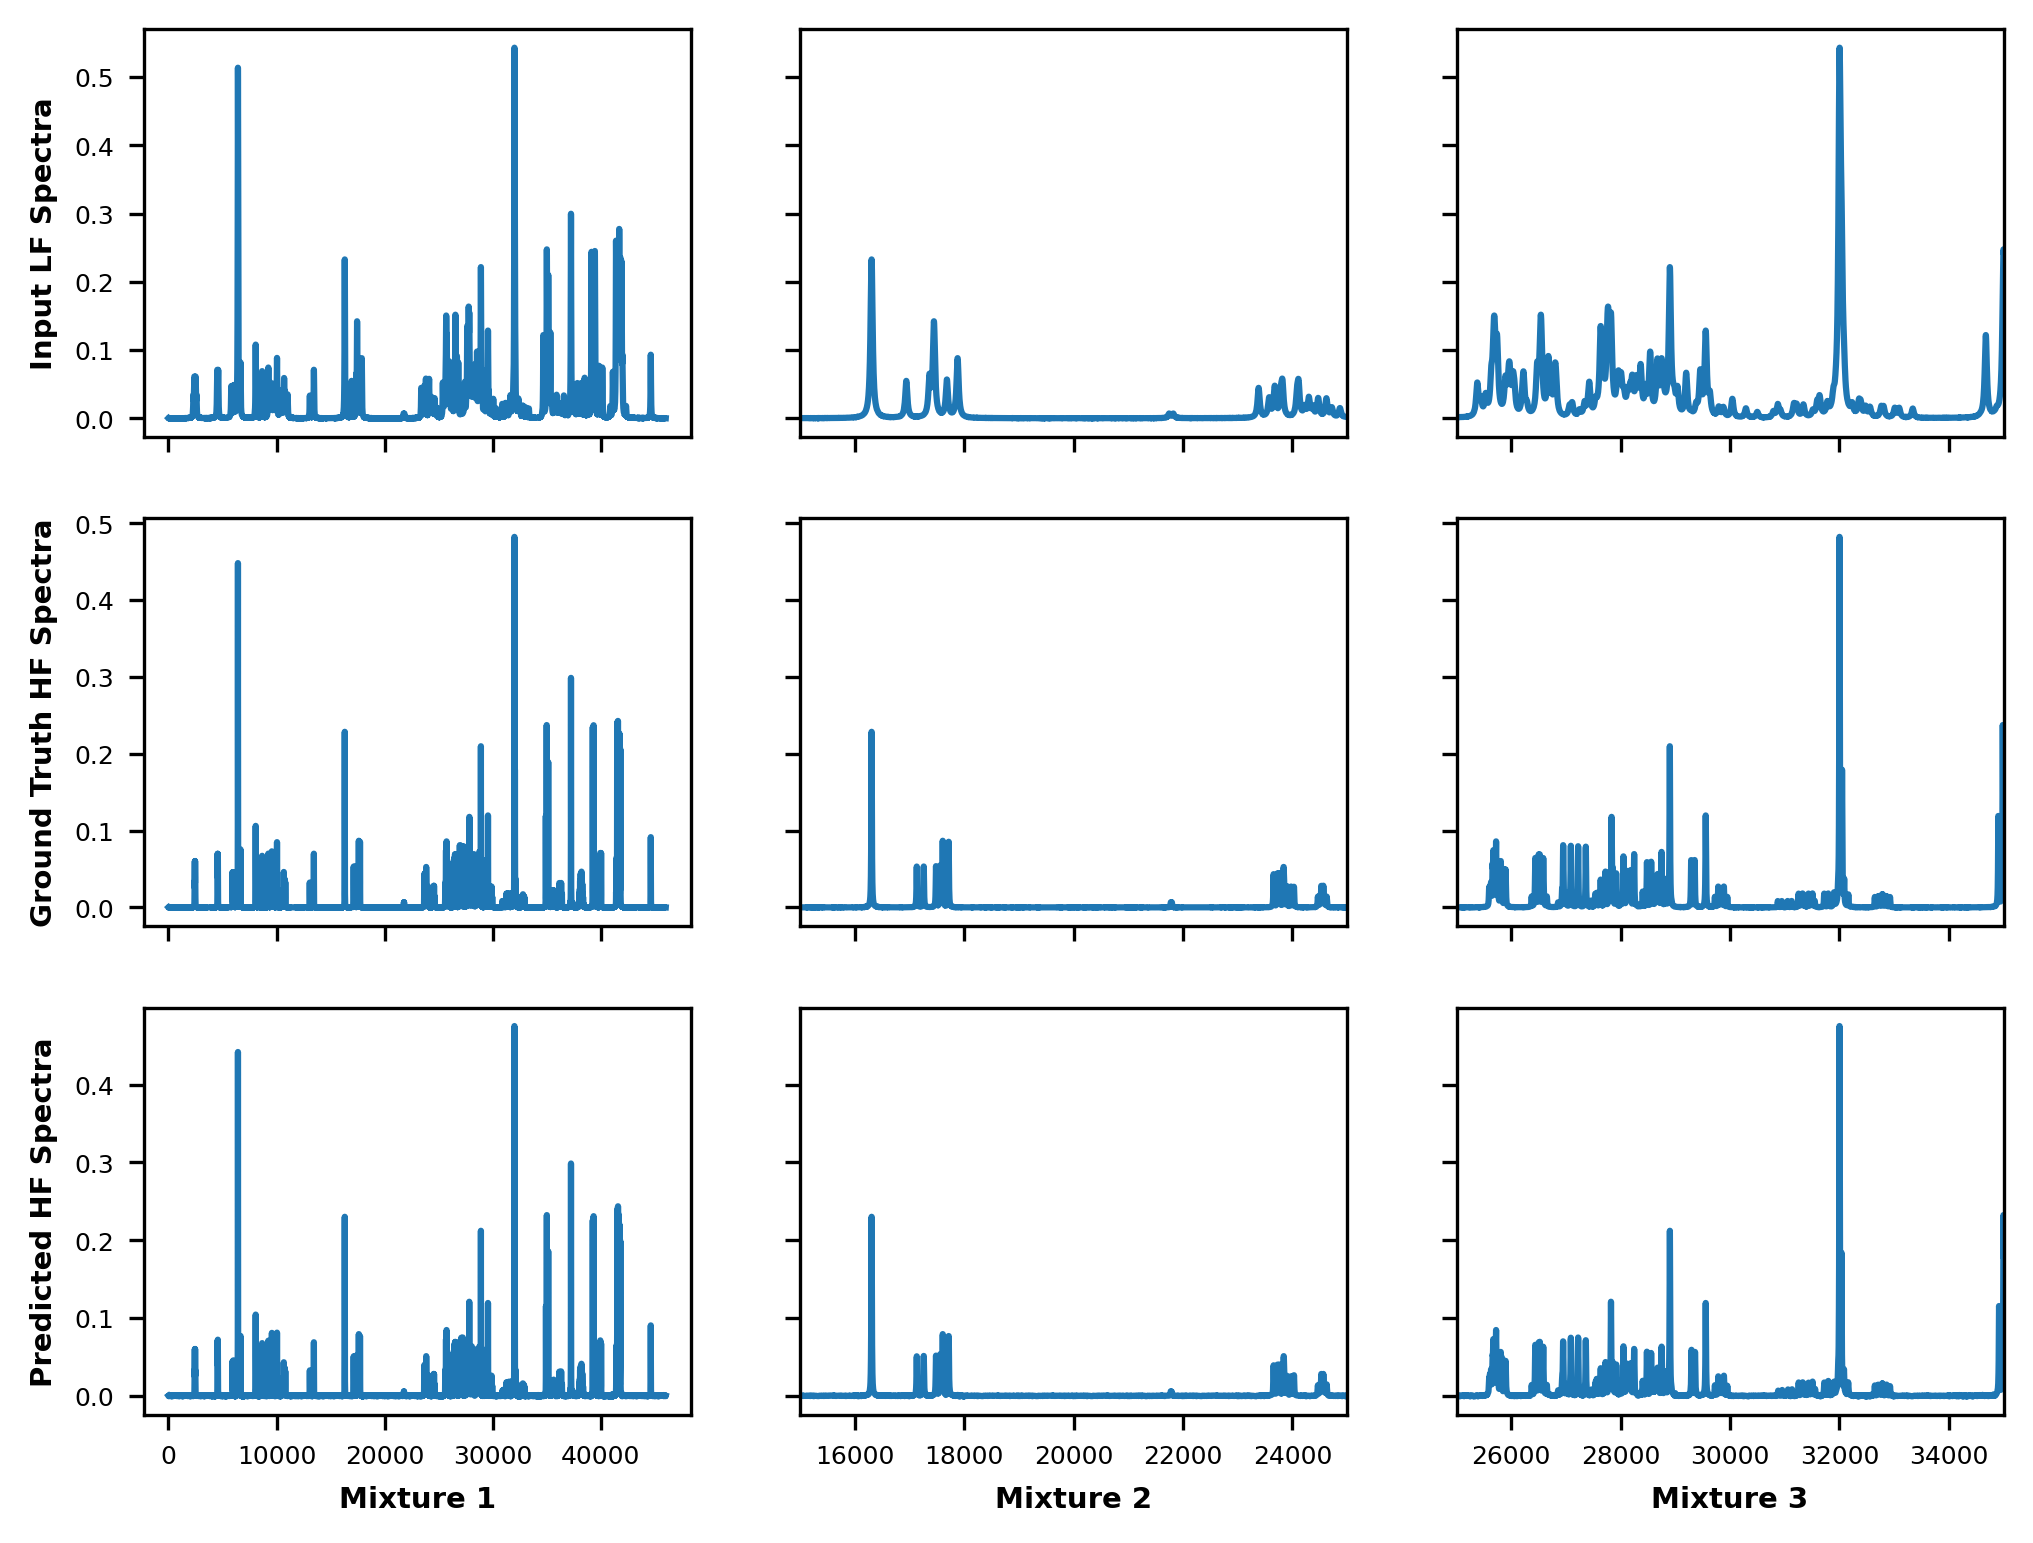

In [14]:
Predicted = model(spectraVal100[3].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectraVal100[3].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectraVal100[3].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectraVal100[3].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectraVal400[3].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectraVal400[3].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectraVal400[3].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

## Test on 12 metabolites not seen in training

In [26]:
# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400_12NewMet = np.load('Dataset21_Other12Met_400MHz_Val_Spec.npy')
spectra100_12NewMet = np.load('Dataset21_Other12Met_100MHz_Val_Spec.npy')
conc_12NewMet = np.load('Dataset21_Other12Met_Val_Conc.npy')

# Prepare for input into model
spectra400_12NewMet = torch.tensor(spectra400_12NewMet).float().to(device)
spectra100_12NewMet = torch.tensor(spectra100_12NewMet).float().to(device)

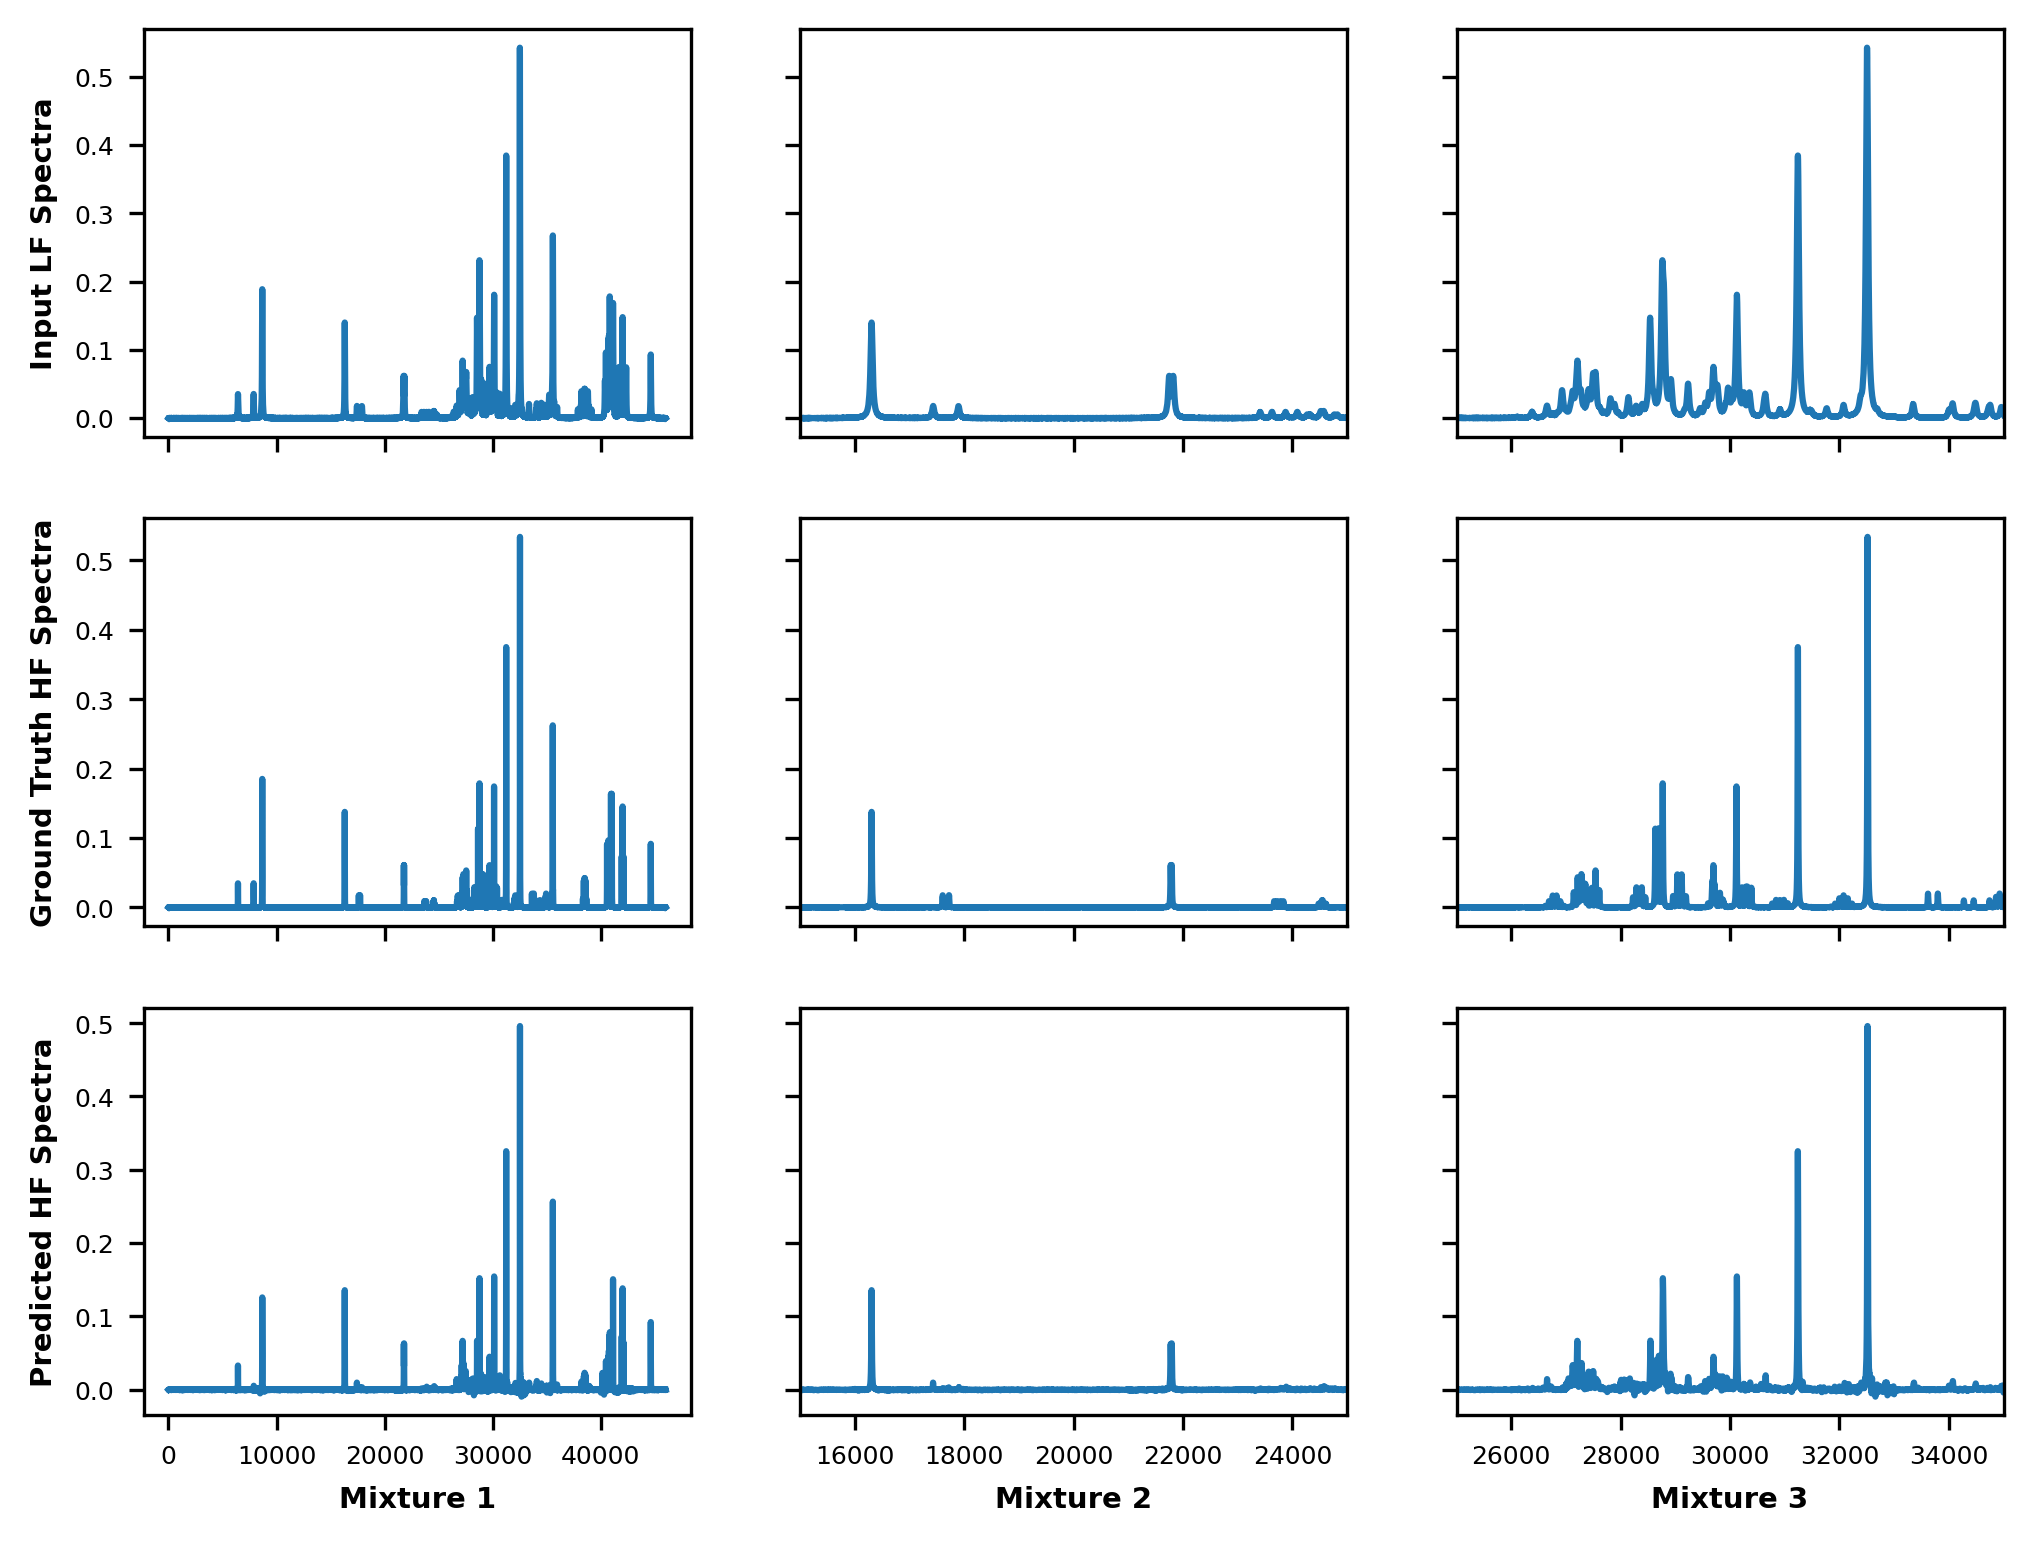

In [28]:
Predicted = model(spectra100_12NewMet[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectra100_12NewMet[0].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectra400_12NewMet[0].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

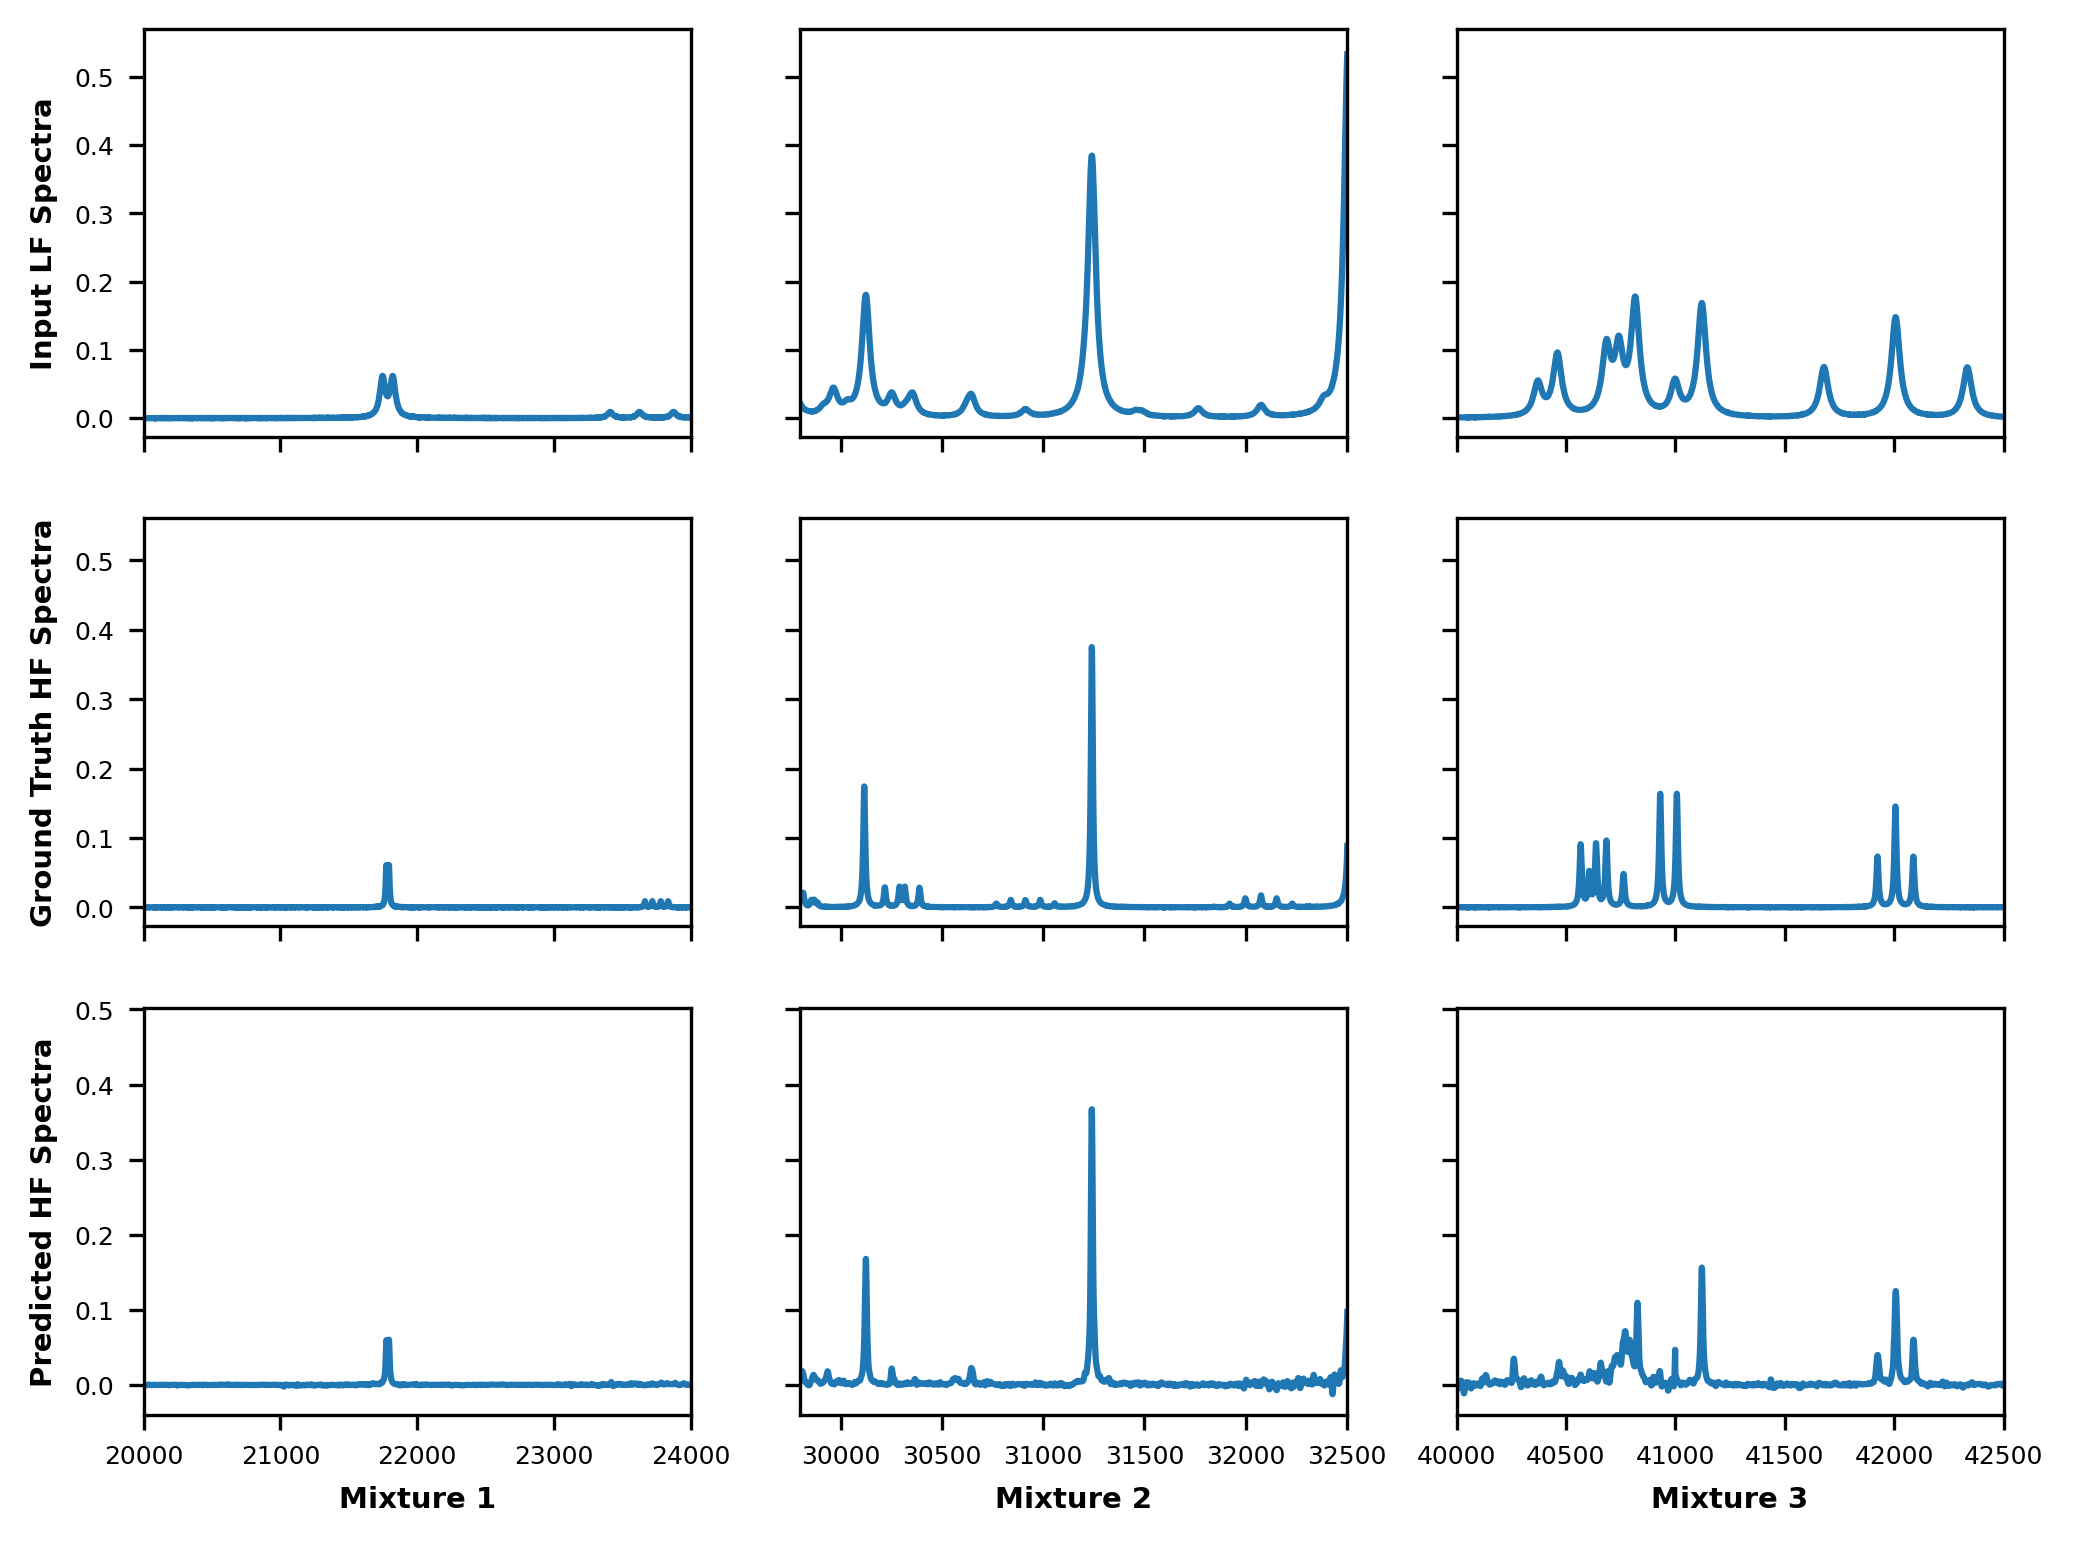

In [36]:
Predicted = model(spectra100_12NewMet[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 0].set_xlim([20000,24000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 1].set_xlim([29800,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 2].set_xlim([40000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 0].set_xlim([20000,24000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 1].set_xlim([29800,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 2].set_xlim([40000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([20000,24000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([29800,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([40000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

# Now train a model for quantification at low field and at high field, and compare LF-direct quantification to 'LF-to-HF prior to HF quantification'.

In [14]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1000
ModelName = "MLP_21Met_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [13]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_Spec_ForQuant.npy')
conc1 = np.load('Dataset21_400MHz_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra400 = np.load("Dataset21_400MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [7]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [8]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra400, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
RepConc = torch.tensor(RepConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter400 = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter400 = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [12]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 21
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(46000, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [14]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 100 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
        '''
        # Save model at specific epochs
        if epoch + 1 in [1000, 10000, 50000]:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{save_path}_epoch_{epoch+1}.pt')
        '''

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag


### Train HF MLP

In [13]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1500
ModelName = "MLP_21Met_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [42]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter400, test_iter400, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [100/1500], Train Loss: 25674.2379, Test Loss: 17681.2621
Epoch [200/1500], Train Loss: 17292.4104, Test Loss: 16929.5152
Epoch [300/1500], Train Loss: 14469.1291, Test Loss: 16981.4554
Epoch [400/1500], Train Loss: 12806.8348, Test Loss: 17533.7880
Epoch [500/1500], Train Loss: 11730.6630, Test Loss: 18071.6716
Epoch [600/1500], Train Loss: 10859.2749, Test Loss: 18714.9348
Epoch [700/1500], Train Loss: 9969.1251, Test Loss: 19548.2246
Epoch [800/1500], Train Loss: 9369.9619, Test Loss: 20021.9792
Epoch [900/1500], Train Loss: 8581.1389, Test Loss: 20252.2148
Epoch [1000/1500], Train Loss: 7956.5549, Test Loss: 20649.7472
Epoch [1100/1500], Train Loss: 7304.2669, Test Loss: 20969.9562
Epoch [1200/1500], Train Loss: 6798.4342, Test Loss: 21154.3690
Epoch [1300/1500], Train Loss: 6088.9087, Test Loss: 20988.1801
Epoch [1400/1500], Train Loss: 5737.3264, Test Loss: 20860.1067
Epoch [1500/1500], Train Loss: 5265.8176, Test Loss: 2080

In [14]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_400 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_400.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_400.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=21, bias=True)
)

In [15]:
model_400(RepSpectra400[2])

tensor([[24.9659, 24.7493, 24.6903, 25.1481, 24.6954, 24.8187, 24.9288, 24.8145,
         24.4929, 24.9084, 24.4479, 24.4052, 24.8999, 24.6383, 24.6484, 24.8774,
         24.6655, 24.8483, 24.4282, 25.3377, 25.3402]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [16]:
RepConc[2]

tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25.], device='cuda:0')

### Train LF MLP

In [12]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1500
ModelName = "MLP_21Met_ForLFtoHF__LFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [5]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra100 = np.load('Dataset21_100MHz_Spec_ForQuant.npy')
conc1 = np.load('Dataset21_100MHz_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal100 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [23]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
RepConc = torch.tensor(RepConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter100 = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter100 = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [52]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter100, test_iter100, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [100/1500], Train Loss: 39524.0055, Test Loss: 15934.8419
Epoch [200/1500], Train Loss: 29069.4514, Test Loss: 13444.5356
Epoch [300/1500], Train Loss: 25056.8042, Test Loss: 12460.9247
Epoch [400/1500], Train Loss: 19517.3205, Test Loss: 10590.4703
Epoch [500/1500], Train Loss: 14508.8813, Test Loss: 8883.7230
Epoch [600/1500], Train Loss: 12856.7557, Test Loss: 7756.6780
Epoch [700/1500], Train Loss: 11060.9054, Test Loss: 7731.9607
Epoch [800/1500], Train Loss: 8885.7496, Test Loss: 7245.7417
Epoch [900/1500], Train Loss: 7969.7711, Test Loss: 6777.3392
Epoch [1000/1500], Train Loss: 7042.9778, Test Loss: 6703.4089
Epoch [1100/1500], Train Loss: 6501.7111, Test Loss: 6678.0150
Epoch [1200/1500], Train Loss: 5961.1539, Test Loss: 6525.5484
Epoch [1300/1500], Train Loss: 5292.9950, Test Loss: 6288.1199
Epoch [1400/1500], Train Loss: 5011.8182, Test Loss: 6363.9986
Epoch [1500/1500], Train Loss: 4899.8132, Test Loss: 6396.2126
Exe

In [25]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_100 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_100.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_100.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=21, bias=True)
)

In [26]:
model_100(RepSpectra100[2])

tensor([[25.2135, 24.7472, 24.8089, 24.9522, 24.8042, 25.1324, 24.9888, 25.0929,
         25.0019, 24.9209, 24.8146, 25.1265, 25.1603, 25.0914, 24.7471, 24.8253,
         24.7749, 25.0764, 24.7317, 25.0754, 24.8297]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [27]:
model_400(RepSpectra400[2])

tensor([[24.9659, 24.7493, 24.6903, 25.1481, 24.6954, 24.8187, 24.9288, 24.8145,
         24.4929, 24.9084, 24.4479, 24.4052, 24.8999, 24.6383, 24.6484, 24.8774,
         24.6655, 24.8483, 24.4282, 25.3377, 25.3402]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [56]:
model_400(RepSpectra100[2])

tensor([[79.1592, 77.0922, 90.2086, 79.2625, 88.9957, 93.5728, 32.6962, 88.7691,
         75.4417, 84.4985, 24.6621, 79.2677, 81.2404, 62.9583, 82.6106, 73.4049,
         55.2668, 47.3596, 54.0255, 62.2238, 57.2828]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [69]:
model_400(model(RepSpectra100[2]))

tensor([[25.4157, 24.9578, 24.8487, 25.1978, 25.4371, 24.2945, 24.9238, 24.9961,
         25.0105, 24.8048, 24.3143, 24.9976, 24.5343, 24.5900, 23.9976, 25.0114,
         24.5219, 25.5948, 24.0873, 25.1276, 25.5837]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [70]:
RepConc[2]

tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25.], device='cuda:0')

In [29]:
model_100(RepSpectra100[0])

tensor([[ 1.0623,  0.7830,  0.7651,  0.2391, -0.2826,  0.4619,  0.3491,  0.6530,
          1.6041,  1.6697,  1.1141,  0.8177,  1.0525,  1.4633, -0.3063,  1.2023,
          1.5167,  1.2820,  1.2181,  1.1345,  1.3340]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [30]:
model_400(RepSpectra400[0])

tensor([[ 0.9355,  1.1233,  1.2178,  1.2098, -0.3844,  0.3044,  0.8127,  1.3705,
          0.7569,  0.6882,  0.7737,  1.3198,  1.3188,  1.2465,  0.0452,  1.1909,
          1.0878,  1.4589,  1.0760,  1.6413,  1.1894]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [31]:
model_400(RepSpectra100[0])

tensor([[ 8.8309,  8.3219,  8.1741, 11.9450,  6.7612,  7.6577,  7.8972, 11.5545,
         11.0380,  3.4482,  5.5525,  8.9064, 11.3265,  8.4488, 11.5260,  8.5346,
          4.3542,  6.2693,  4.1135,  0.4422,  4.0952]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [32]:
model_400(model(RepSpectra100[0]))

tensor([[ 0.6979,  0.4180,  0.3588,  0.9697, -1.3418, -0.6679,  0.0264,  0.7274,
          0.5362, -0.0430,  0.2631,  1.1118,  0.8182,  0.8585, -1.4597,  1.0061,
          0.3600,  1.4526,  0.2873,  1.2727,  0.5424]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [33]:
RepConc[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')

In [29]:
model_100(RepSpectra100[1])

tensor([[4.9554, 4.6249, 4.8320, 4.5619, 4.7052, 4.7645, 4.7870, 4.7340, 4.8553,
         4.8725, 4.7250, 4.9184, 4.6506, 4.8595, 4.6921, 4.8665, 4.9343, 4.8286,
         4.9432, 4.9290, 4.8487]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
model_400(RepSpectra400[1])

tensor([[4.6277, 4.7136, 4.7194, 4.6886, 4.8607, 4.9317, 4.5984, 4.6662, 4.4128,
         4.7274, 4.5557, 4.5697, 4.5700, 4.6447, 4.6396, 4.7338, 4.7263, 4.6742,
         4.5360, 5.0379, 4.8639]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [31]:
model_400(RepSpectra100[1])

tensor([[20.3804, 19.7292, 21.6549, 22.9662, 21.1763, 21.9223, 11.8468, 24.4310,
         21.6907, 17.0550,  8.7668, 20.2194, 22.8784, 17.2639, 24.2022, 19.5212,
         12.9704, 12.8790, 12.2155, 10.1397, 12.6716]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [32]:
model_400(model(RepSpectra100[1]))

tensor([[4.5391, 4.3470, 4.4415, 4.7314, 5.3467, 4.9402, 4.2952, 4.3733, 4.4150,
         4.4301, 4.3121, 4.3898, 4.6411, 4.5879, 4.4117, 4.5512, 4.8041, 4.5536,
         4.5069, 4.7761, 4.6322]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [38]:
RepConc[1]

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5.], device='cuda:0')

In [40]:
model_100(RepSpectra100[8])

tensor([[  2.2573,  35.0478,  -3.7157,  15.6525, -44.1202,  21.1846, -12.5963,
          18.4564,  10.3036,  59.8683,  -0.0751,  47.8980,  -6.5429,  48.5726,
         -43.7071,  52.5046,  10.6531,  56.4999,  12.3505,  46.9102,   6.9507]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [41]:
model_400(RepSpectra400[8])

tensor([[ -4.7902,  47.6175,   0.3444,  46.7290, -22.3670,  35.9349,  -5.3328,
          49.1607,  -5.4991,  47.8865,  -5.5035,  51.9605,  -1.7781,  51.2342,
         -21.3976,  50.8995,   2.0801,  51.6119,   0.6581,  59.9056,   2.3325]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [42]:
model_400(RepSpectra100[8])

tensor([[139.9187, 246.2232, 135.0906, 317.8869,  96.0688, 237.2517, 152.9615,
         307.0959, 193.4999, 107.7343, 115.6138, 206.0139, 194.7226, 217.9909,
         199.5262, 233.9972,  98.7450, 123.7575,  77.3250,  19.5364,  63.6364]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [52]:
model_400(model(RepSpectra100[8]))

tensor([[ 9.0119, 57.8751,  7.0925, 64.5045,  6.1663, 55.9595, 10.7776, 64.8537,
         12.4241, 51.6467,  7.1429, 59.3629, 12.7506, 59.5668, 13.5677, 61.1596,
          3.8378, 57.7053,  2.5079, 46.3829,  3.4473]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [44]:
RepConc[8]

tensor([ 1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1.], device='cuda:0')

In [41]:
# Calculate MAPE for each example
def calculate_mape(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

In [36]:
RepSpectra100.size()

torch.Size([11, 1, 46000])

In [38]:
RepConc.size()

torch.Size([11, 21])

In [46]:
GT = RepConc
Pred = model_100(RepSpectra100)

Pred = Pred.view([11,21])

# List to store MAPE for each example
mape_list = []

# Iterate over each example
for i in range(RepSpectra100.size(0)):
    mape = calculate_mape(GT[i], Pred[i])
    mape_list.append(mape.item())

# Print the MAPE for each example
for idx, mape in enumerate(mape_list):
    print(f"{RepSpecNames[idx]} -- MAPE: {mape:.2f}%")

AllAq1 -- MAPE: 43.68%
AllAq5 -- MAPE: 3.92%
AllAq25 -- MAPE: 0.58%
AllAq50 -- MAPE: 0.55%
ThreeAddedSinglets -- MAPE: 1.68%
ThirtyAddedSinglets -- MAPE: 7.01%
ShiftedSpec -- MAPE: 66.97%
SineBase -- MAPE: 41.46%
HighDynamicRange -- MAPE: 747.50%
HalfZeros -- MAPE: inf%
Blank -- MAPE: inf%


In [49]:

GT = RepConc
Pred = model_400(RepSpectra400)

Pred = Pred.view([11,21])

# List to store MAPE for each example
mape_list = []

# Iterate over each example
for i in range(RepSpectra100.size(0)):
    mape = calculate_mape(GT[i], Pred[i])
    mape_list.append(mape.item())

# Print the MAPE for each example
for idx, mape in enumerate(mape_list):
    print(f"{RepSpecNames[idx]} -- MAPE: {mape:.2f}%")

AllAq1 -- MAPE: 35.80%
AllAq5 -- MAPE: 6.26%
AllAq25 -- MAPE: 1.12%
AllAq50 -- MAPE: 0.84%
ThreeAddedSinglets -- MAPE: 4.77%
ThirtyAddedSinglets -- MAPE: 13.56%
ShiftedSpec -- MAPE: 81.23%
SineBase -- MAPE: 11.34%
HighDynamicRange -- MAPE: 370.69%
HalfZeros -- MAPE: inf%
Blank -- MAPE: inf%


In [48]:

GT = RepConc
Pred = model_400(RepSpectra100)

Pred = Pred.view([11,21])

# List to store MAPE for each example
mape_list = []

# Iterate over each example
for i in range(RepSpectra100.size(0)):
    mape = calculate_mape(GT[i], Pred[i])
    mape_list.append(mape.item())

# Print the MAPE for each example
for idx, mape in enumerate(mape_list):
    print(f"{RepSpecNames[idx]} -- MAPE: {mape:.2f}%")

AllAq1 -- MAPE: 663.40%
AllAq5 -- MAPE: 258.65%
AllAq25 -- MAPE: 180.13%
AllAq50 -- MAPE: 171.18%
ThreeAddedSinglets -- MAPE: 183.30%
ThirtyAddedSinglets -- MAPE: 218.93%
ShiftedSpec -- MAPE: 53.72%
SineBase -- MAPE: 186.55%
HighDynamicRange -- MAPE: 7084.18%
HalfZeros -- MAPE: inf%
Blank -- MAPE: inf%


In [56]:
model_400(model(RepSpectra100[0]))

tensor([[ 0.7112,  0.5521,  0.4334,  0.9229, -1.1811, -0.3776,  0.3355,  0.8115,
          0.4782,  0.1162,  0.3083,  1.2126,  0.8598,  1.0287, -1.1402,  0.9852,
          0.5115,  1.5894,  0.4336,  1.3953,  0.6796]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [65]:
# Define your MAPE function
def mape(pred, target):
    return torch.mean(torch.abs((target - pred) / target)) * 100

# Initialize empty list to store individual MAPEs
mapes = []

# Iterate through each example in the batch
for i in range(RepSpectra100.size(0)):
    # Get the individual example
    example = RepSpectra100[i]
    
    # Pass through the model
    pred_100 = model(example)
    pred_400 = model_400(pred_100)
    
    # Get the ground truth for this example
    gt = GT[i]
    
    # Compute MAPE
    individual_mape = mape(pred_400, gt)
    
    # Append to the list of MAPEs
    mapes.append(individual_mape.item())

# Print the MAPEs for all 11 examples
for idx, m in enumerate(mapes):
    print(f"{RepSpecNames[idx]} -- MAPE = {m:.2f}%")

AllAq1 -- MAPE = 60.89%
AllAq5 -- MAPE = 9.21%
AllAq25 -- MAPE = 1.47%
AllAq50 -- MAPE = 1.03%
ThreeAddedSinglets -- MAPE = 4.79%
ThirtyAddedSinglets -- MAPE = 11.38%
ShiftedSpec -- MAPE = 81.14%
SineBase -- MAPE = 3.60%
HighDynamicRange -- MAPE = 378.34%
HalfZeros -- MAPE = inf%
Blank -- MAPE = inf%


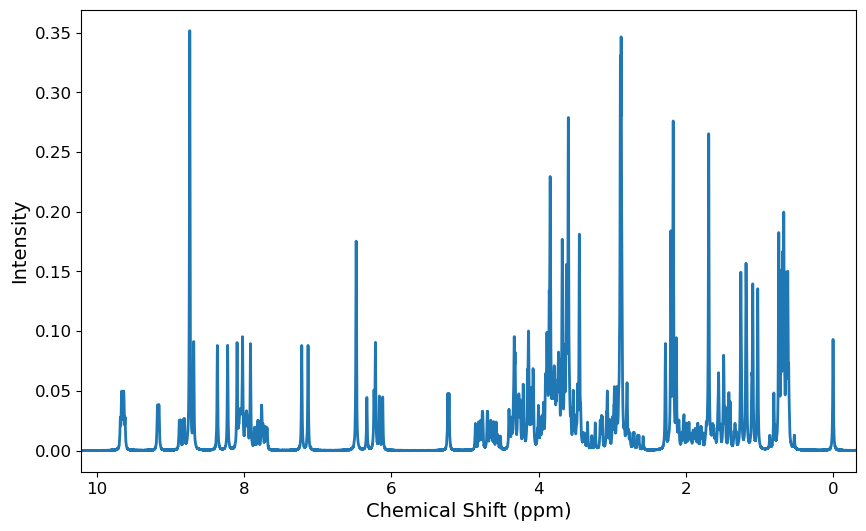

In [26]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

plt.plot(ppm, RepSpectra100[2][0], linewidth=2)  # Adjust linewidth here

# Set axis limits
plt.xlim(ppm[0], ppm[-1])

# Set labels for x and y axes with adjustable font size
plt.xlabel('Chemical Shift (ppm)', fontsize=14)  # Adjust label size
plt.ylabel('Intensity', fontsize=14)  # Adjust label size

# Adjust tick mark sizes
plt.xticks(fontsize=12)  # Adjust x-axis tick mark size
plt.yticks(fontsize=12)  # Adjust y-axis tick mark size

# Display the plot
plt.show()


IndexError: index 46000 is out of bounds for axis 0 with size 46000

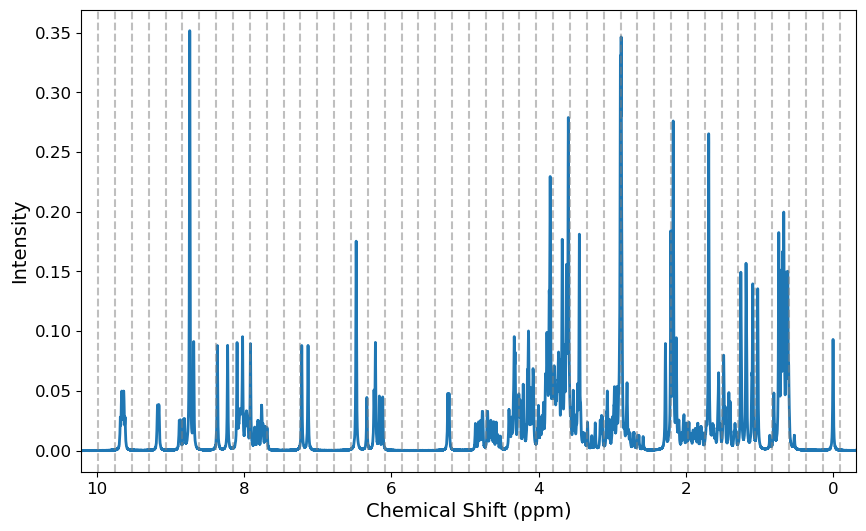

In [31]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot the spectra
plt.plot(ppm, RepSpectra100[2][0], linewidth=2)  # Adjust linewidth here

# Set axis limits
plt.xlim(ppm[0], ppm[-1])

# Set labels for x and y axes with adjustable font size
plt.xlabel('Chemical Shift (ppm)', fontsize=14)  # Adjust label size
plt.ylabel('Intensity', fontsize=14)  # Adjust label size

# Adjust tick mark sizes
plt.xticks(fontsize=12)  # Adjust x-axis tick mark size
plt.yticks(fontsize=12)  # Adjust y-axis tick mark size

# Insert transparent gray vertical lines every 1000 data points in the x-direction
num_lines = len(ppm) // 1000
for i in range(1, num_lines + 1):
    x_position = ppm[1000 * i]  # Position every 1000 points in the x-direction
    plt.axvline(x=x_position, color='gray', linestyle='--', alpha=0.5)  # Add a vertical line

# Display the plot
plt.show()


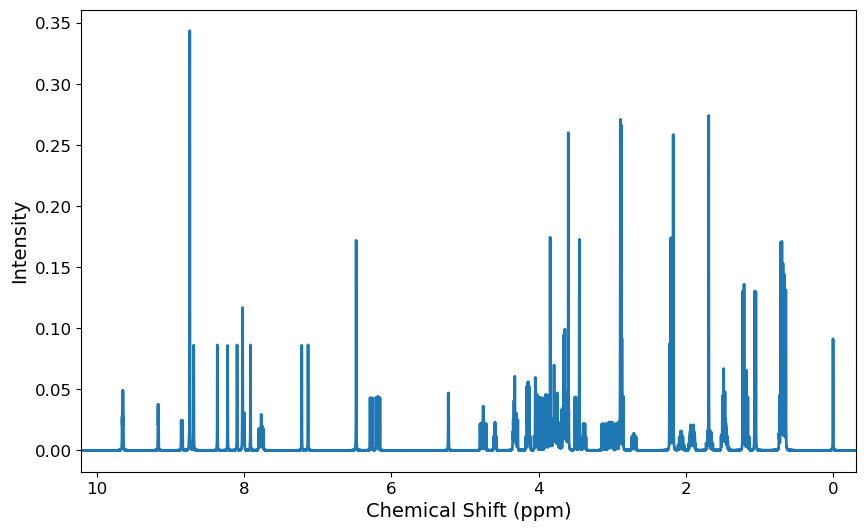

In [27]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

plt.plot(ppm, RepSpectra400[2][0], linewidth=2)  # Adjust linewidth here

# Set axis limits
plt.xlim(ppm[0], ppm[-1])

# Set labels for x and y axes with adjustable font size
plt.xlabel('Chemical Shift (ppm)', fontsize=14)  # Adjust label size
plt.ylabel('Intensity', fontsize=14)  # Adjust label size

# Adjust tick mark sizes
plt.xticks(fontsize=12)  # Adjust x-axis tick mark size
plt.yticks(fontsize=12)  # Adjust y-axis tick mark size

# Display the plot
plt.show()

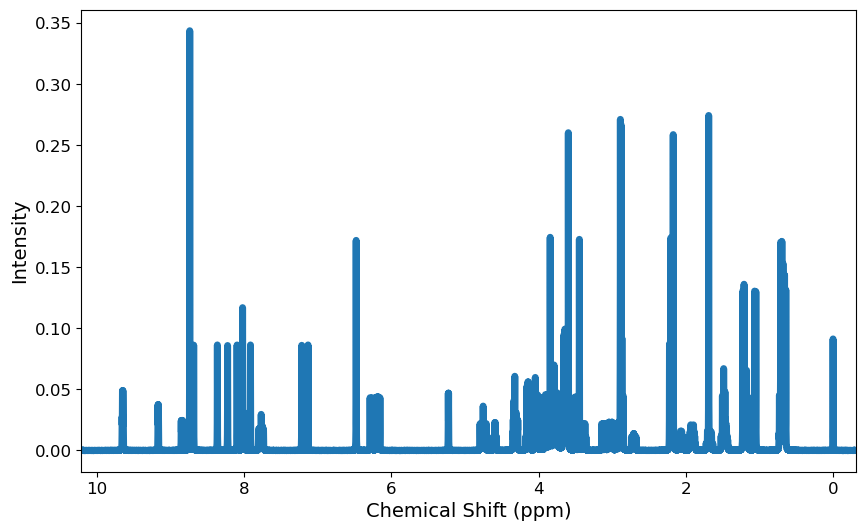

In [14]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

plt.plot(ppm, RepSpectra400[2][0], linewidth=5)  # Adjust linewidth here

# Set axis limits
plt.xlim(ppm[0], ppm[-1])

# Set labels for x and y axes with adjustable font size
plt.xlabel('Chemical Shift (ppm)', fontsize=14)  # Adjust label size
plt.ylabel('Intensity', fontsize=14)  # Adjust label size

# Adjust tick mark sizes
plt.xticks(fontsize=12)  # Adjust x-axis tick mark size
plt.yticks(fontsize=12)  # Adjust y-axis tick mark size

# Display the plot
plt.show()


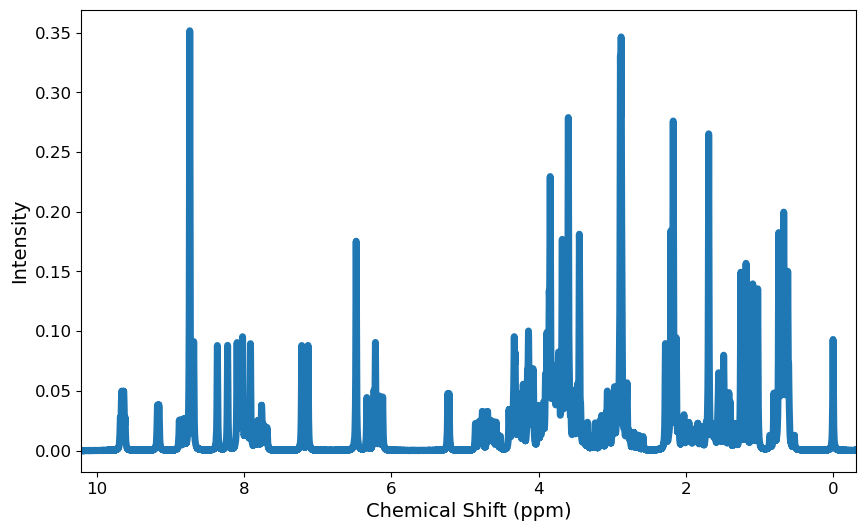

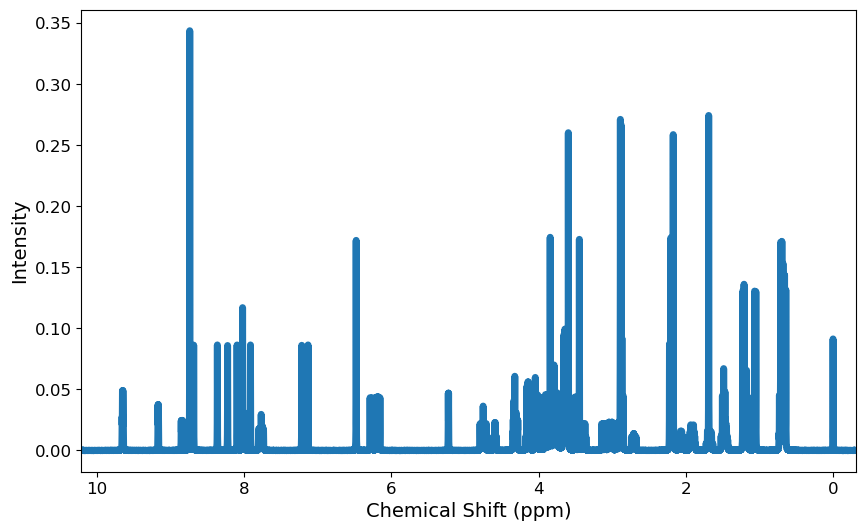

In [32]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

plt.plot(ppm, RepSpectra100[2][0], linewidth=5)  # Adjust linewidth here

# Set axis limits
plt.xlim(ppm[0], ppm[-1])

# Set labels for x and y axes with adjustable font size
plt.xlabel('Chemical Shift (ppm)', fontsize=14)  # Adjust label size
plt.ylabel('Intensity', fontsize=14)  # Adjust label size

# Adjust tick mark sizes
plt.xticks(fontsize=12)  # Adjust x-axis tick mark size
plt.yticks(fontsize=12)  # Adjust y-axis tick mark size

# Display the plot
plt.show()





# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

plt.plot(ppm, RepSpectra400[2][0], linewidth=5)  # Adjust linewidth here

# Set axis limits
plt.xlim(ppm[0], ppm[-1])

# Set labels for x and y axes with adjustable font size
plt.xlabel('Chemical Shift (ppm)', fontsize=14)  # Adjust label size
plt.ylabel('Intensity', fontsize=14)  # Adjust label size

# Adjust tick mark sizes
plt.xticks(fontsize=12)  # Adjust x-axis tick mark size
plt.yticks(fontsize=12)  # Adjust y-axis tick mark size

# Display the plot
plt.show()